# Machine learning - Coursework 1
## Infrared Thermography Temperature Dataset

### Eoin Houstoun

### Goldsmiths, University of London

_______

<img src="https://figures.semanticscholar.org/8d02352736f83f0d153ec956b610ee1d79a404e2/5-Figure2-1.png" alt="Monte Carlo CV Pipeline" width="800">

**Infrared Thermography for Measuring Elevated Body Temperature: Clinical Accuracy, Calibration, and Evaluation**  
*Wang & Zhou, Published in the Italian National Conference on Sensors, 2021*  
[View Paper on Semantic Scholar](https://www.semanticscholar.org/paper/Infrared-Thermography-for-Measuring-Elevated-Body-Wang-Zhou/443b9932d295ca3a014e7d874b4bd77a33a276bd)


This project explores the application of machine learning techniques to predict oral body temperature and fever status using sensor data from thermal infrared images. Inspired by the work of [Wang et al. (2022)](https://www.mdpi.com/1424-8220/22/1/215), which demonstrated the clinical potential of infrared thermography in fever screening, the task involves developing models that can infer oral temperature, both as a continuous variable and a binary fever indicator (≥ 37.5°C), from more accessible, non-invasive temperature readings.

Using the Infrared Thermography Temperature Dataset, which includes environmental and demographic variables alongside thermal readings from various facial regions, the project addresses two core objectives:

**Regression:** Predict the exact oral temperature (in °C) in both Fast Mode (aveOralF) and Monitor Mode (aveOralM).

**Classification:** Predict whether a person has a fever (≥ 37.5°C) based on Fast and Monitor Mode measurements.

This work is motivated by the broader goal of improving non-contact fever screening tools through accurate, interpretable, and computationally efficient machine learning models.

# Libraries

In [1]:
# Numerical & Data Manipulation
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import t

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.ticker as mtick
from tabulate import tabulate

# Scikit-learn – Preprocessing & Pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn – Imputation
from sklearn.impute import KNNImputer

# Scikit-learn – Model Selection
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold,
    ParameterGrid, cross_val_score
)

# Scikit-learn – Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn – Regression Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Scikit-learn – Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, roc_curve,
    mean_squared_error, mean_absolute_error,root_mean_squared_error, r2_score,
    make_scorer, classification_report
)
from sklearn.calibration import calibration_curve

# XGBoost
from xgboost import XGBClassifier, XGBRegressor

# General Utilities
import os
import re
import warnings
from collections import defaultdict, Counter

# Google Drive (Colab Only)
from google.colab import drive
drive.mount('/content/drive')

# Paths for saving results
save_path_c_f = "/content/drive/MyDrive/Colab Notebooks/ML/CW1/RESULTS/CLASSIFICATION/AVE_F"
save_path_c_m = "/content/drive/MyDrive/Colab Notebooks/ML/CW1/RESULTS/CLASSIFICATION/AVE_M"
save_path_r_f = "/content/drive/MyDrive/Colab Notebooks/ML/CW1/RESULTS/REGRESSION/AVE_F"
save_path_r_m = "/content/drive/MyDrive/Colab Notebooks/ML/CW1/RESULTS/REGRESSION/AVE_M"

# Suppress Warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. DATASET EXPLORATION**

In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
infrared_thermography_temperature = fetch_ucirepo(id=925)

# data (as pandas dataframes)
X = infrared_thermography_temperature.data.features
y = infrared_thermography_temperature.data.targets

# metadata
print(infrared_thermography_temperature.metadata)

# variable information
infrared_thermography_temperature.variables

{'uci_id': 925, 'name': 'Infrared Thermography Temperature', 'repository_url': 'https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/925/data.csv', 'abstract': 'The Infrared Thermography Temperature Dataset contains temperatures read from various locations of inferred images about patients, with the addition of oral temperatures measured for each individual. The 33 features consist of gender, age, ethnicity, ambiant temperature, humidity, distance, and other temperature readings from the thermal images. The dataset is intended to be used in a regression task to predict the oral temperature using the environment information as well as the thermal image readings. ', 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 1020, 'num_features': 33, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Gender', 'Age', 'Ethnicity'], 'target_col': ['aveO

name     role         type demographic  \
0     SubjectID       ID  Categorical        None   
1      aveOralF   Target   Continuous        None   
2      aveOralM   Target   Continuous        None   
3        Gender  Feature  Categorical      Gender   
4           Age  Feature  Categorical         Age   
5     Ethnicity  Feature  Categorical   Ethnicity   
6         T_atm  Feature   Continuous        None   
7      Humidity  Feature   Continuous        None   
8      Distance  Feature   Continuous        None   
9     T_offset1  Feature   Continuous        None   
10    Max1R13_1  Feature   Continuous        None   
11    Max1L13_1  Feature   Continuous        None   
12  aveAllR13_1  Feature   Continuous        None   
13  aveAllL13_1  Feature   Continuous        None   
14        T_RC1  Feature   Continuous        None   
15    T_RC_Dry1  Feature   Continuous        None   
16    T_RC_Wet1  Feature   Continuous        None   
17    T_RC_Max1  Feature   Continuous        None   
18        T_LC1  Feature   Continuous        None   
19    T_LC_Dry1  Feature   Continuous        None   
20    T_LC_Wet1  Feature   Continuous        None   
21    T_LC_Max1  Feature   Continuous        None   
22         RCC1  Feature   Continuous        None   
23         LCC1  Feature   Continuous        None   
24   canthiMax1  Feature   Continuous        None   
25  canthi4Max1  Feature   Continuous        None   
26      T_FHCC1  Feature   Continuous        None   
27      T_FHRC1  Feature   Continuous        None   
28      T_FHLC1  Feature   Continuous        None   
29      T_FHBC1  Feature   Continuous        None   
30      T_FHTC1  Feature   Continuous        None   
31    T_FH_Max1  Feature   Continuous        None   
32   T_FHC_Max1  Feature   Continuous        None   
33       T_Max1  Feature   Continuous        None   
34        T_OR1  Feature   Continuous        None   
35    T_OR_Max1  Feature   Continuous        None   

                                          description units missing_values  
0                                          Subject ID  None             no  
1              Oral temperature measured in fast mode  None             no  
2           Oral temperature measured in monitor mode  None             no  
3                                      Male or Female  None             no  
4                          Age ranges in categories\n  None             no  
5   American Indian or Alaska Native, Asian, Black...  None             no  
6                                 Ambiant temperature  None             no  
7                                   Relative humidity  None             no  
8       Distance between the subjects and the IRTs.    None             no  
9   Temperature difference between the set and mea...  None             no  
10  Max value of a circle with diameter of 13 pixe...  None             no  
11  Max value of a circle with diameter of 13 pixe...  None             no  
12  Average value of a circle with diameter of 13 ...  None             no  
13  Average value of a circle with diameter of 13 ...  None             no  
14  Average temperature of the highest four pixels...  None             no  
15  Average temperature of the highest four pixels...  None             no  
16  Average temperature of the highest four pixels...  None             no  
17  Max value of a square of 24x24 pixels around t...  None             no  
18  Average temperature of the highest four pixels...  None             no  
19  Average temperature of the highest four pixels...  None             no  
20  Average temperature of the highest four pixels...  None             no  
21  Max value of a circle with diameter of 13 pixe...  None             no  
22  Average value of a square of 3x3 pixels center...  None             no  
23  Average value of a square of 3x3 pixels center...  None             no  
24              Max value in the extended canthi area  None             no  
25  Average temperature of the highest four pix

## 1.1 Feature Exploration Functions

In [5]:
## OUTLIER DETECTION
def detect_outliers(X, extreme_threshold=5):
    """
    Detects extreme outliers in numerical features using an aggressive IQR method (3 × IQR rule).

    Args:
        X (pd.DataFrame): The dataset (features only, no target variable).
        extreme_threshold (float): The multiplier for the IQR to define extreme outliers (default is 3).

    Returns:
        pd.DataFrame: A summary of extreme outliers for each numeric column.
    """

    if not isinstance(X, pd.DataFrame):
        print("❌ Error: Input `X` must be a Pandas DataFrame.")
        return None

    # Select numerical columns only
    numeric_cols = X.select_dtypes(include=['number'])

    # Describe dataset
    summary = numeric_cols.describe()

    # Compute IQR
    Q1 = summary.loc['25%']
    Q3 = summary.loc['75%']
    IQR = Q3 - Q1

    # Define more extreme outlier thresholds (3 × IQR instead of 1.5 × IQR)
    lower_bound = Q1 - extreme_threshold * IQR
    upper_bound = Q3 + extreme_threshold * IQR

    # Identify extreme outliers
    extreme_outlier_mask = (numeric_cols < lower_bound) | (numeric_cols > upper_bound)
    extreme_outlier_counts = extreme_outlier_mask.sum()

    # Compute extreme outlier percentage
    extreme_outlier_percent = (extreme_outlier_counts / len(X)) * 100

    # Create summary DataFrame
    extreme_outlier_summary = pd.DataFrame({
        "Outlier Count": extreme_outlier_counts,
        "Outlier Percentage (%)": extreme_outlier_percent
    }).sort_values(by="Outlier Percentage (%)", ascending=False)

    # Display results
    print("\\n Outlier Detection Summary:")
    print(extreme_outlier_summary)

    # Plot histograms of features with extreme outliers
    extreme_cols = extreme_outlier_summary[extreme_outlier_summary["Outlier Count"] > 0].index
    if len(extreme_cols) > 0:
        for col in extreme_cols:
            plt.figure(figsize=(8, 5))
            sns.histplot(X[col], bins=30, kde=True, color="red")
            plt.axvline(lower_bound[col], color='blue', linestyle="dashed", label="Lower Bound")
            plt.axvline(upper_bound[col], color='blue', linestyle="dashed", label="Upper Bound")
            plt.title(f"Histogram of {col} with Outliers", fontsize=14, fontweight="bold")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()

    return extreme_outlier_summary
# Class Distribution (BINARY)
def class_distribution(y, target_name="Target Variable"):
    """
    Plots and prints the class distribution for a binary classification problem.

    Args:
        y (pd.Series): The target variable (should contain 'Yes'/'No' or 0/1).
        target_name (str): The name of the target variable for plot title.
    """
    if not isinstance(y, pd.Series):
        print("Error: Input `y` must be a Pandas Series.")
        return

    unique_vals = y.unique()
    if len(unique_vals) != 2:
        print(f"Error: {target_name} is not binary. Found values: {unique_vals}")
        return

    class_counts = y.value_counts()

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=y, palette=sns.color_palette(['red', 'limegreen']),
                       order=class_counts.index, legend=False)

    ax.set_title(f'Frequency of {target_name}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=15, color='black', fontweight='bold')

    yes_count, no_count = class_counts.iloc[0], class_counts.iloc[1]
    yes_label, no_label = class_counts.index[0], class_counts.index[1]

    print(f"Number of {yes_label}: {yes_count} ||| Proportion: {round(100 * (yes_count / (yes_count + no_count)), 1)}%")
    print(f"Number of {no_label}: {no_count} ||| Proportion: {round(100 * (no_count / (yes_count + no_count)), 1)}%")

    plt.show()

def compare_target_transformations(y, bins=30):
    transformations = [
        ("Original", y, "skyblue"),
        ("Log1p Transformed", np.log1p(y), "darkorange"),
        ("Square Root Transformed", np.sqrt(y), "mediumseagreen")
    ]

    # Plot
    n = len(transformations)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3.5 * n))
    sns.set_style("whitegrid")

    for i, (label, transformed, color) in enumerate(transformations):
        sns.histplot(transformed, bins=bins, kde=True, ax=axs[i], color=color, edgecolor="white", linewidth=0.5)
        axs[i].set_title(label, fontsize=16, fontweight="bold")
        axs[i].set_xlabel("Target Value", fontsize=15)
        axs[i].set_ylabel("Frequency", fontsize=15)
        axs[i].tick_params(axis='both', labelsize=15)
        axs[i].grid(alpha=0.3)

    plt.suptitle("Distribution of Target Variable (Original & Transformed)", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 1.2 Predictors

In [6]:
X.describe().T

count       mean        std      min        25%        50%  \
T_atm        1020.0  24.115392   1.336338  20.2000  23.400000  24.000000   
Humidity     1020.0  28.723039  13.071627   9.9000  17.600000  26.300000   
Distance     1018.0   0.729784   2.456486   0.5400   0.600000   0.620000   
T_offset1    1020.0   0.968648   0.362587  -0.5900   0.772500   0.940000   
Max1R13_1    1020.0  35.596533   0.574888  33.8975  35.247500  35.548750   
Max1L13_1    1020.0  35.611474   0.549760  34.1225  35.271875  35.575000   
aveAllR13_1  1020.0  34.888475   0.718613  31.7700  34.456250  34.915000   
aveAllL13_1  1020.0  35.011345   0.633836  32.9025  34.651250  34.997500   
T_RC1        1020.0  35.659921   0.553897  33.9850  35.332500  35.602500   
T_RC_Dry1    1020.0  35.587143   0.569278  33.8250  35.249375  35.533750   
T_RC_Wet1    1020.0  35.547315   0.568828  33.9325  35.210000  35.482500   
T_RC_Max1    1020.0  35.689762   0.553594  34.0025  35.360000  35.631250   
T_LC1        1020.0  35.640851   0.541169  34.1050  35.309375  35.597500   
T_LC_Dry1    1020.0  35.610869   0.545645  34.1050  35.278750  35.572500   
T_LC_Wet1    1020.0  35.468624   0.566434  33.7300  35.127500  35.425000   
T_LC_Max1    1020.0  35.670962   0.540748  34.1225  35.331875  35.626250   
RCC1         1020.0  35.253563   0.605968  33.6175  34.886250  35.203750   
LCC1         1020.0  35.208961   0.584393  33.3850  34.863750  35.167500   
canthiMax1   1020.0  35.787509   0.533453  34.3750  35.455000  35.713750   
canthi4Max1  1020.0  35.758025   0.533313  34.3525  35.426875  35.686250   
T_FHCC1      1020.0  34.573865   0.672461  31.0500  34.213125  34.605000   
T_FHRC1      1020.0  34.567782   0.669410  31.4525  34.180000  34.597500   
T_FHLC1      1020.0  34.565340   0.678663  31.6575  34.177500  34.602500   
T_FHBC1      1020.0  34.487701   0.668065  31.2800  34.096875  34.512917   
T_FHTC1      1020.0  34.577293   0.728678  31.1500  34.225000  34.622500   
T_FH_Max1    1020.0  35.421555   0.523477  33.4075  35.116875  35.391250   
T_FHC_Max1   1020.0  35.094144   0.576045  32.4400  34.756458  35.100000   
T_Max1       1020.0  36.084785   0.491821  34.8925  35.775000  36.027500   
T_OR1        1020.0  35.805519   0.559258  33.8025  35.474375  35.790000   
T_OR_Max1    1020.0  35.838277   0.559316  33.8350  35.500000  35.825000   

                   75%      max  
T_atm        24.700000  29.1000  
Humidity     36.200000  61.2000  
Distance      0.700000  79.0000  
T_offset1     1.140000   2.8750  
Max1R13_1    35.872500  38.4050  
Max1L13_1    35.883125  38.0425  
aveAllR13_1  35.300000  37.5750  
aveAllL13_1  35.363125  37.6800  
T_RC1        35.910625  38.3850  
T_RC_Dry1    35.855625  38.3800  
T_RC_Wet1    35.808125  38.3300  
T_RC_Max1    35.940625  38.4075  
T_LC1        35.895000  38.0425  
T_LC_Dry1    35.863125  38.0375  
T_LC_Wet1    35.755000  37.9600  
T_LC_Max1    35.922500  38.0750  
RCC1         35.562500  38.1550  
LCC1         35.498125  37.8275  
canthiMax1   36.030625  38.4075  
canthi4Max1  36.002500  38.3825  
T_FHCC1      34.965625  37.1250  
T_FHRC1      34.968125  37.0750  
T_FHLC1      34.965000  37.1650  
T_FHBC1      34.878125  37.2125  
T_FHTC1      35.012500  37.3675  
T_FH_Max1    35.675000  38.0025  
T_FHC_Max1   35.415000  37.6325  
T_Max1       36.280000  38.8075  
T_OR1        36.087500  38.4175  
T_OR_Max1    36.120625  38.4550

The only feature with missing values was Distance, which had two missing entries out of 1020. Additionally, Distance showed an extreme outlier (79.0) that is much higher than the mean (0.73), suggesting potential error or an extreme case worth further inspection.

In [7]:
X[X["Distance"].isnull()]


Gender    Age Ethnicity  T_atm  Humidity  Distance  T_offset1  Max1R13_1  \
902  Female  18-20     White   23.9      15.3       NaN     0.8100     35.735   
903    Male  18-20     White   23.9      15.3       NaN     0.7775     35.620   

     Max1L13_1  aveAllR13_1  ...  T_FHCC1  T_FHRC1  T_FHLC1  T_FHBC1  T_FHTC1  \
902    35.4150      35.0525  ...  34.5750    34.73   34.675  34.7075    34.77   
903    35.6275      34.3650  ...  33.4375    33.59   33.840  33.1125    33.35   

     T_FH_Max1  T_FHC_Max1   T_Max1    T_OR1  T_OR_Max1  
902    35.3900     35.1925  36.0075  35.8675     35.895  
903    34.8675     34.4825  36.3350  36.0425     36.080  

[2 rows x 33 columns]

\n Outlier Detection Summary:
             Outlier Count  Outlier Percentage (%)
T_Max1                  11                1.078431
T_RC_Max1                9                0.882353
T_RC1                    9                0.882353
T_offset1                8                0.784314
T_RC_Dry1                7                0.686275
T_RC_Wet1                7                0.686275
T_LC_Dry1                7                0.686275
T_FH_Max1                7                0.686275
canthi4Max1              7                0.686275
T_LC1                    7                0.686275
canthiMax1               7                0.686275
Max1R13_1                6                0.588235
Max1L13_1                6                0.588235
T_LC_Wet1                6                0.588235
T_LC_Max1                6                0.588235
T_FHTC1                  6                0.588235
LCC1                     5                0.490196
RCC1                     4                0.392157
T

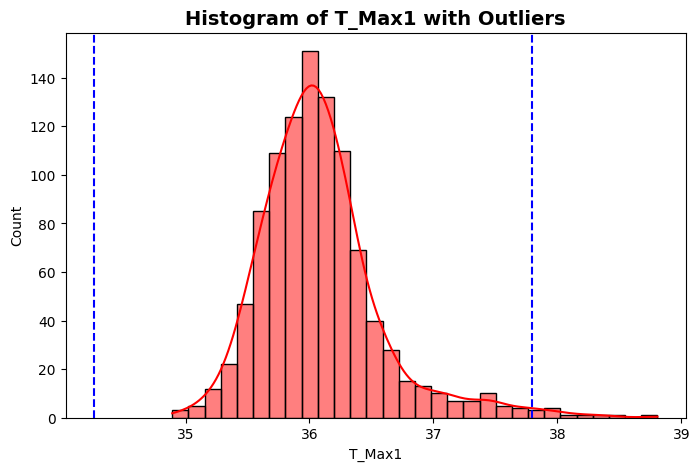

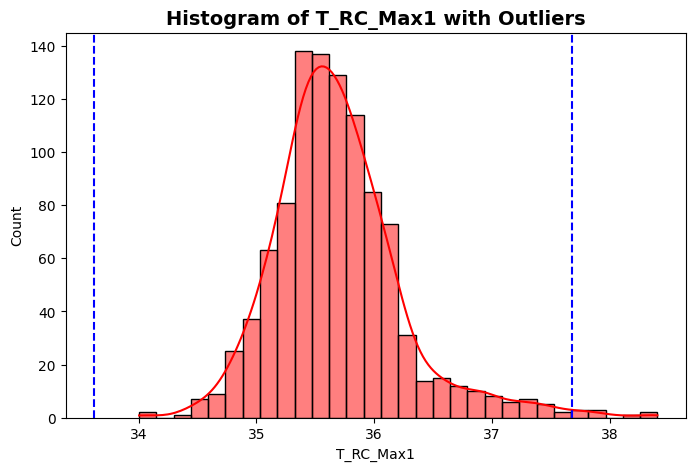

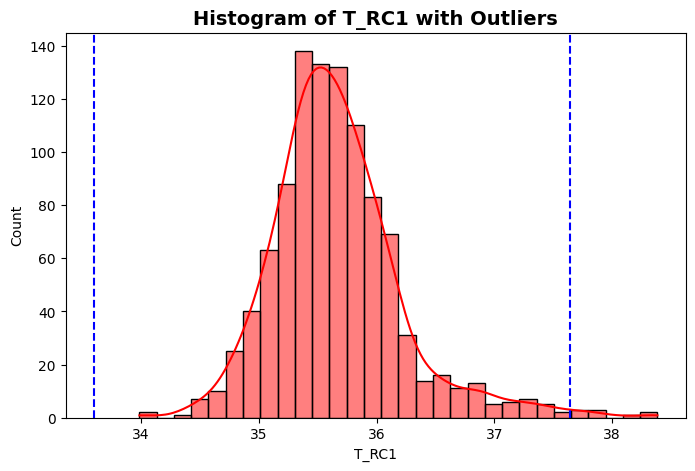

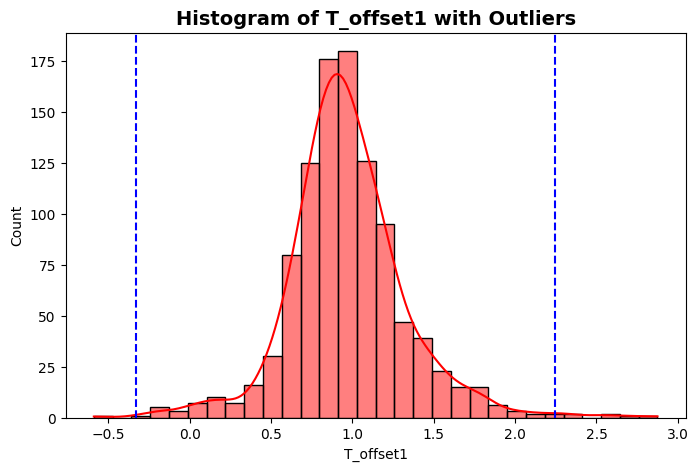

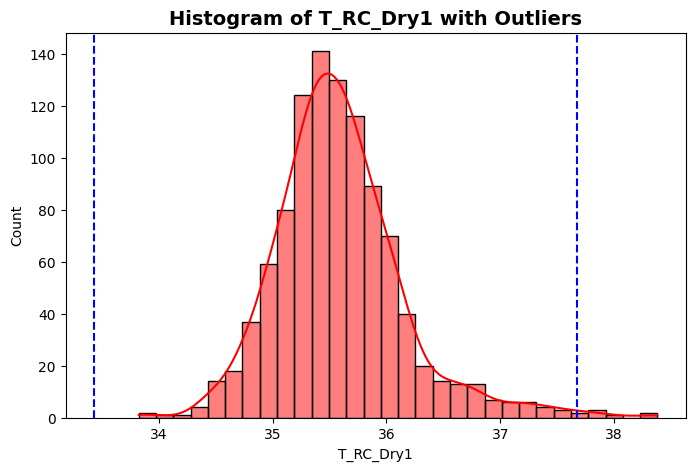

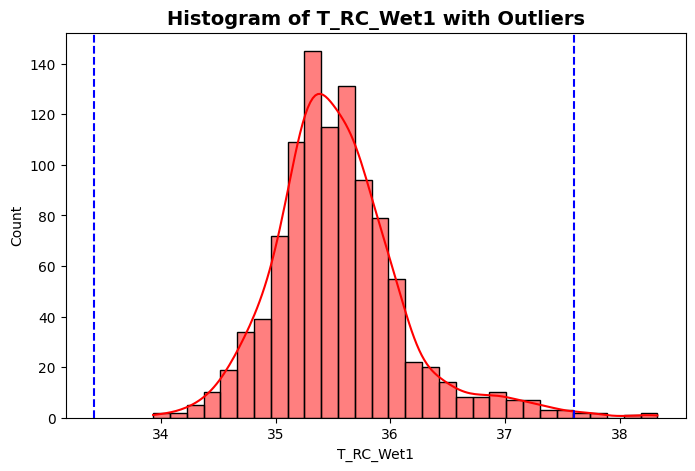

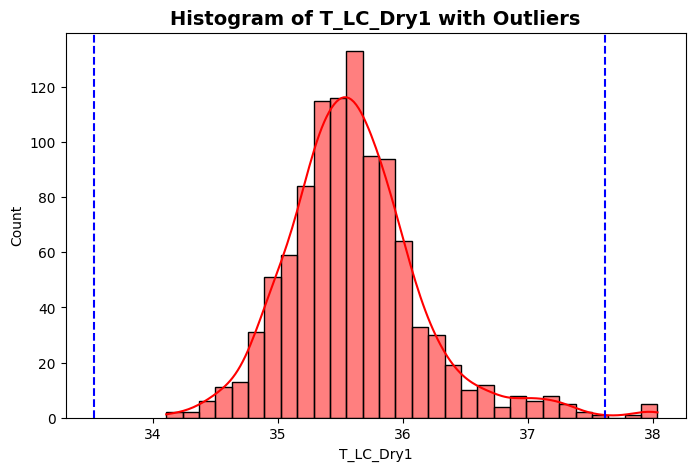

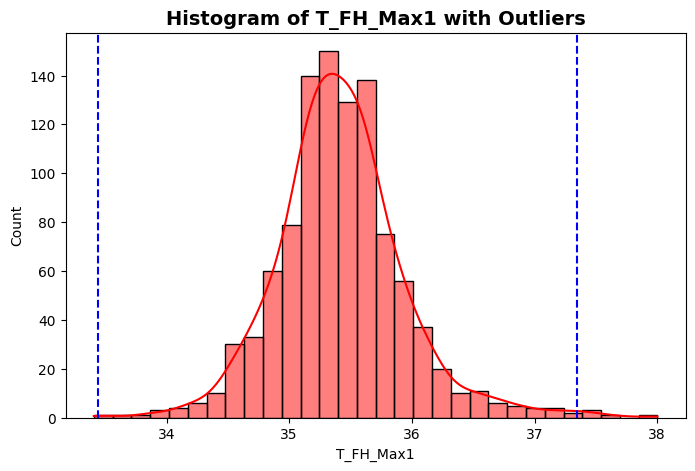

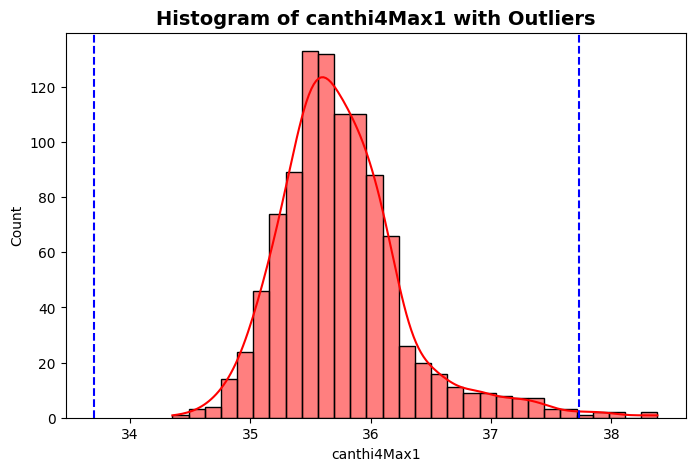

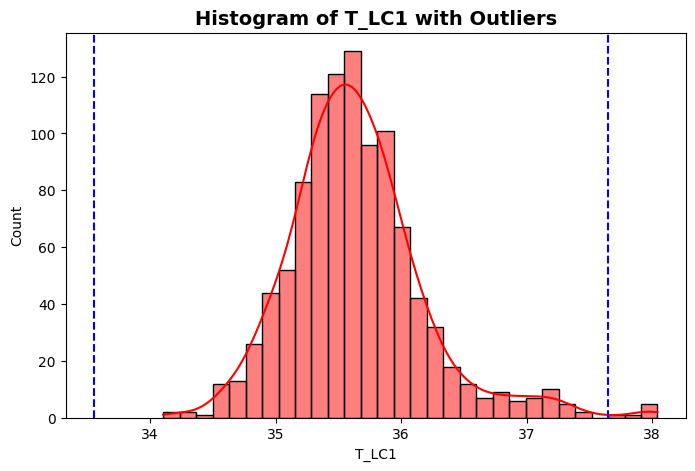

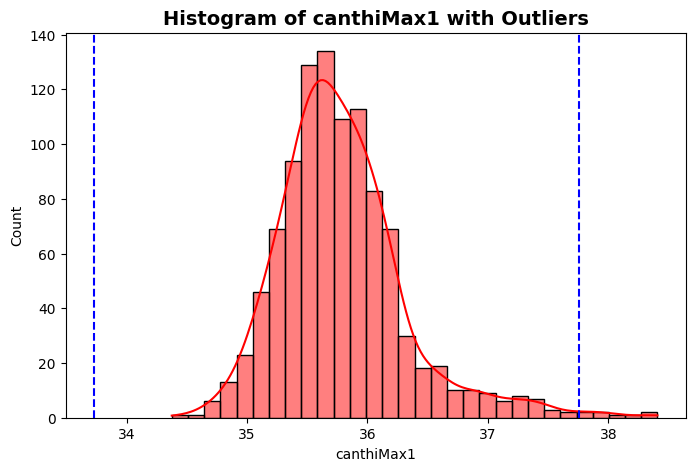

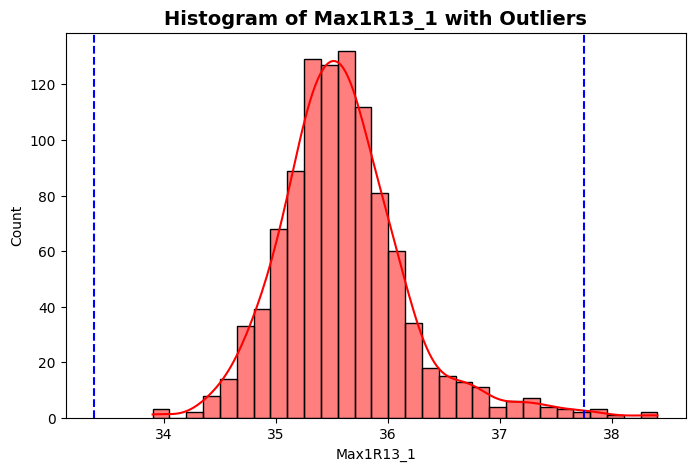

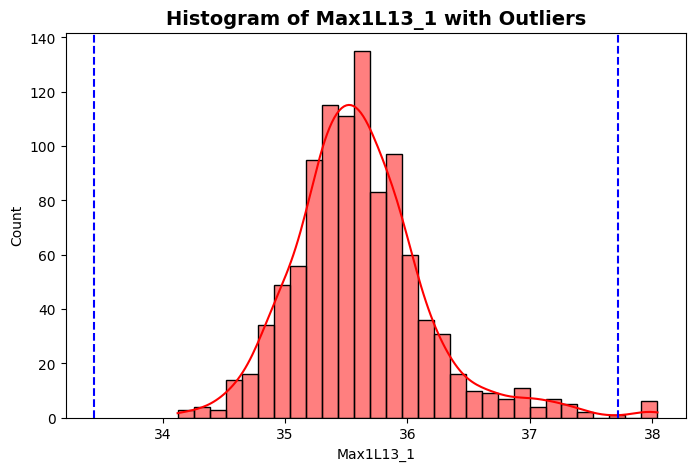

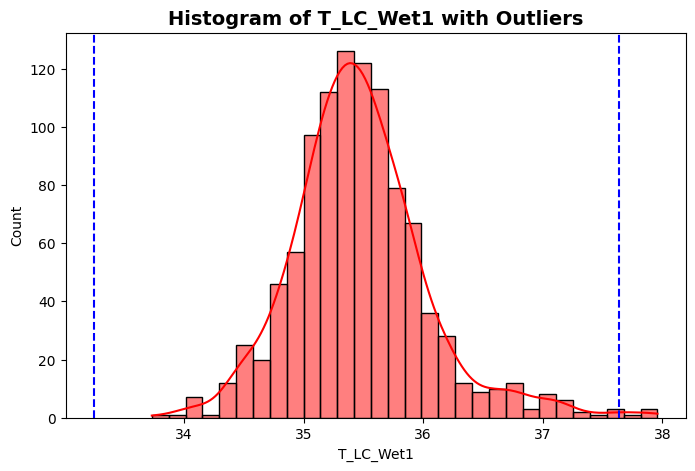

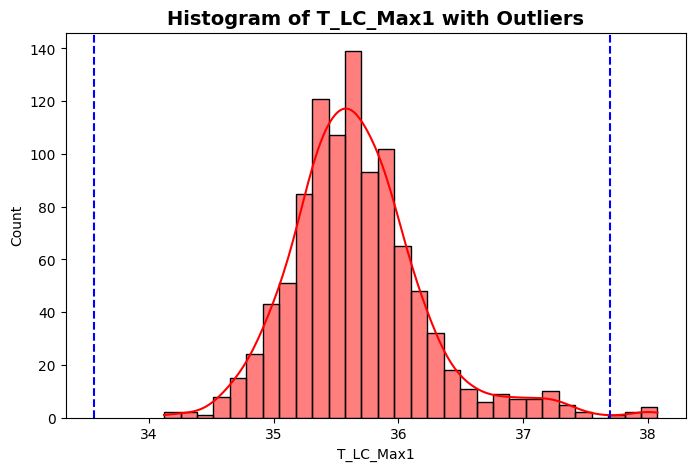

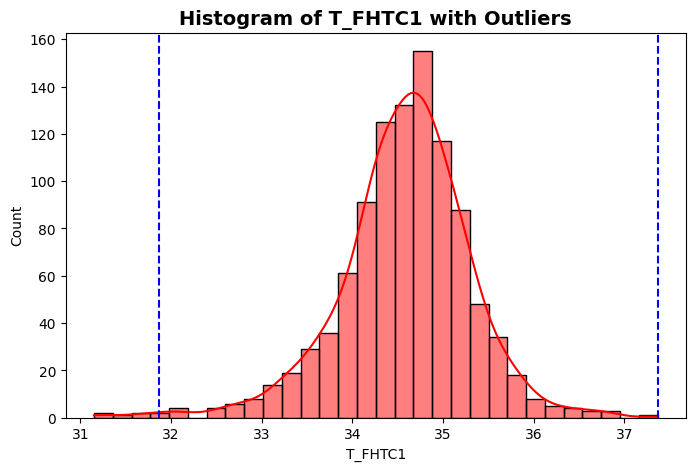

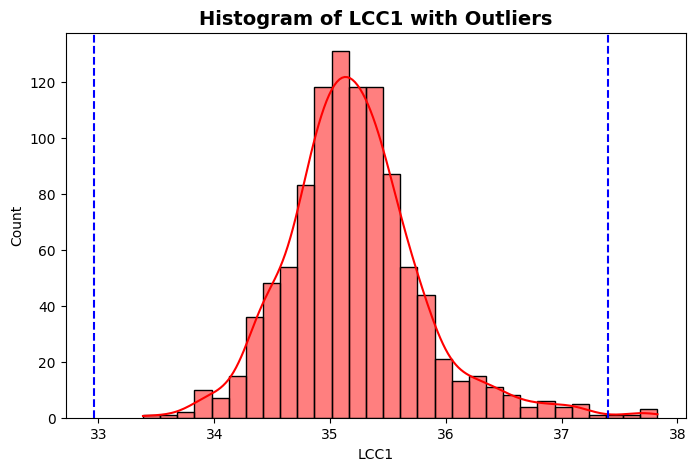

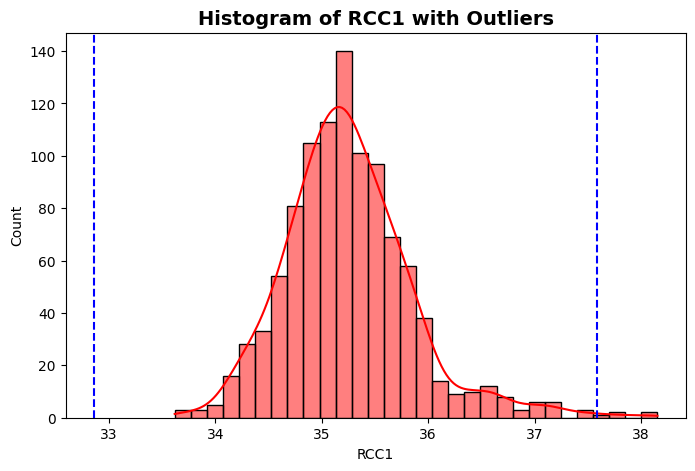

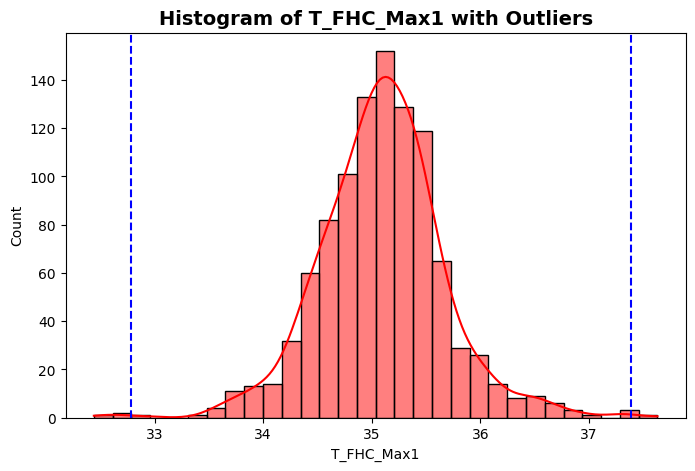

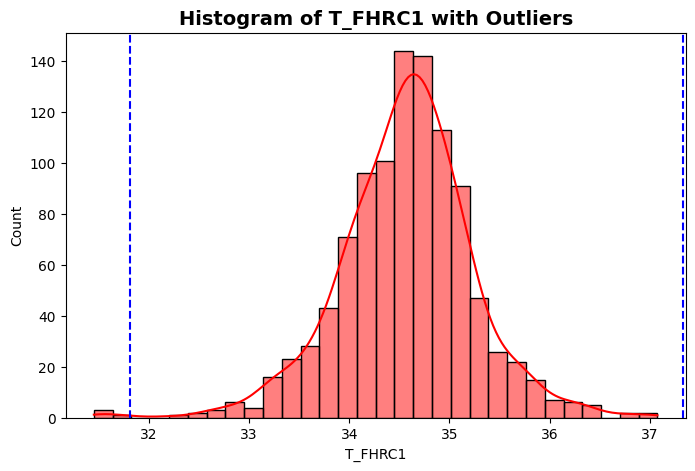

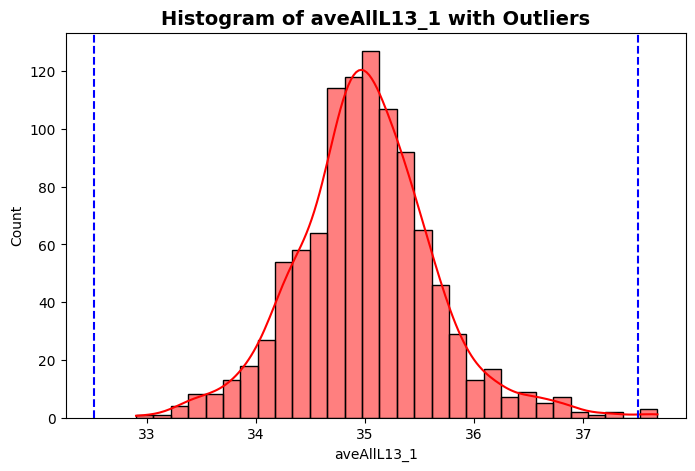

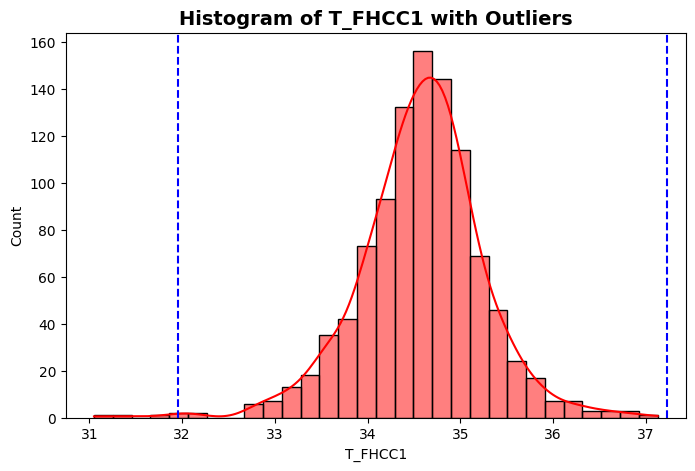

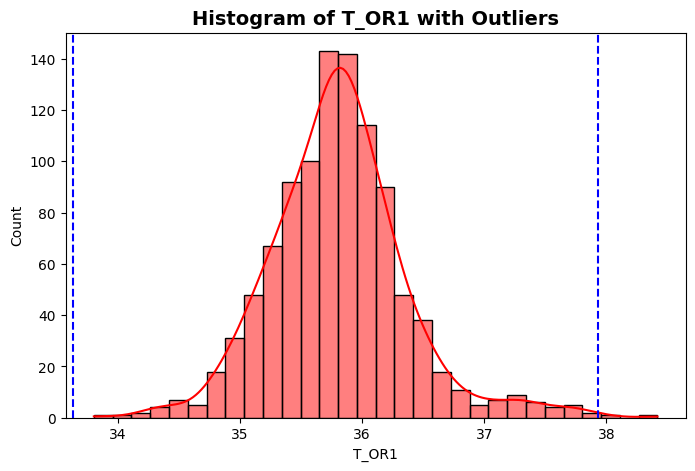

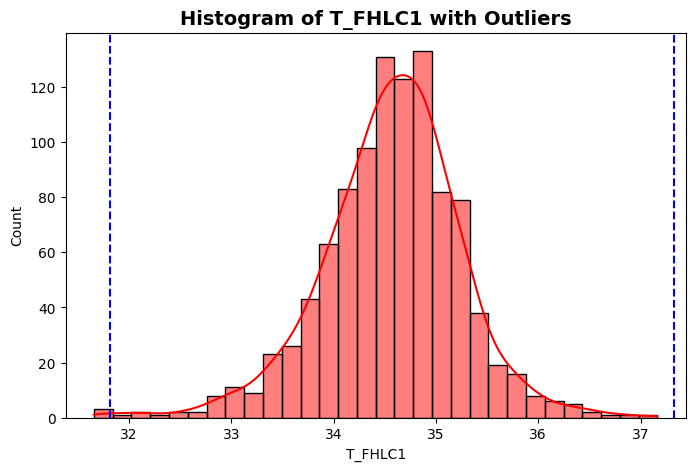

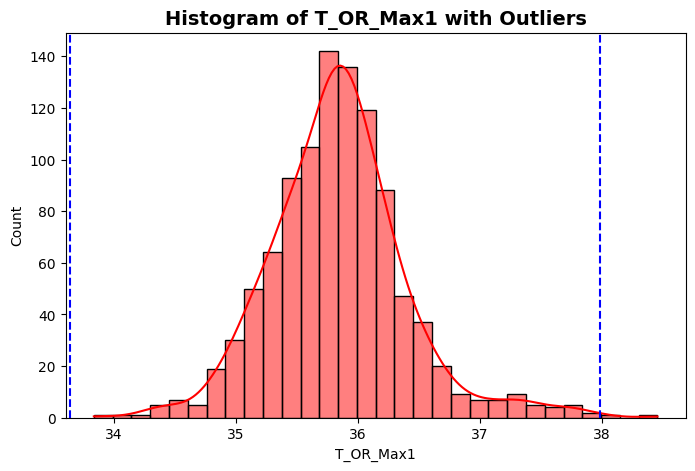

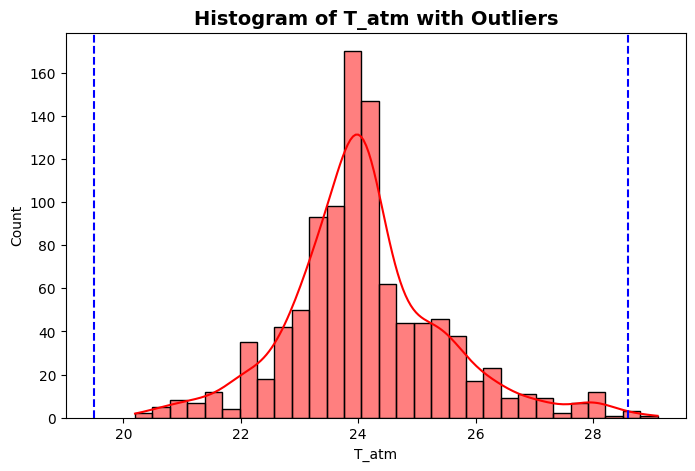

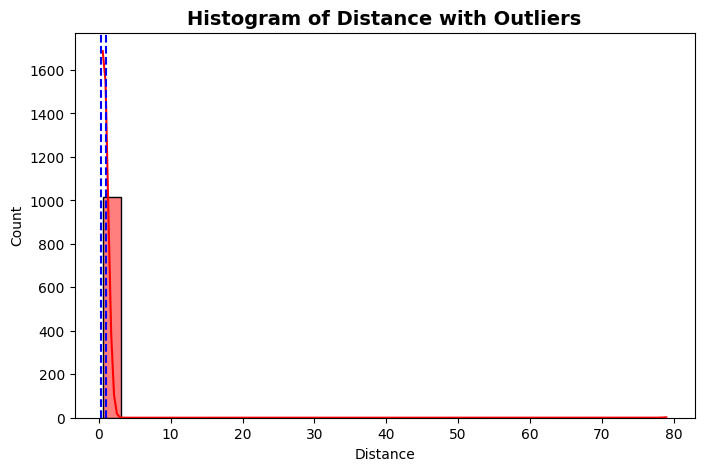

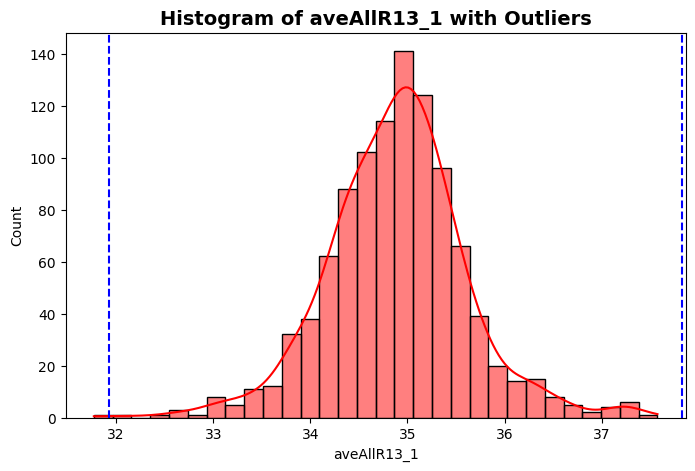

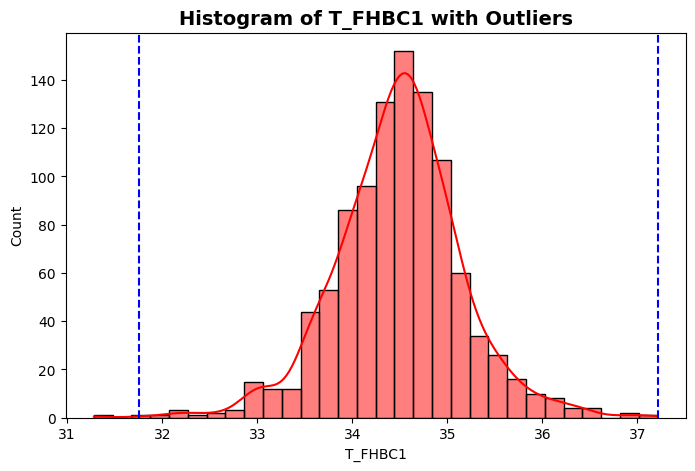

In [8]:
outliers = detect_outliers(X, 3)  # Detect outliers in features


Outlier detection was based on the interquartile range (IQR), where any value falling outside the range $[Q1 - k \cdot \text{IQR},\ Q3 + k \cdot \text{IQR}]$ was flagged as an outlier. Here, $k$ was set to 3, making the method stricter than the common (1.5 x IQR) rule.

Several temperature features showed mild outlier presence (e.g., T_Max1, T_RC_Max1, T_offset1), though percentages remained low overall (mostly under 1%). Looking at the ditribution of the variables, none of the outliers looked too concerning except distance.

\n Outlier Detection Summary:
             Outlier Count  Outlier Percentage (%)
Distance                 1                0.098039
T_atm                    0                0.000000
Humidity                 0                0.000000
T_offset1                0                0.000000
Max1R13_1                0                0.000000
Max1L13_1                0                0.000000
aveAllR13_1              0                0.000000
aveAllL13_1              0                0.000000
T_RC1                    0                0.000000
T_RC_Dry1                0                0.000000
T_RC_Wet1                0                0.000000
T_RC_Max1                0                0.000000
T_LC1                    0                0.000000
T_LC_Dry1                0                0.000000
T_LC_Wet1                0                0.000000
T_LC_Max1                0                0.000000
RCC1                     0                0.000000
LCC1                     0                0.000000
c

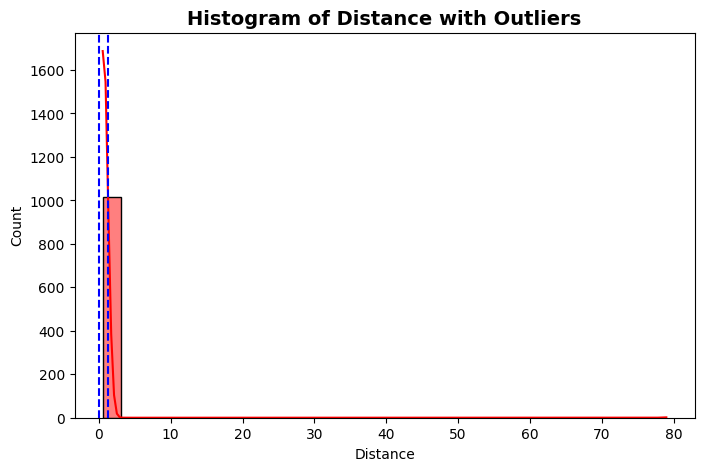

In [9]:
outliers = detect_outliers(X, 6)  # Detect Extreme outliers in features


When the threshold was increased to (6 × IQR), all outlier flags disappeared except for the extreme value previously identified in the Distance feature. This value was retained as a clear outlier and was removed, given its magnitude was far beyond the rest of the distribution and likely to distort model training.

In [51]:
X = X[X["Distance"] <= 10]  # Remove outliers from X
y = y.loc[X.index]  # Keep only corresponding values in y


#### Predictor Correlation

<Axes: >

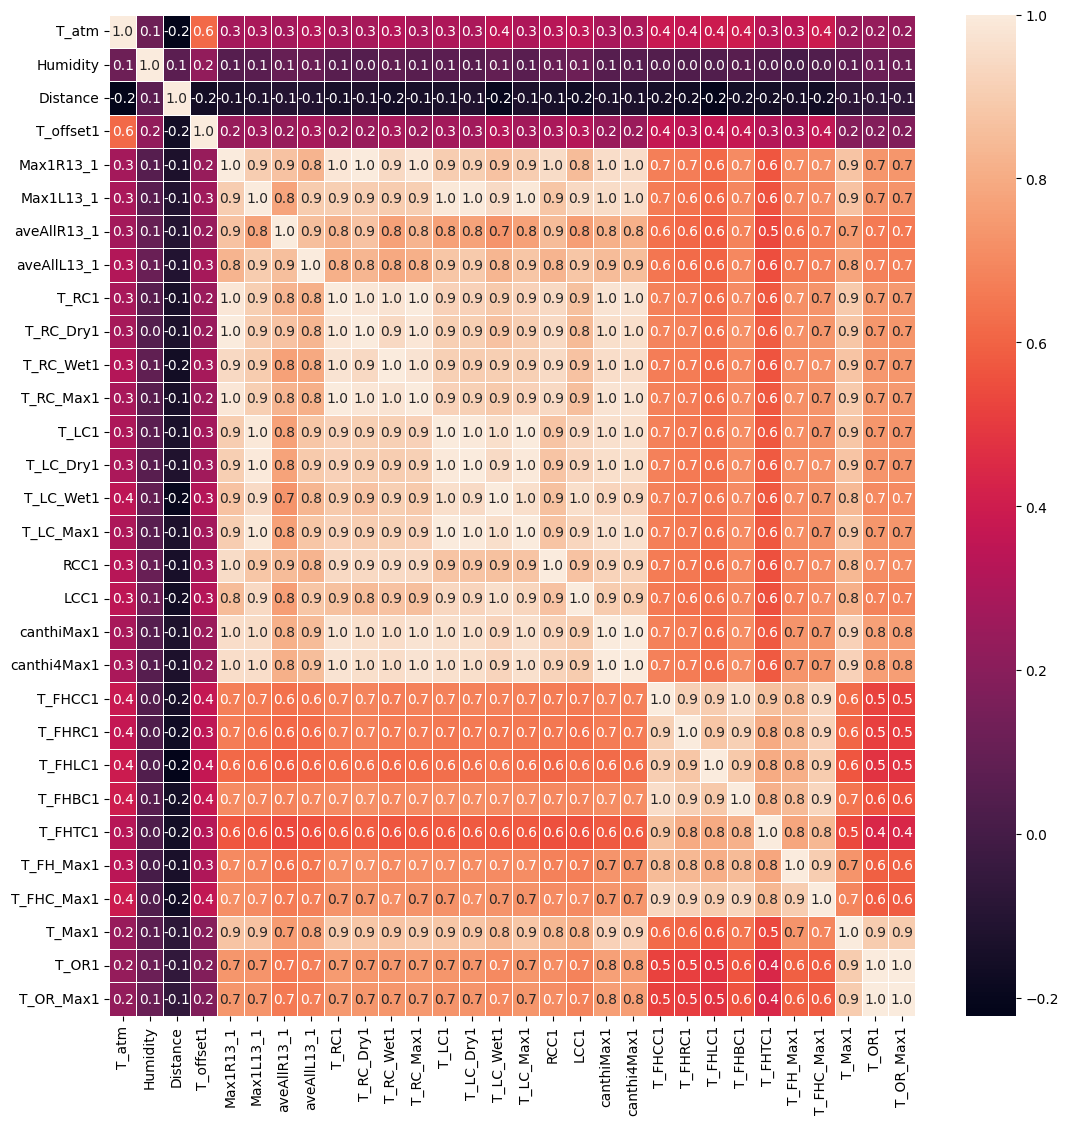

In [11]:
num_x = X.select_dtypes(exclude=['object', 'category'])
f,ax = plt.subplots(figsize=(13, 13))
sns.heatmap(num_x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Removed Variables: ['Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1']


<Axes: >

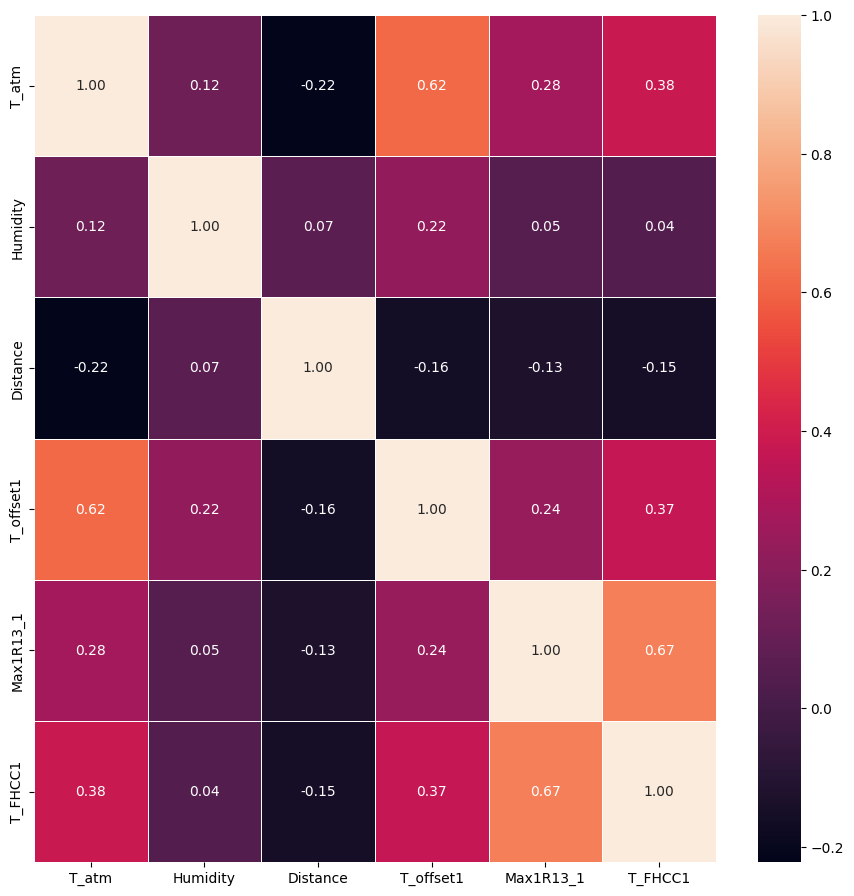

In [12]:
corr_matrix = num_x .corr().abs()  # Get absolute value of correlations
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle matrix of correlations

# Find features with correlation above the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
# Drop the selected features
x_reduced = num_x.drop(columns=to_drop)

print("Removed Variables:", to_drop)

f,ax = plt.subplots(figsize=(11, 11))
sns.heatmap(x_reduced.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

After removing variables with pairwise correlations above 0.8, the reduced set of features was used specifically for logistic regression, as it is sensitive to multicollinearity. For the other machine learning models, the full set of features was retained, since algorithms like decision trees, random forests, and boosting methods are not impacted in the same way by highly correlated predictors.

In [13]:
X_REDUCED = pd.concat([x_reduced, X.select_dtypes(include=['object', 'category'])], axis=1)
X_REDUCED

T_atm  Humidity  Distance  T_offset1  Max1R13_1  T_FHCC1  Gender    Age  \
0      24.0      28.0       0.8     0.7025    35.0300  33.5775    Male  41-50   
1      24.0      26.0       0.8     0.7800    34.5500  34.0325  Female  31-40   
2      24.0      26.0       0.8     0.8625    35.6525  34.9000  Female  21-30   
3      24.0      27.0       0.8     0.9300    35.2225  34.4400  Female  21-30   
4      24.0      27.0       0.8     0.8950    35.5450  35.0900    Male  18-20   
...     ...       ...       ...        ...        ...      ...     ...    ...   
1015   25.7      50.8       0.6     1.2225    35.6425  35.1075  Female  21-25   
1016   25.7      50.8       0.6     1.4675    35.9825  35.3100  Female  21-25   
1017   28.0      24.3       0.6     0.1300    36.4075  35.4350  Female  18-20   
1018   25.0      39.8       0.6     1.2450    35.8150  34.8400    Male  26-30   
1019   23.8      45.6       0.6     0.8675    35.7075  34.5475  Female  18-20   

                      Ethnicity  
0                         White  
1     Black or African-American  
2                         White  
3     Black or African-American  
4                         White  
...                         ...  
1015                      Asian  
1016                      White  
1017  Black or African-American  
1018            Hispanic/Latino  
1019                      White  

[1017 rows x 9 columns]

## 1.3 Outcome Variables

In [14]:
y

aveOralF  aveOralM
0        36.85     36.59
1        37.00     37.19
2        37.20     37.34
3        36.85     37.09
4        36.80     37.04
...        ...       ...
1015     36.95     36.99
1016     37.25     37.19
1017     37.35     37.59
1018     37.15     37.29
1019     37.05     37.19

[1017 rows x 2 columns]

In [15]:
y.describe().T

count       mean       std    min    25%    50%    75%    max
aveOralF  1017.0  36.978614  0.386685  35.75  36.80  36.90  37.10  39.60
aveOralM  1017.0  37.027955  0.509950  35.54  36.74  36.94  37.14  40.34

Both regression targets, aveOralF and aveOralM, are centered around typical body temperature (~37°C) with relatively low standard deviations, suggesting stable measurements. However, aveOralM shows a slightly wider spread and higher maximum value, indicating occasional elevated readings likely corresponding to fever cases.

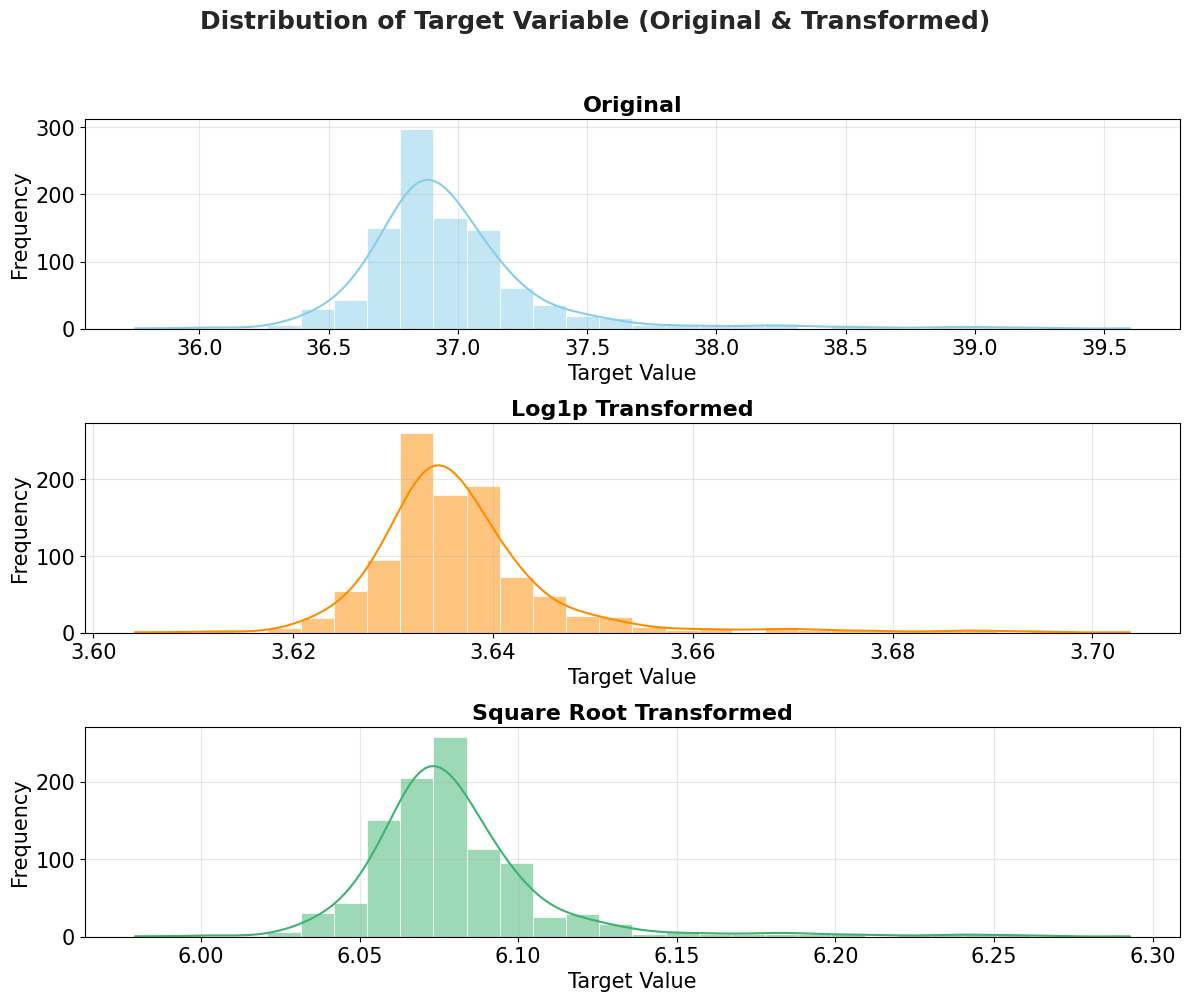

In [16]:
compare_target_transformations(y["aveOralF"])

**Monitor mode**

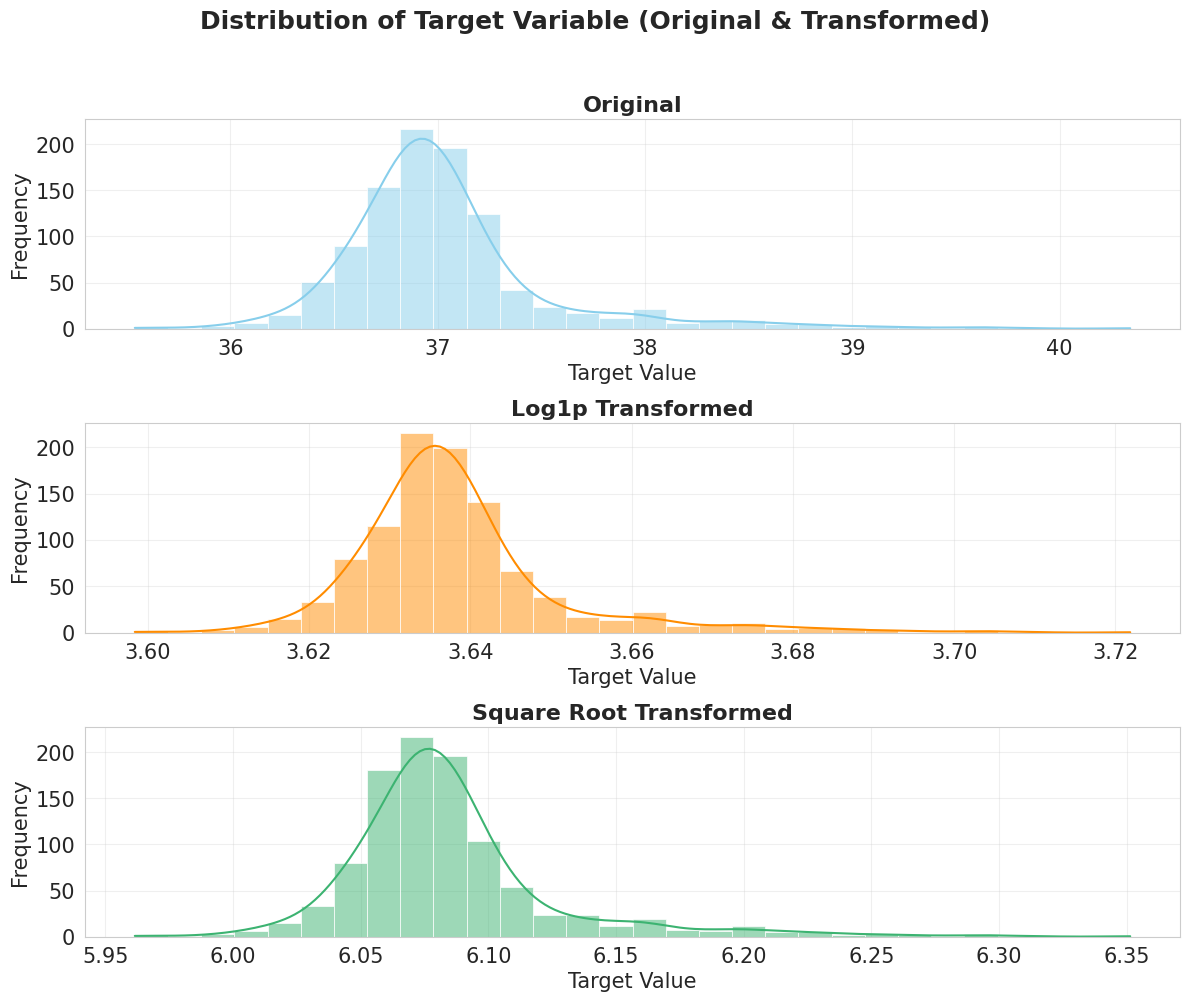

In [17]:
compare_target_transformations(y["aveOralM"])

The original target variable was compared against log and square root transformations to evaluate potential improvements in distribution. All three versions appeared approximately normally distributed with minimal variation, so the untransformed values were retained for the regression task.

In [18]:
# Convert 'aveOralF' and 'aveOralM' into binary fever classification (Yes/No)
y.loc[:, "OralF_Fever"] = y["aveOralF"].apply(lambda x: "Yes" if x >= 37.5 else "No")
y.loc[:, "OralM_Fever"] = y["aveOralM"].apply(lambda x: "Yes" if x >= 37.5 else "No")


#### Imbalanced classification

**Fast mode**

Oral temperature ≥ 37.5°C (FEVER)

Number of No: 952 ||| Proportion: 93.6%
Number of Yes: 65 ||| Proportion: 6.4%


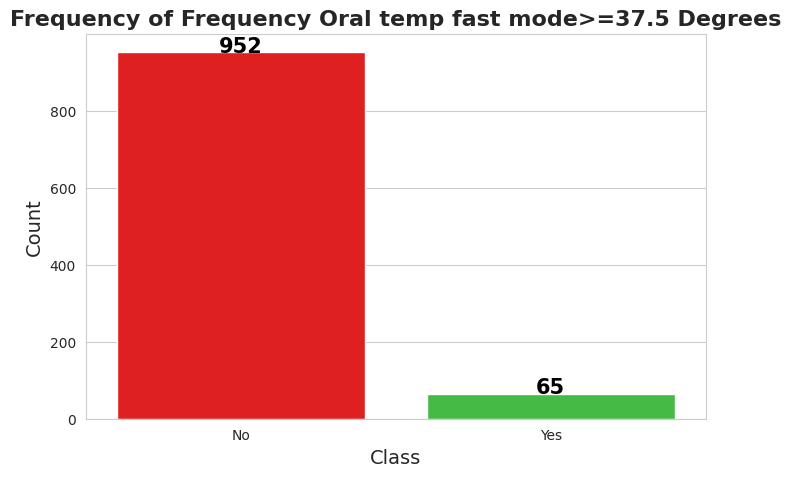

In [19]:
class_distribution(y["OralF_Fever"], target_name="Frequency Oral temp fast mode ≥ 37.5°C")

The distribution of fever cases in Fast Mode (OralF_Fever) reveals a severe class imbalance, with only 65 instances (≈6.4%) classified as febrile (Yes) compared to 952 non-febrile (No) cases. This imbalance makes classification more of a challenge, as they may default to predicting the majority class to optimize accuracy, leading to poor recall for the minority (fever) class. As a result, model evaluation will prioritise metrics like F1-score, recall, and precision, rather than relying solely on accuracy.

**Monitor mode**

Oral temperature ≥ 37.5°C (FEVER)

Number of No: 906 ||| Proportion: 89.1%
Number of Yes: 111 ||| Proportion: 10.9%


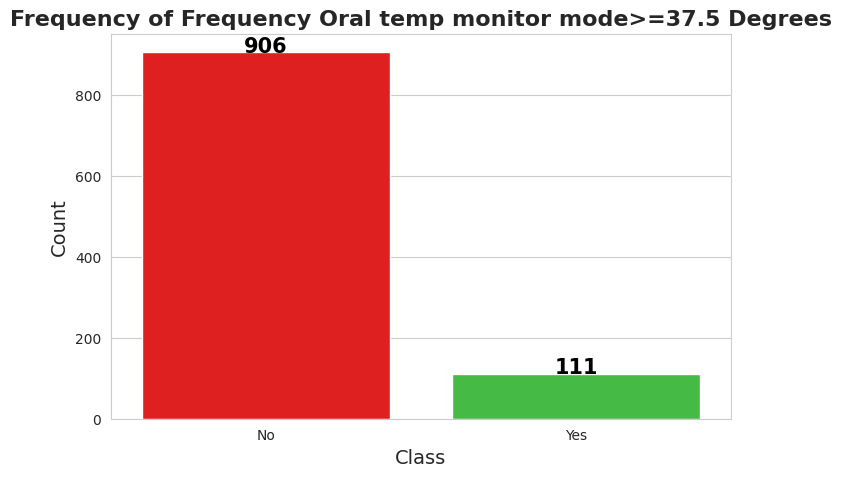

In [20]:
class_distribution(y["OralM_Fever"], target_name="Frequency Oral temp monitor mode>=37.5 Degrees")

The OralM_Fever distribution in Monitor Mode also displays class imbalance, though it is less severe than in Fast Mode. Out of 1017 samples, 111 instances (≈10.9%) are labelled as febrile (Yes), compared to 906 non-febrile (No) cases. While the imbalance is still substantial, the higher proportion of positive cases makes this classification task comparatively more learnable for most models. Nonetheless, evaluation will again focus on recall, precision, and F1-score to ensure that febrile cases are correctly identified.

In [21]:
y_full = y.copy()

# **2. METHODOLOGY**

This section presents a comparative evaluation of the classification and regression algorithms used in this project. The comparison focuses on three key areas: predictive performance, interpretability, and computational efficiency. The aim is to determine which algorithm is most appropriate for the dataset. To ensure the correct implementation and interpretation of each algorithm, I used a variety of sources, including:

* Lab discussions and guidance
* [Aurelien Geron - Hands-on machine learning with scikit-learn, keras, and tensorflow: concepts, tools, and techniques to build intelligent systems](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
* [Gareth James, Daniela Witten, Trevor Hastie - An Introduction to Statistical Learning](https://www.statlearning.com/)
* [Max Kuhn, Kjell Johnson - Applied Predictive Modeling](https://link.springer.com/book/10.1007/978-1-4614-6849-3)
* [Ewout W. Steyerberg - Clinical Prediction Models](https://link.springer.com/book/10.1007/978-3-030-16399-0)
* [Frank E. Harrell, Jr - Regression Modeling Strategies](https://link.springer.com/book/10.1007/978-3-319-19425-7)

___

### 2.1 Models
#### **i. Logistic Regression**  (Classification)
A simple, interpretable algorithm suitable for binary classification. It estimates the probability that a given input belongs to a particular class by applying a logistic (sigmoid) function to a linear combination of input features. The model outputs a probability $ P(y=1|X) $ using the following equation:
$$
P(y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n)}}
$$
where
$ \beta_0 $ is the intercept and
$ \beta_1, \beta_2, \dots \beta_n $ are the coefficients for each feature $ X_1, X_2, \dots, X_n $.
Logistic regression outputs values between 0 and 1, which represent the probability of each class.

---
#### **ii. Elastic Net** (Regression & Classification)

Elastic Net combines L1 (Lasso) and L2 (Ridge) regularization to improve model performance in the presence of multicollinearity or high-dimensional data. It is used in both regression and classification tasks by adding penalty terms to the loss function.

For **regression**:
$$
L_{\text{reg}} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \lambda_1 \sum_{j=1}^{n} |\beta_j| + \lambda_2 \sum_{j=1}^{n} \beta_j^2
$$

For **classification**:
$$
L_{\text{class}} = -\sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] + \lambda_1 \sum_{j=1}^{n} |\beta_j| + \lambda_2 \sum_{j=1}^{n} \beta_j^2
$$

  The mixing parameter $\alpha \in [0, 1]$ controls the balance between L1 and L2. Elastic Net is used in this project for both tasks to penalise the use of unnecessary parameters and reduce overfitting.
___
#### **iii. Linear Regression** (Regression)

Linear regression is a simple and interpretable algorithm used to model the relationship between a continuous target variable and one or more input features. It assumes a linear relationship of the form:

$$
\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
$$
  Model parameters ($\beta$ coefficients) are estimated by minimising the residual sum of squares:
$$
L = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$
  Linear regression is computationally efficient and performs well when the assumptions of linearity and independence are met as well as being a highly explainable model.  However, it can overfit in the presence of many correlated features or outliers. This model was included in the project because, if it achieves comparable performance to more complex models, it could be considered the best choice for model deployment due to its simplicity, interpretability, and ease of implementation.
___
#### **iv. Decision Tree** (Regression & Classification)

Decision Trees are intuitive models that recursively split the data based on feature thresholds to make predictions. They are highly interpretable and can capture non-linear relationships but are prone to overfitting without pruning or regularisation.

In **classification**, splits are chosen to maximise class separation using criteria like Gini impurity:

$$
G = 1 - \sum_{i=1}^{C} p_i^2
$$

where $G$ is the impurity, $C$ is the number of classes, and $p_i$ is the proportion of class $i$ samples in a node.

In **regression**, splits aim to minimise the variance within child nodes.

This model was used in the project for its interpretability and ability to reveal simple decision rules, which can be valuable even when its performance is slightly lower than more complex models.

___
#### **v. Random Forest** (Regression & Classification)

Random Forest is an ensemble method that builds multiple decision trees using bootstrapped datasets and random feature selection. It reduces overfitting and improves predictive performance by aggregating the outputs of many diverse trees.

- **Bootstrap Sampling**: Each tree is trained on a randomly sampled subset of the data (with replacement).
- **Random Feature Splits**: At each node, a random subset of features is considered for splitting, reducing correlation between trees.
- **Unpruned Trees**: Each tree is typically grown to full depth, capturing complex patterns in the data.
- **Prediction**:
  - **Classification**: Final prediction is made by majority vote:
    $$
    \hat{y} = \text{mode}(\hat{y}_1, \hat{y}_2, \dots, \hat{y}_M)
    $$
  - **Regression**: Final prediction is the average of all tree outputs.

Random Forest was used for its strong performance and ability to handle both classification and regression tasks effectively.
___
#### **vi. K-Nearest Neighbors** (Regression & Classification)

K-Nearest Neighbors (KNN) is a non-parametric, instance-based learning algorithm that makes predictions based on the $k$ closest training samples in the feature space.

- **Choose $k$**: Select the number of neighbors to consider.
- **Compute Distance**: Use Euclidean distance to measure similarity:

$$
d(x, x_i) = sqrt({\sum_{j=1}^{n} (x_j - x_{i,j})^2})
$$


- **Find Neighbors**: Identify the $k$ nearest training points.
- **Make Prediction**:
  - **Classification**: Predict the majority class among neighbors:
    
  $$
  \hat{y} = \text{argmax}_{c} \sum_{i=1}^{k} \mathbf{1}(y_i = c)
  $$
  - **Regression**: Predict the average of neighbors' values.

KNN was included for its simplicity and effectiveness.
___

#### **vii. XGBoost (Regression & Classification)**

XGBoost is a high-performing ensemble method based on gradient boosting that builds additive decision trees to minimise a regularised loss function. It was used for both regression and classification due to its ability to capture complex patterns and consistently strong predictive performance.

For classification, XGBoost minimises the following regularised objective:

$$
L = \sum_{i=1}^{n} \ell(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^{t} \Omega(f_k)
$$

where $\ell$ is the classification loss (logistic), and $ \Omega(f_k)$ is a regularisation term penalising model complexity. In this project, PR AUC (Area Under the Precision-Recall Curve) was used as the evaluation metric, which is more appropriate than accuracy or ROC AUC when dealing with imbalanced classes.

For regression, XGBoost used a squared error loss:

$$
L = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \sum_{k=1}^{t} \Omega(f_k)
$$

XGBoost was included for its strong performances and ability to handle noise and multicollinearity.

Each algorithm has strengths and potential limitations for this dataset, so a comparative analysis can help identify the best model based on F1-Score (Classification), RMSE (Regression), interpretability, and computational efficiency.
___

## 2.2 Classification Metrics
$TP$, $TN$, $FP$, $FN$: confusion matrix components

- **Accuracy**  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision**  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensitivity)**
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1 Score**  
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **ROC Curve (Receiver Operating Characteristic)**  
  Plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold values:  
  $$
  \text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
  $$
  A perfect classifier reaches the top-left corner. This project also used the **"top-left method"** to select the optimal classification threshold — the point on the ROC curve closest to (0, 1).

- **AUC (Area Under the ROC Curve)**  
  Represents the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative one. AUC = 0.5 indicates random guessing, while AUC = 1.0 is perfect classification.

- **Precision-Recall Tradeoff Curve**  
 Plots precision against recall at various thresholds to visualise the trade-off.

 In this context, a true positive (TP) refers to correctly identifying a person who does have a fever. Therefore, recall becomes particularly important, as it measures the model's ability to correctly detect febrile individuals. Missing true cases (low recall) could be risky in any screening application, making high recall a priority metric.

---



## 2.3 Regression Metrics

- **Mean Absolute Error (MAE)**  
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$

- **Root Mean Squared Error (RMSE)**  
  $$
  \text{RMSE} = sqrt({ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 })
  $$

- **R-squared (\( R^2 \))**  
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
  $$

Where:  
- $y_i$: actual value  
- $\hat{y}_i$: predicted value  
- $\bar{y}$: mean of actual values  

---



## 2.4 Monte Carlo Cross-Validation (MC CV)

Monte Carlo Cross-Validation is a resampling method used to assess model performance. Unlike k-fold cross-validation, which partitions the dataset into fixed folds, MC CV repeatedly splits the dataset into random train-test splits, allowing greater flexibility and a better estimate of performance variability. In this project, multiple hyperparameter grids were tested using a smaller number of Monte Carlo repetitions ($M = 20$) to identify the best-performing ones. Once optimal grids were found, the number of repetitions was increased to $M = 200$ to obtain more reliable performance estimates while keeping the overall computation time manageable.

The pipeline followed in each MC CV iteration is illustrated in the figure below and consists of the following steps (Steps 1-7 repeated 200 times with a random shuffle before each itration):

1. **Train-Test Split**: The dataset is randomly split into training (80%) and testing sets (20%) using stratified sampling to preserve the class distribution in classification tasks.
2. **Numerical Imputation**: Missing values are imputed using K-Nearest Neighbors (KNN) imputation to preserve data relationships.
3. **One-Hot Encoding**: Categorical features are one-hot encoded to convert them into numeric format suitable for machine learning models.
4. **Feature Scaling**: Features are standardised using z-score normalisation to ensure all inputs are on the same scale.
5. **Hyperparameter Tuning**: A grid search is used to identify the best hyperparameters for each model within each iteration, based on validation F1-score.
6. **Train & Evaluate Models**: Each model is trained on the training set and evaluated on the test set.
7. **Compute Classification/Regression Metrics**: Metrics including Accuracy, Precision, Recall, F1-score, and AUC are calculated on the test set. The mean and standard deviation across all $M$ runs are reported.
8. **Generate Performance Graphs**: mean ROC curves with 95%CI (using the top-left method), mean Precision-Recall Tradeoff plots with 95% CI, and mean confusion matrix are generated for visual comparison of models.

**MC CV Aggregation Formulas**

For **regression tasks**, model performance is evaluated by computing the average RMSE over the $M$ test sets:

$$
MC\text{-}CV_{\text{test}} = \frac{1}{M} \sum_{m=1}^{M} RMSE_{m,\text{test}}
$$

For **classification tasks**, the same principle is applied to each evaluation metric:

- **Accuracy**:
$$
MC\text{-}CV_{\text{test}} = \frac{1}{M} \sum_{m=1}^{M} \text{Accuracy}_{m,\text{test}}
$$

- **Precision, Recall, F1-score**:
$$
MC\text{-}CV_{\text{test}} = \frac{1}{M} \sum_{m=1}^{M} \text{Metric}_{m,\text{test}}
$$
Where $\text{Metric}$ refers to either Precision, Recall, or F1-score.

This approach stable performance estimation by accounting for variance across multiple random train-test splits. In this project, F1-score was used to tune hyperparameters due to class imbalance. Below is a diagram illustrating the Monte Carlo Cross-Validation process implemented in the function. If the model has hyperparameters, the function automatically performs nested cross-validation to optimize them efficiently.

<img src="https://drive.google.com/uc?export=view&id=1Km58lTSUR4PVS4bWMZtq1ezeczqXyqQz" alt="Monte Carlo CV Pipeline" width="600">


# **3. CLASSIFICATION**

In [35]:
y = y_full["OralF_Fever"]
y2 = y_full["OralM_Fever"]

'Yes' (Fever) is encoded as 1, 'No' (No Fever) as 0


In [36]:
def encode_binary_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "Yes" in unique_labels and "No" in unique_labels:
            print("🔁 Converting 'Yes' to 1 and 'No' to 0...")
            return pd.Series(y).replace({"Yes": 1, "No": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels are already correctly encoded (0=No Fever, 1=Fever).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")


In [ ]:
y = encode_binary_labels(y)
y2 = encode_binary_labels(y2)


🔁 Converting 'Yes' to 1 and 'No' to 0...
🔁 Converting 'Yes' to 1 and 'No' to 0...


In [ ]:
df = pd.concat([X, y], axis=1)
df2 = pd.concat([X, y2], axis=1)

## 3.1 Baseline Accuracy

In [ ]:
# Most frequent class
most_common = y.value_counts().idxmax()
most_common2 = y2.value_counts().idxmax()

# Baseline accuracy: how often you'd be right if you always guessed that class
baseline_accuracy = (y == most_common).mean()
baseline_accuracy2 = (y2 == most_common2).mean()

print(f"Fast Mode Baseline accuracy (always predicting 'No Fever'):    {baseline_accuracy:.3f}")
print(f"Monitor Mode Baseline accuracy (always predicting 'No Fever'): {baseline_accuracy2:.3f}")


Fast Mode Baseline accuracy (always predicting 'No Fever'):    0.936
Monitor Mode Baseline accuracy (always predicting 'No Fever'): 0.891


Extremely high starting accuracys due to class imbalance. This means, other metrics like precision, recall and F1 score will be a better metric to improve our model's on.  

## 3.2 Monte Carlo Cross-Validation Function

Function for monte carlo cross-validation. See more in methodology for explanation.

In [ ]:
# Categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Numerical columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

model_results = {}       # Store trained models & results
monte_carlo_results = {} # Stores all iteration results for each model
confusion_matrices = {}  # Stores confusion matrices for each iteration

feature_importance_dict = defaultdict(list)
pr_curves = defaultdict(list)
roc_curves = defaultdict(list)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters


def monte_carlo_cv_with_plot(model, param_grid, X, y, model_name, num_iterations=100, test_size=0.2, n_neighbors=5, cv_folds=5, track_feature_importance=True):
    scaler = StandardScaler()
    results = []
    best_models = []
    validation_results = {}

    best_overall_model = None
    best_f1_score = 0
    cm_sum = np.zeros((2, 2))

    all_pr_curves = []
    best_thresholds = []
    roc_distances = []

    for i in range(num_iterations):
        print(f"\n🔄 Monte Carlo Iteration {i+1}/{num_iterations}...")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=i)

        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        X_train[num_cols] = knn_imputer.fit_transform(X_train[num_cols])
        X_test[num_cols] = knn_imputer.transform(X_test[num_cols])

        preprocessor = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ])

        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        feature_names = preprocessor.get_feature_names_out()
        X_train = pd.DataFrame(X_train_processed, columns=feature_names)
        X_test = pd.DataFrame(X_test_processed, columns=feature_names)

        if param_grid and len(param_grid) >= 1:
            param_name = list(param_grid.keys())[0]
            print(f"\n🔍 Hyperparameter tuning for {param_grid} (Optimizing F1-Score)...")
            grid_search = GridSearchCV(model, param_grid, cv=cv_folds, scoring="f1", n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = frozenset(grid_search.best_params_.items())
            best_hyperparams_counter[best_params] += 1

            print(f"✅ Best Parameters: {grid_search.best_params_}")
            print(f"✅ Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

            validation_results = {
                "Model": model,
                "Hyperparameters": grid_search.cv_results_["params"],
                "Validation F1-Score": grid_search.cv_results_["mean_test_score"],
                "Training F1-Score": grid_search.cv_results_["mean_train_score"]
            }
        else:
            print(f"\n🚀 Training {model.__class__.__name__} with Monte Carlo CV (No Hyperparameter)...")
            model.fit(X_train, y_train)
            best_model = model

        best_models.append(best_model)

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        f1 = f1_score(y_test, y_pred, pos_label=1)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)

        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        cm_sum += cm

        if f1 > best_f1_score:
            best_f1_score = f1
            best_overall_model = best_model
            best_y_test = y_test
            best_y_probs = y_prob
            best_y_pred = y_pred

        results.append({
            "Iteration": i+1,
            "Accuracy": accuracy, "AUC": auc, "Precision": precision,
            "Recall": recall, "F1-Score": f1
        })

        if y_prob is not None:
            precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
            f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-6)
            best_threshold = thresholds[np.argmax(f1_scores)]
            best_thresholds.append(best_threshold)
            all_pr_curves.append((precisions, recalls, thresholds))

            if track_feature_importance:
                if hasattr(best_model, "coef_"):
                    feature_importance_dict[model_name].append(best_model.coef_[0])
                elif hasattr(best_model, "feature_importances_"):
                    feature_importance_dict[model_name].append(best_model.feature_importances_)

            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_curves[model_name].append((fpr, tpr, thresholds))
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            roc_distances.append((thresholds[np.argmin(distances)], fpr[np.argmin(distances)], tpr[np.argmin(distances)]))

    monte_carlo_results[model_name] = pd.DataFrame(results)

    results_df = pd.DataFrame(results).drop(columns=["Iteration"])
    mean_metrics = results_df.mean()
    std_metrics = results_df.std()

    final_results = pd.DataFrame({
        "Mean Accuracy": mean_metrics["Accuracy"], "Std Accuracy": std_metrics["Accuracy"],
        "Mean AUC": mean_metrics["AUC"], "Std AUC": std_metrics["AUC"],
        "Mean Precision": mean_metrics["Precision"], "Std Precision": std_metrics["Precision"],
        "Mean Recall": mean_metrics["Recall"], "Std Recall": std_metrics["Recall"],
        "Mean F1": mean_metrics["F1-Score"], "Std F1": std_metrics["F1-Score"]
    }, index=["Results"])

    print("\n📊 Monte Carlo CV Results")
    display(round(final_results, 3))

    if best_hyperparams_counter:
        print("\n🏆 Most Common Best Hyperparameters:")
        sorted_params = Counter(best_hyperparams_counter).most_common()
        for i, (params, count) in enumerate(sorted_params, 1):
            print(f"{i}. Params: {dict(params)} | Chosen: {count} out of {num_iterations} times")
    best_hyperparams_counter.clear()

    mean_cm = cm_sum / num_iterations
    confusion_matrices[model_name] = mean_cm

    model_results[model_name] = {
        "model": best_overall_model,
        "y_test": best_y_test,
        "y_probs": best_y_probs,
        "y_pred": best_y_pred
    }

    plot_precision_recall_tradeoff_with_ci(all_pr_curves, best_thresholds, model_name)
    plot_avg_roc_with_ci(model_name, roc_distances)
    #plot_calibration_curve(model_name)
    plot_mean_confusion_matrix(model_name)

    if param_grid and len(param_grid) == 1:
        plot_validation_trends(validation_results)

    return final_results, best_overall_model


def plot_avg_roc_with_ci(model_name, roc_distances, force_origin=True):
    curves = roc_curves[model_name]
    all_interp = []
    fpr_grid = np.linspace(0, 1, 100)
    for fpr, tpr, _ in curves:
        interp = np.interp(fpr_grid, fpr, tpr, left=0, right=1)
        all_interp.append(interp)

    all_interp = np.array(all_interp)
    mean_tpr = np.mean(all_interp, axis=0)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      ci_lower, ci_upper = st.t.interval(0.95, len(all_interp)-1, loc=mean_tpr, scale=st.sem(all_interp, axis=0))

    if force_origin:
        fpr_grid = np.insert(fpr_grid, 0, 0.0)
        mean_tpr = np.insert(mean_tpr, 0, 0.0)
        ci_lower = np.insert(ci_lower, 0, 0.0)
        ci_upper = np.insert(ci_upper, 0, 0.0)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_grid, mean_tpr, label="Mean ROC Curve", color="darkorange")
    plt.fill_between(fpr_grid, ci_lower, ci_upper, color="orange", alpha=0.2, label="95% CI")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    if roc_distances:
        top_lefts = np.array([[fpr, tpr] for _, fpr, tpr in roc_distances])
        avg_top_left = top_lefts.mean(axis=0)
        ci_top_left = st.t.interval(0.95, len(top_lefts)-1, loc=avg_top_left, scale=st.sem(top_lefts, axis=0))

        plt.errorbar(
            x=avg_top_left[0],
            y=avg_top_left[1],
            xerr=[[avg_top_left[0] - ci_top_left[0][0]], [ci_top_left[1][0] - avg_top_left[0]]],
            yerr=[[avg_top_left[1] - ci_top_left[0][1]], [ci_top_left[1][1] - avg_top_left[1]]],
            fmt='o', color='green', ecolor='darkgreen', capsize=5, label="Top-Left Threshold ± 95% CI"
        )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Mean ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    if roc_distances:
        best_thresholds = [t for t, _, _ in roc_distances]
        mean_threshold = np.mean(best_thresholds)
        ci_threshold = st.t.interval(0.95, len(best_thresholds)-1, loc=mean_threshold, scale=st.sem(best_thresholds))
        print(f"\n✅ Mean Top-Left Threshold (ROC): {mean_threshold:.2f} ± {(ci_threshold[1] - ci_threshold[0])/2:.2f} (95% CI)")


def plot_precision_recall_tradeoff_with_ci(all_pr_curves, best_thresholds, model_name):
    common_thresholds = np.linspace(0, 1, 100)
    precisions_interp = []
    recalls_interp = []

    for precisions, recalls, thresholds in all_pr_curves:
        recall_interp = np.interp(common_thresholds, thresholds, recalls[:-1], left=recalls[0], right=recalls[-1])
        precision_interp = np.interp(common_thresholds, thresholds, precisions[:-1], left=precisions[0], right=precisions[-1])
        recalls_interp.append(recall_interp)
        precisions_interp.append(precision_interp)

    precisions_interp = np.array(precisions_interp)
    recalls_interp = np.array(recalls_interp)

    mean_prec = np.mean(precisions_interp, axis=0)
    mean_rec = np.mean(recalls_interp, axis=0)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      ci_prec = st.t.interval(0.95, len(precisions_interp)-1, loc=mean_prec, scale=st.sem(precisions_interp, axis=0))
      ci_rec = st.t.interval(0.95, len(recalls_interp)-1, loc=mean_rec, scale=st.sem(recalls_interp, axis=0))

    plt.figure(figsize=(10, 6))
    plt.plot(common_thresholds, mean_prec, label="Precision", color="blue")
    plt.fill_between(common_thresholds, ci_prec[0], ci_prec[1], color="blue", alpha=0.2)
    plt.plot(common_thresholds, mean_rec, label="Recall", color="red")
    plt.fill_between(common_thresholds, ci_rec[0], ci_rec[1], color="red", alpha=0.2)

    best_mean = np.mean(best_thresholds)
    best_ci = st.t.interval(0.95, len(best_thresholds)-1, loc=best_mean, scale=st.sem(best_thresholds))
    plt.axvline(best_mean, color="green", linestyle="--", label=f"Best F1 Cutoff: {best_mean:.2f} ± {(best_ci[1] - best_ci[0])/2:.2f} (95% CI)")
    plt.fill_betweenx([0, 1], best_ci[0], best_ci[1], color="green", alpha=0.15)

    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall Tradeoff (w/ CI) - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # Plot Hyperparameter Tuning Trends (Validation & Training F1 Score)
def plot_validation_trends(validation_results):
    """
    Plots validation and training F1 Score trends if only one hyperparameter is tuned.
    """
    if not validation_results:
        print("No validation results available.")
        return

    params = validation_results["Hyperparameters"]
    val_f1 = validation_results["Validation F1-Score"]
    train_f1 = validation_results["Training F1-Score"]  # Extract training F1 scores

    param_name = list(params[0].keys())[0]  # Extract hyperparameter name
    param_values = [p[param_name] for p in params]  # Get values

    # Plot Validation & Training F1 Score vs Hyperparameter
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, train_f1, marker='s', linestyle='--', color="red", label="Training F1 Score")
    plt.plot(param_values, val_f1, marker='o', linestyle='-', color="blue", label="Validation F1 Score")

    plt.xlabel(f"{param_name} Values", fontsize=12)
    plt.ylabel("F1 Score", fontsize=12)
    plt.title(f"Training vs Validation F1 Score for {param_name}", fontsize=14, fontweight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def plot_mean_confusion_matrix(model_name):
    cm = confusion_matrices[model_name]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm.T, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Fever", "No Fever"], yticklabels=["Fever", "No Fever"])
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title(f"Mean Confusion Matrix - {model_name}")
    plt.show()

# # Full Monte Carlo Results:
# # monte_carlo_results["Random Forest"]


>**NOTE: FOR ALL MODELS IF YOU SCROLL TO THE BOTTOM OF THE OUTPUT YOU CAN SEE THE RESULTS AND GRAPHS**

## 3.3 Logistic Regression

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 2/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 3/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 4/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 5/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 6/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 7/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 8/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 9/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 10/

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



🔄 Monte Carlo Iteration 91/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 92/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 93/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 94/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 95/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 96/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 97/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 98/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 99/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iter

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results           0.96          0.01      0.94    0.037           0.788   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.129        0.526       0.131    0.619   0.111

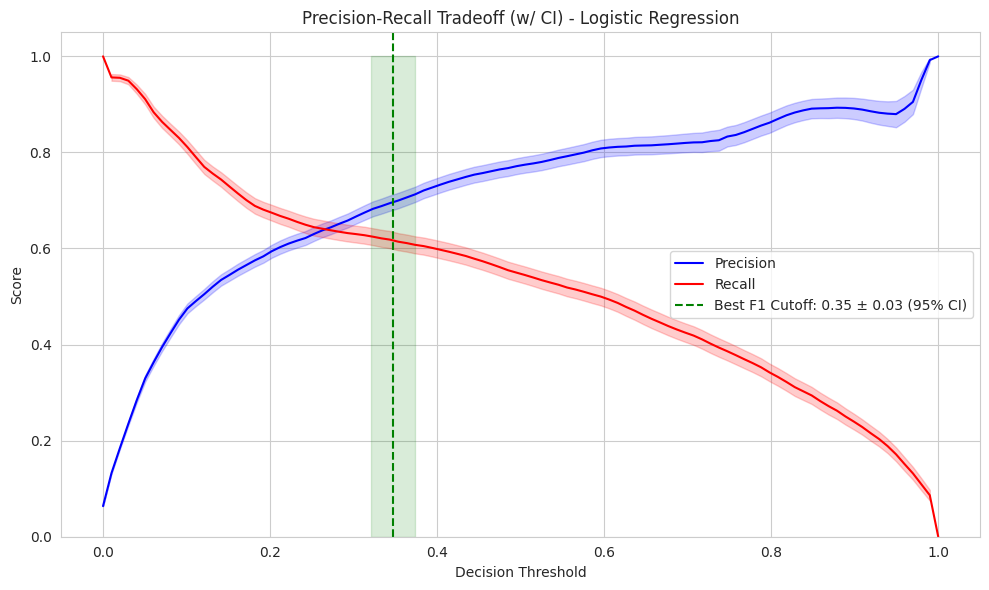

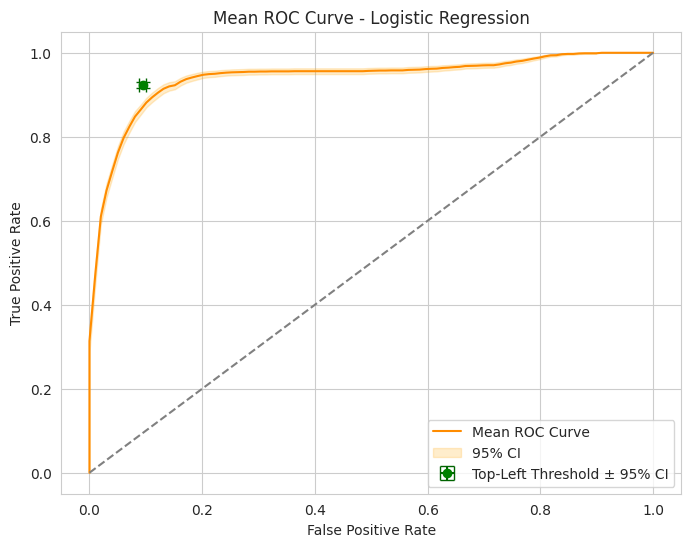


✅ Mean Top-Left Threshold (ROC): 0.08 ± 0.01 (95% CI)


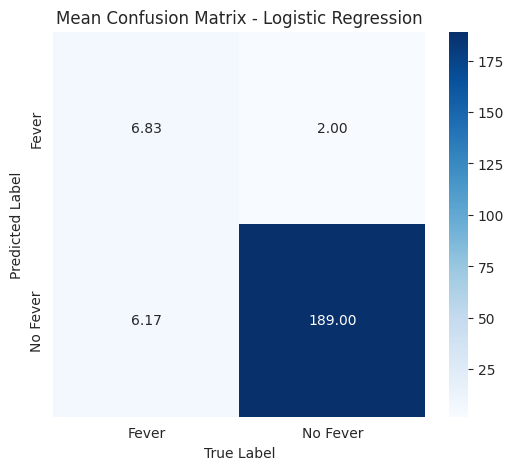

In [ ]:
num_cols = X_REDUCED.select_dtypes(exclude=['object', 'category']).columns.tolist()

logreg_model = LogisticRegression(max_iter=10000, random_state=2025)

logreg_results, best_logreg = monte_carlo_cv_with_plot(
    model=logreg_model,
    param_grid=None,  # No tuning
    X=X_REDUCED,
    y=y,
    model_name="Logistic Regression",
    num_iterations=200
)

# Save results
monte_carlo_results["Logistic Regression"].to_csv(f"{save_path_c_f}/logistic_regression_mccv_results.csv", index=False)
logreg_results.to_csv(f"{save_path_c_f}/logistic_regression_summary.csv")


- **Features Used:**
  - `T_atm`, `Humidity`, `Distance`, `T_offset1`, `Max1R13_1`, `T_FHCC1`, `Gender`, `Age`, `Ethnicity`
  - These were selected due to low correlation (Pearson r < 0.8) to reduce multicollinearity and improve model stability.
  > See section 1.2 to see the correlation matrix.

- **Best Hyperparameters:**
  - NO HYPERPARAMETERS FOR LOGISTIC REGRESSION

- **Mean F1 Score (Optimal Threshold = 0.35 ± 0.03):**
  - **F1 Score:** 0.619 ± 0.111

- **Precision-Recall Trade-off Discussion:**
  - The curve showed a clear intersection around 0.35, where precision and recall trade off most efficiently.
  - Precision remained higher than recall across most thresholds.
  - The model leaned towards **precision over recall**, which may lead to fewer false positives (detecting fever when it isn't present) but could miss actual fever cases. This is an important consideration for screening tools.

- **Mean ROC Curve and AUC Discussion:**
  - The ROC curve was strong, with a **Mean AUC of 0.94 ± 0.037**, suggesting high discriminative ability.
  - The top-left threshold (optimal by ROC) was around **0.08 ± 0.01**, which is more aggressive (higher recall, lower precision) compared to the F1-optimal cutoff, highlighting the precision-recall tradeoff.

- **Other Metrics (at F1-optimal threshold ~0.35):**
  - **Accuracy:** 0.96 ± 0.01
  - **Precision:** 0.788 ± 0.129
  - **Recall:** 0.526 ± 0.131

- **Advantages of Logistic Regression:**
  - Highly interpretable coefficients
  - Computationally efficient and easy to implement
  - Performs well even with onyl eight of the predictors.
  - Provides probabilistic outputs and easy threshold tuning

- **Disadvantages of Logistic Regression:**
  - Limited capacity to model non-linear patterns
  - Tends to underfit complex relationships
  - Precision-recall imbalance in imbalanced datasets can lead to suboptimal recall unless threshold is carefully tuned

  > **Note:**  
> The green dot represents the *mean top-left threshold* — the average threshold (±95% CI) that got the smallest Euclidean distance to the top-left corner (perfect classifier) across all Monte Carlo CV runs.  
>
> It does **not always lie exactly on the mean ROC curve**, as the ROC curve shown is the average of all individual ROC curves, while the green dot is the average of each fold's best (FPR, TPR) pair. This slight offset is expected due to cross-validation variability and averaging.



**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 2/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 3/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 4/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 5/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 6/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 7/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 8/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 9/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 10/

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



🔄 Monte Carlo Iteration 89/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 90/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 91/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 92/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 93/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 94/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 95/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 96/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 97/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iter

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 172/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 173/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 174/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 175/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 176/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 177/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 178/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 179/200...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 180/200...

🚀 Trainin

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.946         0.012     0.941    0.027           0.856   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results           0.08        0.609       0.092    0.707   0.073

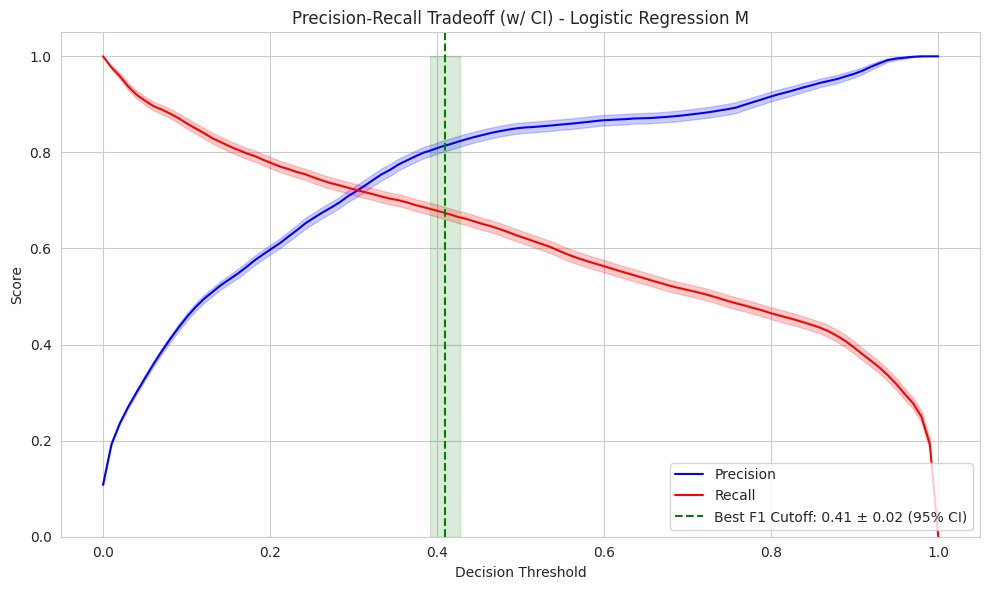

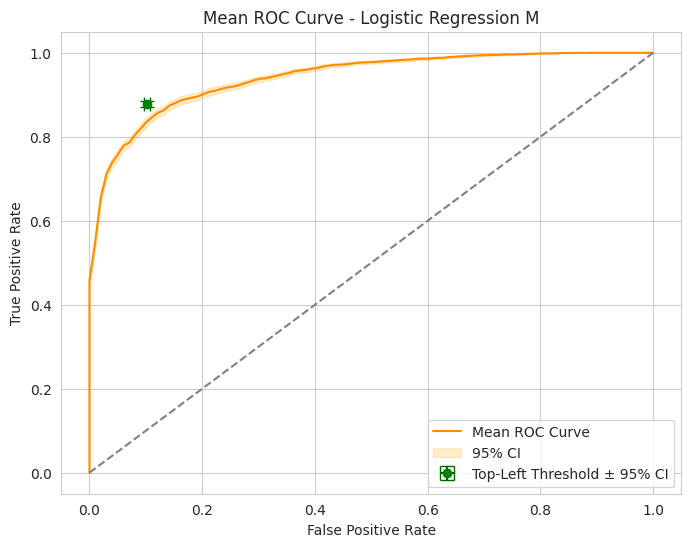


✅ Mean Top-Left Threshold (ROC): 0.14 ± 0.01 (95% CI)


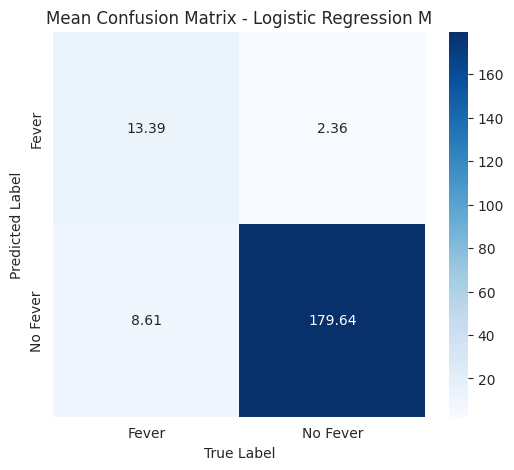

In [ ]:
num_cols = X_REDUCED.select_dtypes(exclude=['object', 'category']).columns.tolist()

logreg_model = LogisticRegression(max_iter=1000, random_state=2025)

logreg_resultsM, best_logregM = monte_carlo_cv_with_plot(
    model=logreg_model,
    param_grid=None,  # No tuning
    X=X_REDUCED,
    y=y2,
    model_name="Logistic Regression M",
    num_iterations=200
)

# Save results
monte_carlo_results["Logistic Regression M"].to_csv(f"{save_path_c_m}/logistic_regression_mccv_results.csv", index=False)
logreg_resultsM.to_csv(f"{save_path_c_m}/logistic_regression_summary.csv")


- **Features Used:**
  - `T_atm`, `Humidity`, `Distance`, `T_offset1`, `Max1R13_1`, `T_FHCC1`, `Gender`, `Age`, `Ethnicity`
  - These were selected due to low correlation (Pearson r < 0.8) to reduce multicollinearity and improve model stability.
  > See section 1.2 to see the correlation matrix.

- **Best Hyperparameters:**
  - No hyperparameters

- **Mean F1 Score (Optimal Threshold = 0.41 ± 0.02):**
  - **F1 Score:** 0.707 ± 0.073

- **Precision-Recall Trade-off Discussion:**
  - A well-balanced curve with a smooth trade-off between precision and recall.
  - The F1-optimal threshold (0.41) is slightly higher than in Fast Mode, suggesting a more conservative decision boundary.
  - Compared to Fast Mode, recall is notably higher, indicating better sensitivity to detecting fever cases.

- **Mean ROC Curve and AUC Discussion:**
  - ROC curve is strong, with **Mean AUC = 0.941 ± 0.027**, nearly identical to Fast Mode.
  - Top-left threshold from ROC = **0.14 ± 0.01**, which favors higher recall but sacrifices precision which is similar to Fast Mode but slightly shifted.

- **Other Metrics (at F1-optimal threshold ~0.41):**
  - **Accuracy:** 0.946 ± 0.012
  - **Precision:** 0.856 ± 0.080
  - **Recall:** 0.609 ± 0.092

- **Advantages of Logistic Regression:**
  - Interpretable and quick to train
  - Well-calibrated probability outputs
  - Performs well even without tuning
  - Consistent across both Fast and Monitor modes

- **Disadvantages of Logistic Regression:**
  - Limited to linear decision boundaries
  - May underperform on complex non-linear patterns
  - Still showed a moderate drop in recall, ~39% of fever cases were missed


## 3.4 Elastic Net

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6541


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7111


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6857


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6576


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 5/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7098


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 6/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6753


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 7/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7231


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 8/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7403


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 9/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6937


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 10/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6676


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 11/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6604


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 12/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6982


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 13/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7301


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 14/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6389


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 15/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6981


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 16/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7017


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 17/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6955


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 18/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6649


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 19/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 20/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6879


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 21/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7143

🔄 Monte Carlo Iteration 22/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6700


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 23/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7396


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 24/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6965


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 25/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6879


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 26/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7104


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 27/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 28/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7291


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 29/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7307


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 30/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6368


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 31/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6491


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 32/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6839


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 33/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6930


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 34/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7325


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 35/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6619


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 36/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 37/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6794


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 38/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6737


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 39/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6719


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 40/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7155


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 41/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6890


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 42/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7010


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 43/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6469


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 44/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 45/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7021


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 46/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6607


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 47/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6560


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 48/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7766


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 49/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7236


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 50/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7080


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 51/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7237


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 52/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7171


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 53/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7838


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 54/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7392


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 55/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7139


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 56/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6846


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 57/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6834


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 58/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7010


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 59/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6901


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 60/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7729


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 61/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7198


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 62/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7050


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 63/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7216

🔄 Monte Carlo Iteration 64/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6713


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 65/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7191


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 66/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6995


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 67/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6674


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 68/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7105


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 69/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6393


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 70/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7187


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 71/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6936


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 72/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 73/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7230


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 74/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6973


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 75/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6502


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 76/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7055


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 77/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6319


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 78/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6849


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 79/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7170


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 80/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6554


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 81/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6851


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 82/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7090


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 83/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7212


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 84/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7621


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 85/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6879


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 86/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6462

🔄 Monte Carlo Iteration 87/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7111

🔄 Monte Carlo Iteration 88/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6948


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6914


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6507


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6811


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6731


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 93/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7524


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 94/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7059


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 95/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7156

🔄 Monte Carlo Iteration 96/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6715


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 97/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6871


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 98/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6603


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 99/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 100/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7074


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 101/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6603


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 102/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6642


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 103/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6890


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 104/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7609


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 105/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6654


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 106/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7065


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 107/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7102


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 108/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7221


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 109/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6567


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 110/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6982


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 111/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6947

🔄 Monte Carlo Iteration 112/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7234


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 113/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7447


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 114/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6872


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 115/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7123

🔄 Monte Carlo Iteration 116/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7088

🔄 Monte Carlo Iteration 117/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7082


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 118/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 119/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7301


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 120/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7122


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 121/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6454


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 122/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7163


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 123/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6644


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 124/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6719


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 125/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 126/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6787


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 127/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6960


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 128/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7571


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 129/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6483


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 130/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7217


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 131/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 132/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6946


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 133/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6548


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 134/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7756


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 135/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6535


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 136/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7269


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 137/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7026


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 138/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6813


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 139/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6462


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 140/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6775


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 141/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6147

🔄 Monte Carlo Iteration 142/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6662


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 143/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6907


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 144/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7060


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 145/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7138


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 146/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6867


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 147/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6965


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 148/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7352


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 149/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6617


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 150/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6049


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 151/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6885


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 152/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6426


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 153/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7566


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 154/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6865


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 155/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7034


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 156/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 157/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7538


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 158/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6871


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 159/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6991


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 160/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7306


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 161/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6910

🔄 Monte Carlo Iteration 162/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6672


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 163/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7102


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 164/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7114


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 165/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6994


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 166/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7197


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 167/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6562


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 168/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7375


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 169/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6824


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 170/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7222


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7540


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6761


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6907


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 174/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6742


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 175/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7566


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 176/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7055

🔄 Monte Carlo Iteration 177/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6573


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 178/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6593


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 179/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6529


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 180/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7331


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 181/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7422


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 182/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7409


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 183/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7744


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 184/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6581


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 185/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6998


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 186/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6890


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 187/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.5969


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 188/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7010

🔄 Monte Carlo Iteration 189/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6773


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 190/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6694


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 191/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7122


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 192/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7150


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 193/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7482


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 194/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7261


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 195/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7436


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 196/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7325


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 197/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.6561


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 198/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.6205


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 199/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7303


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔄 Monte Carlo Iteration 200/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7270

📊 Monte Carlo CV Results


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.965          0.01     0.965    0.021           0.796   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.114        0.627       0.128    0.692     0.1


🏆 Most Common Best Hyperparameters:
1. Params: {'C': 1.0, 'l1_ratio': 0.3} | Chosen: 136 out of 200 times
2. Params: {'C': 1.0, 'l1_ratio': 0.7} | Chosen: 64 out of 200 times


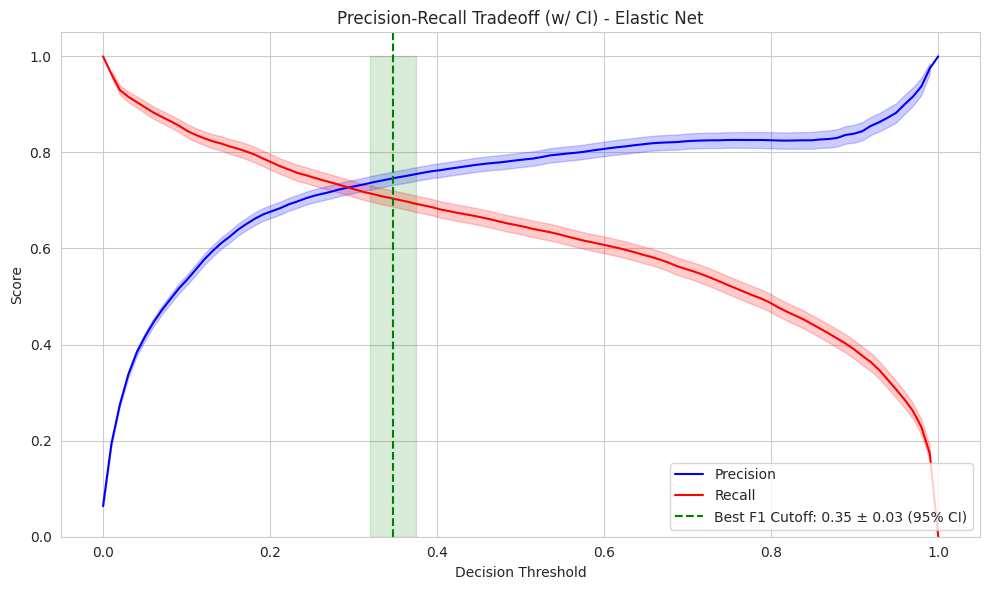

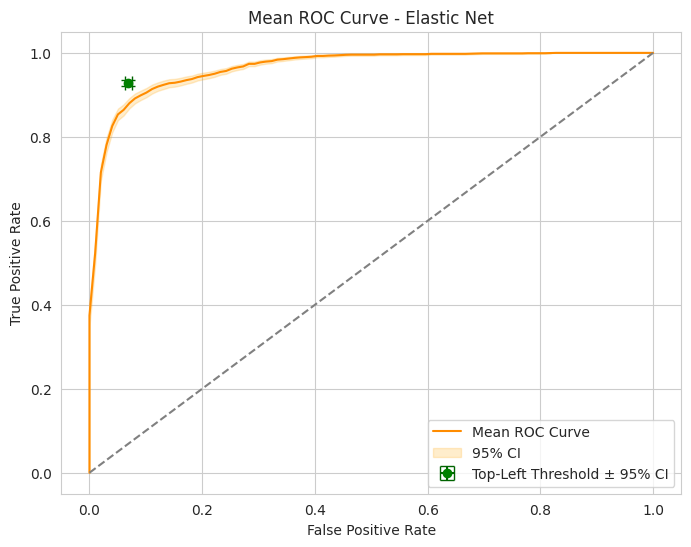


✅ Mean Top-Left Threshold (ROC): 0.11 ± 0.01 (95% CI)


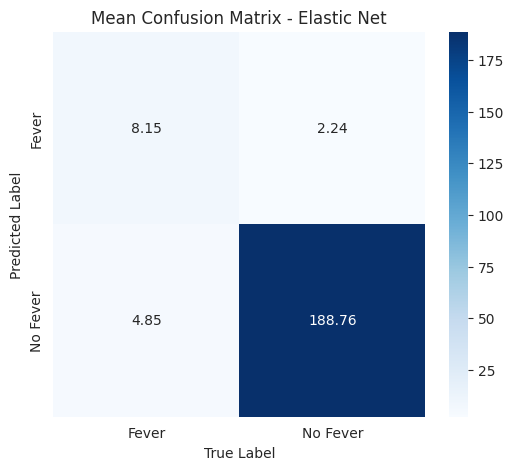

In [ ]:
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

elastic_model = LogisticRegression(
    penalty="elasticnet",solver="saga",
    random_state=2025,max_iter=1000)

elastic_param_grid = {
    "l1_ratio": [.3, .7],     # Elastic Net mixing parameter
    "C": [ 1.0]        # Inverse of regularization strength
}
elastic_results, best_elastic = monte_carlo_cv_with_plot(
    elastic_model,
    elastic_param_grid,
    X=X,
    y=y,
    model_name="Elastic Net",
    num_iterations=200
)
elastic_results.to_csv(f"{save_path_c_f}/elastic_net_summary.csv")
monte_carlo_results["Elastic Net"].to_csv(f"{save_path_c_f}/elastic_net_mccv_results.csv", index=False)

>*All features were kept in this model.*  
  Elastic Net's built-in regularisation (L1 + L2) performs a type of feature selection and shrinks less important coefficients toward zero, reducing overfitting risk.

- **Best Hyperparameters:**
  - Most common: `C = 1.0`, `l1_ratio = 0.3` (selected in 136/200 runs)
  - Second most common: `C = 1.0`, `l1_ratio = 0.7` (64/200 runs)

- **Mean F1 Score (Optimal Threshold = 0.35 ± 0.03):**
  - **F1 Score:** 0.692 ± 0.100

- **Precision-Recall Trade-off Discussion:**
  - Very similar shape to logistic regression, with a crossover around 0.35.
  - Precision generally stayed above recall, though the gap was narrower than in logistic regression.
  - Balanced F1 performance, with higher recall (0.627) compared to logistic regression, indicating improved sensitivity without sacrificing too much precision.

- **Mean ROC Curve and AUC Discussion:**
  - Excellent ROC performance: **Mean AUC = 0.965 ± 0.021**, which is among the highest observed so far.
  - Top-left threshold by ROC = **0.11 ± 0.01**, consistent with prioritizing recall at the cost of precision.
  - Indicates strong separation between classes, even better than logistic regression.

- **Other Metrics (at F1-optimal threshold ~0.35):**
  - **Accuracy:** 0.965 ± 0.010
  - **Precision:** 0.796 ± 0.114
  - **Recall:** 0.627 ± 0.128

- **Advantages of Elastic Net:**
  - Combines L1 and L2 regularization for feature penalization
  - Higher recall and AUC than logistic regression, better at detecting fevers
  - Handles correlated predictors better than logistic regression

- **Disadvantages of Elastic Net:**
  - Limited in capturing complex patterns
  - Requires hyperparameter tuning (C & l1_ratio), which adds computation


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.8016

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.8161

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7988

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7729

🔄 Monte Carlo Iteration 5/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C'

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7889

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7710

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.8213

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7785

🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7708

🔄 Monte Carlo Iteration 93/200...

🔍 Hyperparameter tun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7659

🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7719

🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.7}
✅ Best Cross-Validation F1 Score: 0.7753

🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.7904

🔄 Monte Carlo Iteration 174/200...

🔍 Hyperparameter tuning for {'l1_ratio': [0.3, 0.7], 'C': [1.0]} (Optimizing F1-Score)...
✅ Best Parameters: {'C': 1.0, 'l1_ratio': 0.3}
✅ Best Cross-Validation F1 Score: 0.8002

🔄 Monte Carlo Iteration 175/200...

🔍 Hyperparamete

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.957         0.012     0.972    0.016           0.855   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.082        0.738       0.088    0.787   0.064


🏆 Most Common Best Hyperparameters:
1. Params: {'C': 1.0, 'l1_ratio': 0.3} | Chosen: 143 out of 200 times
2. Params: {'C': 1.0, 'l1_ratio': 0.7} | Chosen: 57 out of 200 times


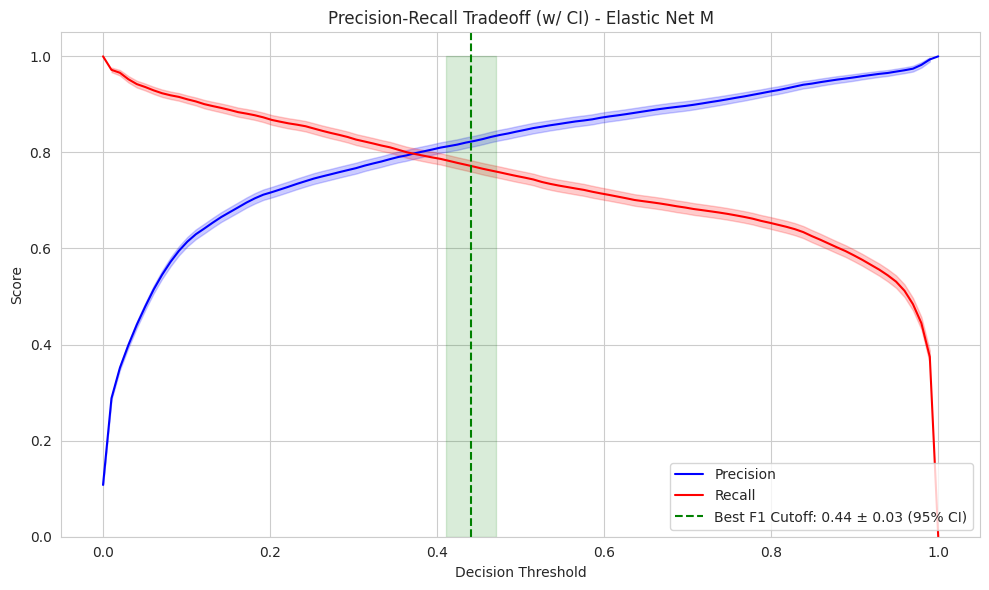

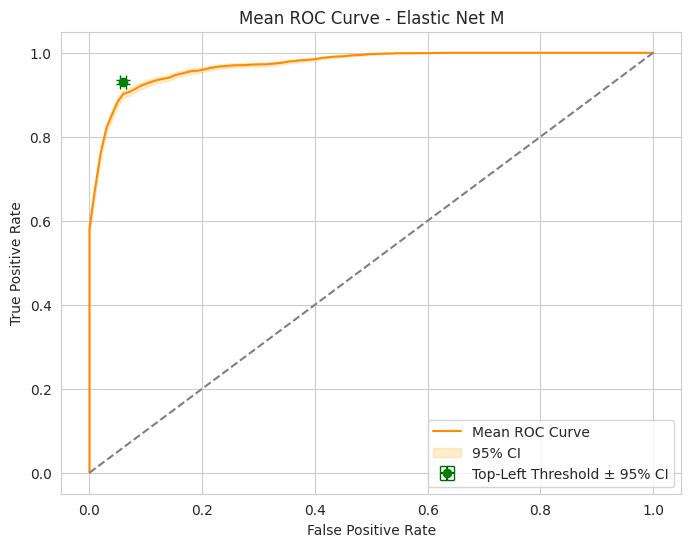


✅ Mean Top-Left Threshold (ROC): 0.17 ± 0.01 (95% CI)


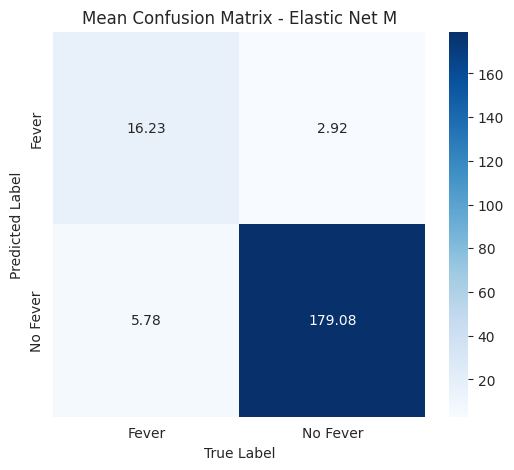

In [ ]:
elastic_model = LogisticRegression(
    penalty="elasticnet",solver="saga",
    random_state=2025,max_iter=3000)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

elastic_resultsM, best_elasticM = monte_carlo_cv_with_plot(
    elastic_model,
    elastic_param_grid,
    X=X,
    y=y2,
    model_name="Elastic Net M",
    num_iterations=200
)
elastic_resultsM.to_csv(f"{save_path_c_m}/elastic_net_summary.csv")
monte_carlo_results["Elastic Net M"].to_csv(f"{save_path_c_m}/elastic_net_mccv_results.csv", index=False)

- **Best Hyperparameters:**
  - Most common: `C = 1.0`, `l1_ratio = 0.3` (selected in 143/200 runs)
  - Second most common: `C = 1.0`, `l1_ratio = 0.7` (57/200 runs)

- **Mean F1 Score (Optimal Threshold = 0.44 ± 0.03):**
  - **F1 Score:** 0.787 ± 0.064

- **Precision-Recall Trade-off Discussion:**
  - The precision-recall curves intersected around 0.44, slightly higher than in Fast Mode, suggesting a more conservative cutoff.
  - The model maintained **high precision (0.855)** and also significantly improved **recall (0.738)** over Fast Mode and previous models.
  - Balanced results with strong performance in both metrics indicates good fever detection.

- **Mean ROC Curve and AUC Discussion:**
  - Very strong ROC curve with **Mean AUC = 0.972 ± 0.016**, the highest so far.
  - The ROC-optimal threshold (~0.08-0.10) is still lower than the F1-optimal one.

- **Other Metrics (at F1-optimal threshold ~0.44):**
  - **Accuracy:** 0.957 ± 0.012
  - **Precision:** 0.855 ± 0.082
  - **Recall:** 0.738 ± 0.088

- **Advantages of Elastic Net:**
  - Strongest performer across both modes so far
  - Good balance of recall and precision with fewer missed fever cases and few false alarms
  - Regularization helps with generalization and stability

- **Disadvantages of Elastic Net:**
  - Limited in capturing complex patterns
  - Requires hyperparameter tuning (C & l1_ratio), which adds computation


## 3.5 Decision Tree


**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6320

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6694

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6679

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6819

🔄 Monte Carlo Iteration 5/200...

🔍 Hyp

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 7}
✅ Best Cross-Validation F1 Score: 0.5928

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6113

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.5825

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.6389

🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 7], 'min_samples_split': [2, 7]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 7, 

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.957         0.011     0.845    0.088           0.688   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.118        0.625       0.148    0.643   0.104


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 3, 'min_samples_split': 2} | Chosen: 153 out of 200 times
2. Params: {'min_samples_split': 7, 'max_depth': 3} | Chosen: 30 out of 200 times
3. Params: {'max_depth': 7, 'min_samples_split': 2} | Chosen: 10 out of 200 times
4. Params: {'max_depth': 7, 'min_samples_split': 7} | Chosen: 7 out of 200 times


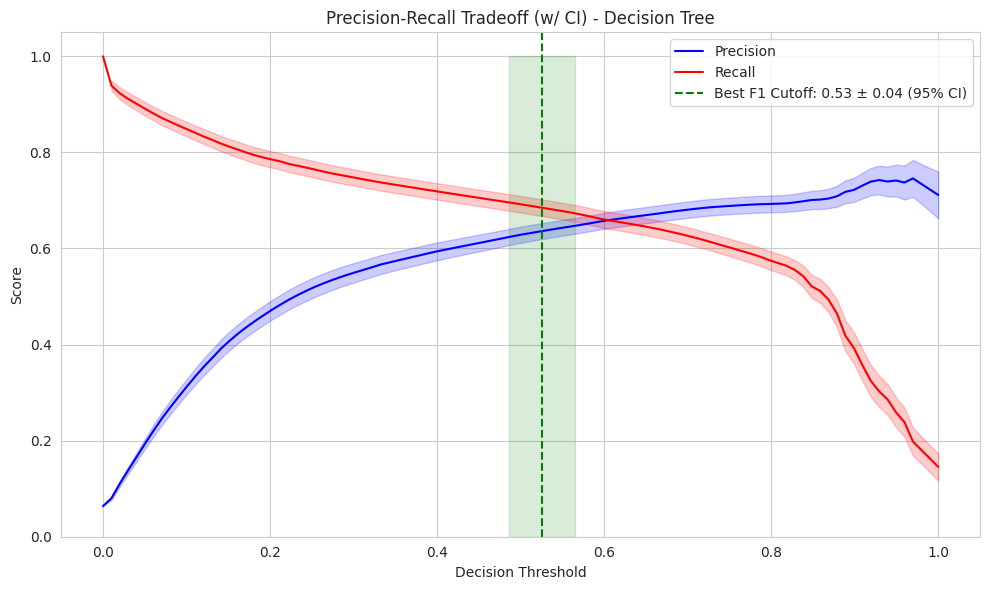

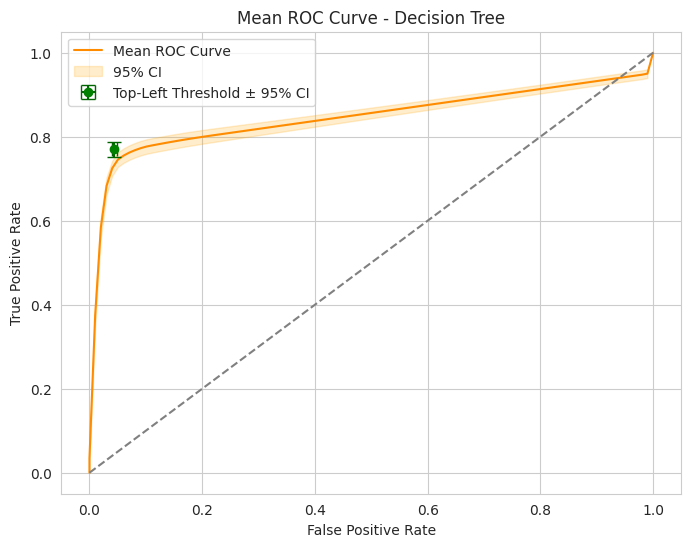


✅ Mean Top-Left Threshold (ROC): 0.36 ± 0.04 (95% CI)


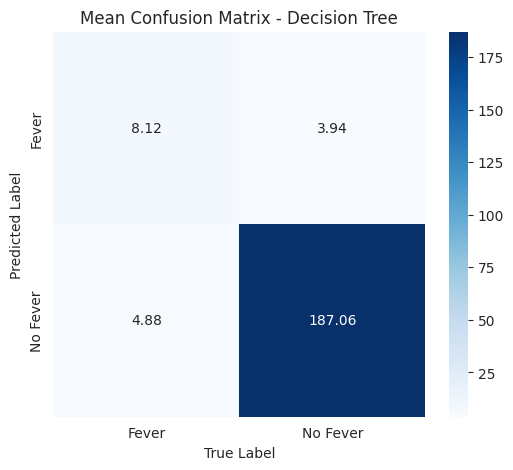

In [ ]:
dt_param_grid = {
    "max_depth": [3, 7],  # Tuning tree depth
    "min_samples_split": [2, 7]  # Controlling node splits
}
dt_model = DecisionTreeClassifier(random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

dt_results, best_dt = monte_carlo_cv_with_plot(
    dt_model, dt_param_grid, X, y,
    model_name="Decision Tree",
    num_iterations=200
)

monte_carlo_results["Decision Tree"].to_csv(f"{save_path_c_f}/decision_tree_mccv_results.csv", index=False)
dt_results.to_csv(f"{save_path_c_f}/decision_tree_summary.csv")


- **Best Hyperparameters:**
  - Most common: `max_depth = 3`, `min_samples_split = 2` (selected in 153/200 runs)

- **Mean F1 Score (Optimal Threshold = 0.53 ± 0.04):**
  - **F1 Score:** 0.643 ± 0.104

- **Precision-Recall Trade-off Discussion:**
  - Precision and recall curves intersect around 0.53, showing a balanced trade-off point.
  - Precision remains slightly higher than recall across most thresholds.
  - Compared to linear models, recall is slightly better than logistic regression but still not ideal for detecting all fevers.

- **Mean ROC Curve and AUC Discussion:**
  - ROC curve shows decent separation but not as sharp as Elastic Net.
  - **Mean AUC:** 0.845 ± 0.088 — lower than regularized linear models, indicating some misclassifications.
  - Top-left ROC threshold: **0.36 ± 0.04**, showing a higher threshold is needed to maximize true positive rate.

- **Other Metrics (at F1-optimal threshold ~0.53):**
  - **Accuracy:** 0.957 ± 0.011
  - **Precision:** 0.688 ± 0.118
  - **Recall:** 0.625 ± 0.148

- **Advantages of Decision Tree:**
  - Simple and interpretable structure
  - Naturally handles non-linear feature interactions
  - Performs decently even with shallow depth (depth=3)

- **Disadvantages of Decision Tree:**
  - Lower AUC and F1 than Elastic Net
  - Slightly unstable: performance varies more due to data splits
  - Prone to overfitting without proper regularization


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7871

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.7859

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.6943

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.7691

🔄 Monte C

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7548

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7838

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.7445

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.7408

🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7803

🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 7, 'min_samples_split': 2}
✅ Best Cross-Validation F1 Score: 0.7406

🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7870

🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
✅ Best Cross-Validation F1 Score: 0.7762

🔄 Monte Carlo Iteration 174/200...

🔍 Hyperparameter tuning for {'max_depth': [3, 5, 7], 'min_samples_split': [2, 7, 10]} (Optimizing F1-Score)...
✅

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.946         0.015     0.897    0.066           0.777   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.099        0.722       0.103    0.741   0.069


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 3, 'min_samples_split': 2} | Chosen: 38 out of 200 times
2. Params: {'max_depth': 5, 'min_samples_split': 10} | Chosen: 35 out of 200 times
3. Params: {'min_samples_split': 2, 'max_depth': 5} | Chosen: 31 out of 200 times
4. Params: {'max_depth': 7, 'min_samples_split': 2} | Chosen: 24 out of 200 times
5. Params: {'min_samples_split': 7, 'max_depth': 5} | Chosen: 22 out of 200 times
6. Params: {'max_depth': 7, 'min_samples_split': 10} | Chosen: 17 out of 200 times
7. Params: {'max_depth': 3, 'min_samples_split': 10} | Chosen: 13 out of 200 times
8. Params: {'min_samples_split': 7, 'max_depth': 3} | Chosen: 12 out of 200 times
9. Params: {'max_depth': 7, 'min_samples_split': 7} | Chosen: 8 out of 200 times


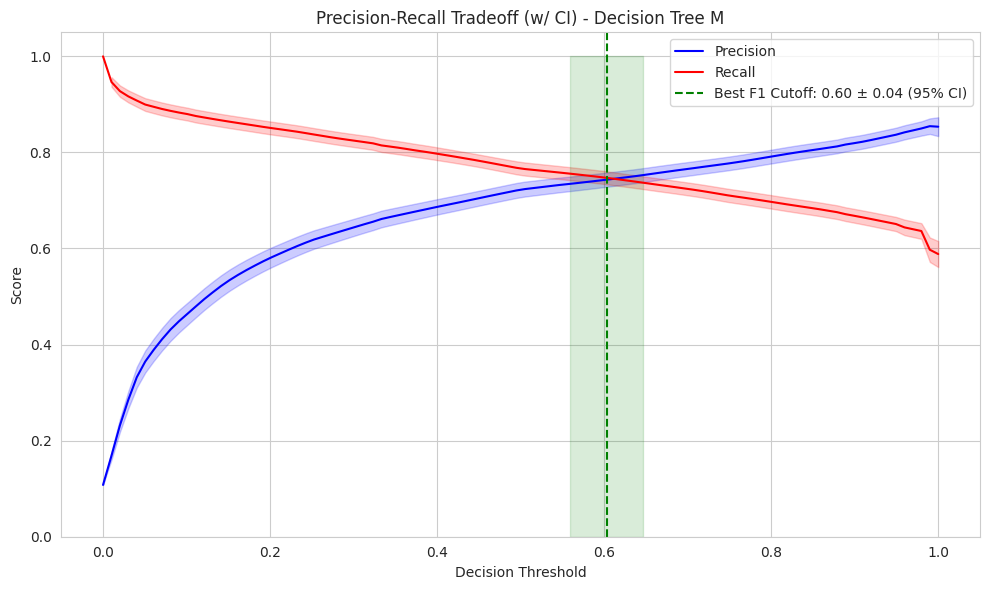

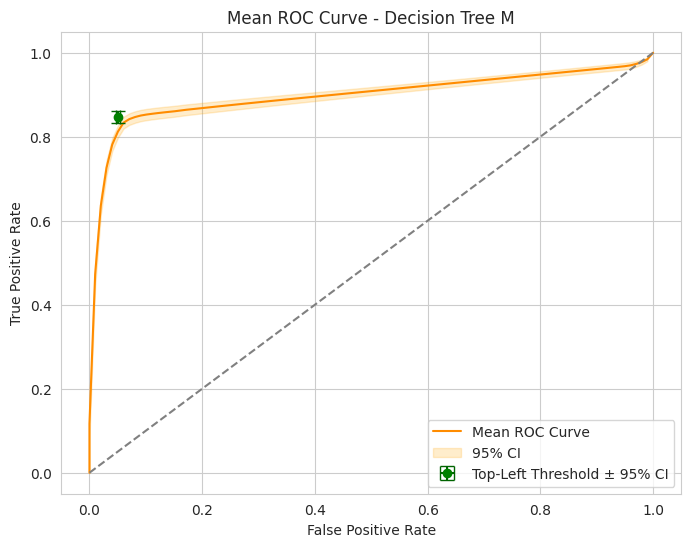


✅ Mean Top-Left Threshold (ROC): 0.38 ± 0.04 (95% CI)


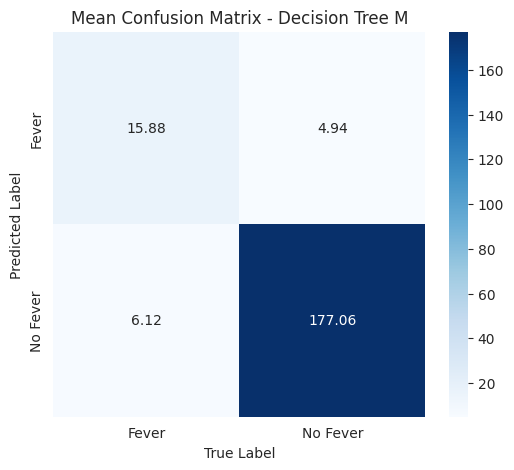

In [ ]:
dt_model = DecisionTreeClassifier(random_state=2025)
dt_param_grid = {
    "max_depth": [3,5, 7],  # Tuning tree depth
    "min_samples_split": [2, 7,10]  # Controlling node splits
}
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

dt_resultsM, best_dtM = monte_carlo_cv_with_plot(
    dt_model, dt_param_grid, X, y2,
    model_name="Decision Tree M",
    num_iterations=200
)

monte_carlo_results["Decision Tree M"].to_csv(f"{save_path_c_m}/decision_tree_mccv_results.csv", index=False)
dt_resultsM.to_csv(f"{save_path_c_m}/decision_tree_summary.csv")

- **Best Hyperparameters:**
  - Most common: `max_depth = 3`, `min_samples_split = 2` (38/200 runs)
  - Others frequently chosen: `max_depth = 5`, `min_samples_split = 10` (35/200) and `max_depth = 5`, `min_samples_split = 2` (31/200)

- **Mean F1 Score (Optimal Threshold = 0.60 ± 0.04):**
  - **F1 Score:** 0.741 ± 0.069

- **Precision-Recall Trade-off Discussion:**
  - Curves intersect at a relatively high threshold (0.60), indicating conservative predictions.
  - Precision and recall are better balanced than in Fast Mode.
  - Strong recall (0.722) paired with good precision (0.777) makes this simple model a solid fever detector.

- **Mean ROC Curve and AUC Discussion:**
  - ROC curve improves noticeably over Fast Mode.
  - **Mean AUC:** 0.897 ± 0.066 — a strong value for a simple decision tree.
  - The ROC-optimal threshold (green dot) remains around the 0.08-0.10 range, suggesting extreme thresholds still favor maximum separation.

- **Other Metrics (at F1-optimal threshold ~0.60):**
  - **Accuracy:** 0.946 ± 0.015
  - **Precision:** 0.777 ± 0.099
  - **Recall:** 0.722 ± 0.103

- **Advantages of Decision Tree:**
  - Interpretable and visualizable — useful in clinical or operational settings
  - Stronger F1 and AUC than Fast Mode
  - Captures non-linear patterns without requiring complex tuning

- **Disadvantages of Decision Tree:**
  - Less stable than regularized models (wider confidence intervals)
  - Slightly inconsistent hyperparameter preferences — model may be sensitive to train/test split
  - Doesn't match Elastic Net in overall discriminative power


## 3.6 Random Forest

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7301

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.7163

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7200

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split'

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.6678

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.6906

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.6621

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7296

🔄 Monte 

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.964          0.01     0.972    0.023           0.755   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.109        0.659       0.124    0.695   0.092


🏆 Most Common Best Hyperparameters:
1. Params: {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 5} | Chosen: 30 out of 200 times
2. Params: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50} | Chosen: 28 out of 200 times
3. Params: {'min_samples_split': 5, 'max_depth': 8, 'n_estimators': 50} | Chosen: 20 out of 200 times
4. Params: {'n_estimators': 80, 'min_samples_split': 2, 'max_depth': 5} | Chosen: 19 out of 200 times
5. Params: {'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 2} | Chosen: 19 out of 200 times
6. Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50} | Chosen: 17 out of 200 times
7. Params: {'min_samples_split': 5, 'n_estimators': 50, 'max_depth': 5} | Chosen: 17 out of 200 times
8. Params: {'min_samples_split': 5, 'max_depth': 8, 'n_estimators': 80} | Chosen: 16 out of 200 times
9. Params: {'min_samples_split': 5, 'max_depth': 3, 'n_estimators': 50} | Chosen: 14 out of 200 times
10. Params: {'min_samples_split': 5, 'n_estim

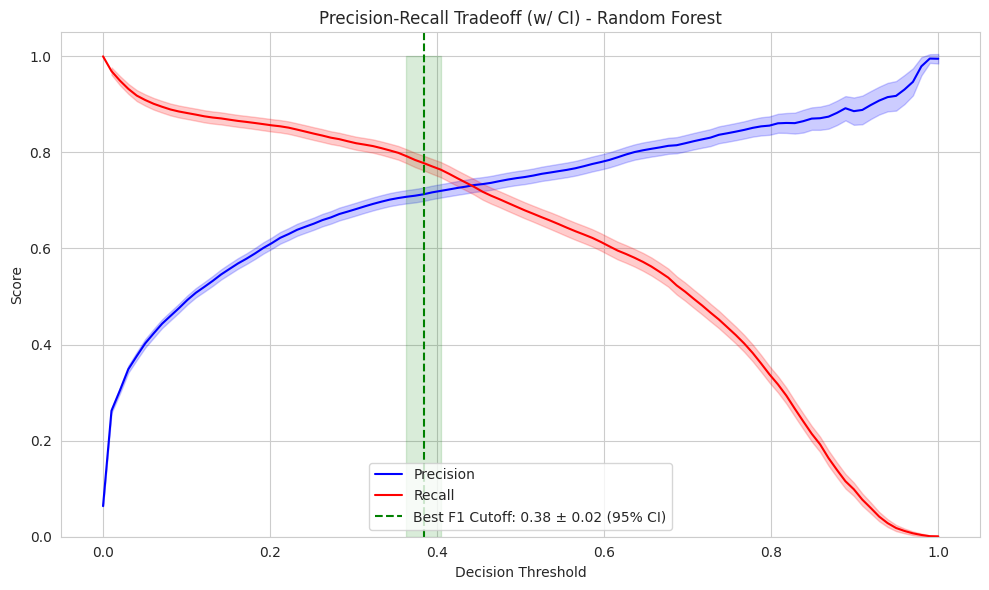

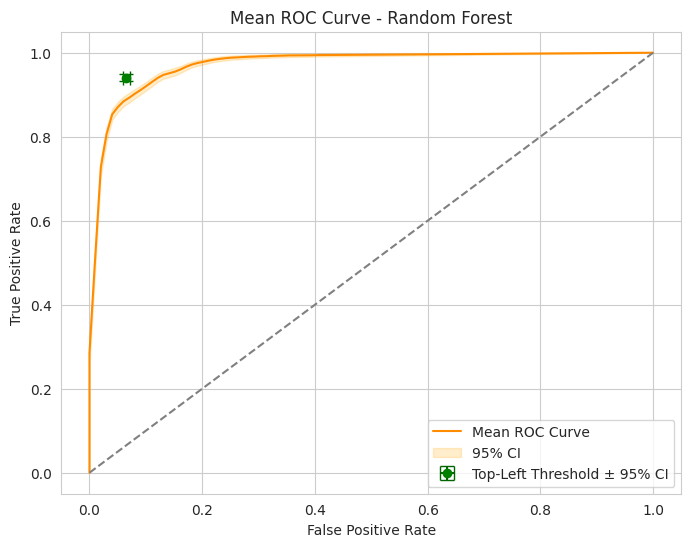


✅ Mean Top-Left Threshold (ROC): 0.16 ± 0.02 (95% CI)


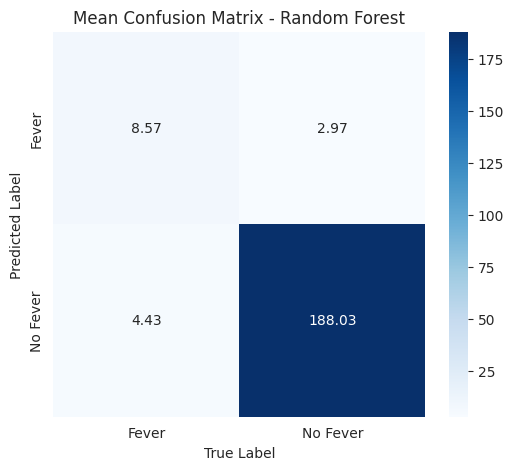

In [ ]:
rf_param_grid = {
    "n_estimators": [50, 80],
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 5]
}
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

rf_model = RandomForestClassifier(random_state=2025)
rf_results, best_rf_model = monte_carlo_cv_with_plot(rf_model,
                                                     rf_param_grid,
                                                     X, y, model_name="Random Forest",
                                                     num_iterations=200)

monte_carlo_results["Random Forest"].to_csv(f"{save_path_c_f}/random_forest_mccv_results.csv", index=False)
rf_results.to_csv(f"{save_path_c_f}/random_forest_summary.csv")




- **Best Hyperparameters:**
  - Most common: `n_estimators = 50`, `max_depth = 5`, `min_samples_split = 2` (30/200 runs)
  - Others: `max_depth = 8`, `n_estimators = 50`, `min_samples_split = 2` (28/200), and similar
  - **Note:** No single configuration dominated — the most common setting was chosen in only 15% of runs, suggesting the model's performance is relatively stable across several hyperparameter configurations.

- **Mean F1 Score (Optimal Threshold = 0.38 ± 0.02):**
  - **F1 Score:** 0.695 ± 0.092

- **Precision-Recall Trade-off Discussion:**
  - Curves intersect at ~0.38, which aligns well with other models.
  - Precision remains high across thresholds, and recall is improved over Logistic and Decision Tree.
  - A good middle ground between aggressive recall and cautious precision.

- **Mean ROC Curve and AUC Discussion:**
  - Very strong curve: **Mean AUC = 0.972 ± 0.023**, similar to Elastic Net.
  - ROC-optimal threshold = **0.16 ± 0.02**, indicating that lower thresholds help boost sensitivity.

- **Other Metrics (at F1-optimal threshold ~0.38):**
  - **Accuracy:** 0.964 ± 0.010
  - **Precision:** 0.755 ± 0.109
  - **Recall:** 0.659 ± 0.124

- **Advantages of Random Forest:**
  - Strong overall performance — high F1 and AUC
  - Naturally handles non-linearities and interactions

- **Disadvantages of Random Forest:**
  - Less interpretable than individual trees or linear models
  - Computationally heavier than simpler models
  - No clearly dominant hyperparameter configuration, making tuning slightly more uncertain


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.8043

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.8209

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7808

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split'

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7824

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.8035

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.8064

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7826

🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.7952

🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best Cross-Validation F1 Score: 0.8171

🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'n_estimators': [50, 80], 'max_depth': [3, 5, 8], 'min_samples_split': [2, 5]} (Optimizing F1-Score)...
✅ Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
✅ Best Cross-Validation F1 Score: 0.7961

🔄 Mon

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.956         0.012     0.972    0.018           0.842   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.085        0.738       0.088    0.781   0.061


🏆 Most Common Best Hyperparameters:
1. Params: {'min_samples_split': 5, 'n_estimators': 50, 'max_depth': 5} | Chosen: 24 out of 200 times
2. Params: {'min_samples_split': 5, 'max_depth': 8, 'n_estimators': 50} | Chosen: 24 out of 200 times
3. Params: {'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 2} | Chosen: 23 out of 200 times
4. Params: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50} | Chosen: 20 out of 200 times
5. Params: {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 5} | Chosen: 20 out of 200 times
6. Params: {'n_estimators': 80, 'min_samples_split': 2, 'max_depth': 5} | Chosen: 15 out of 200 times
7. Params: {'min_samples_split': 5, 'n_estimators': 80, 'max_depth': 5} | Chosen: 14 out of 200 times
8. Params: {'min_samples_split': 5, 'max_depth': 8, 'n_estimators': 80} | Chosen: 14 out of 200 times
9. Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50} | Chosen: 13 out of 200 times
10. Params: {'n_estimators': 80, 'max_depth':

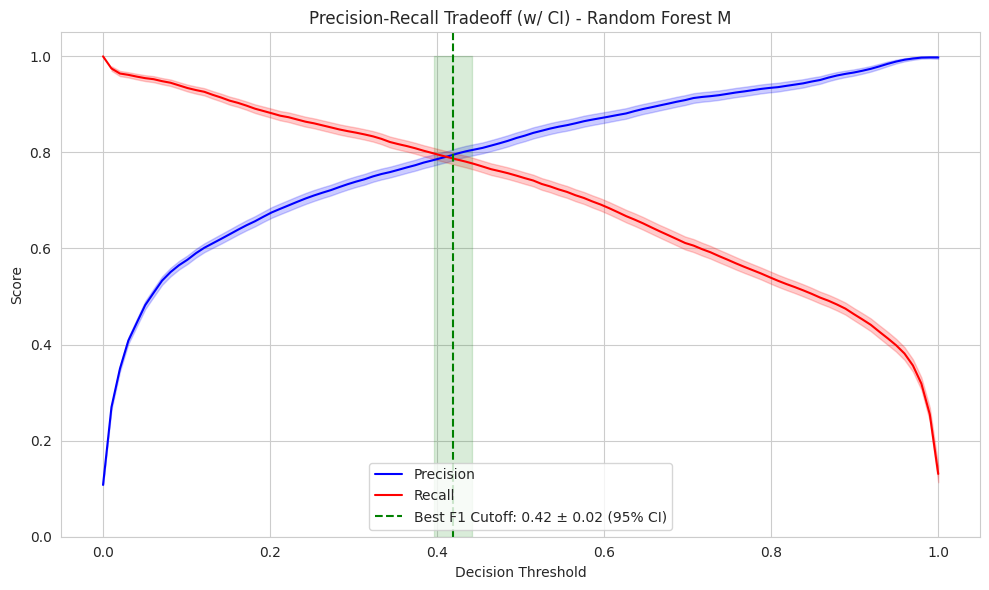

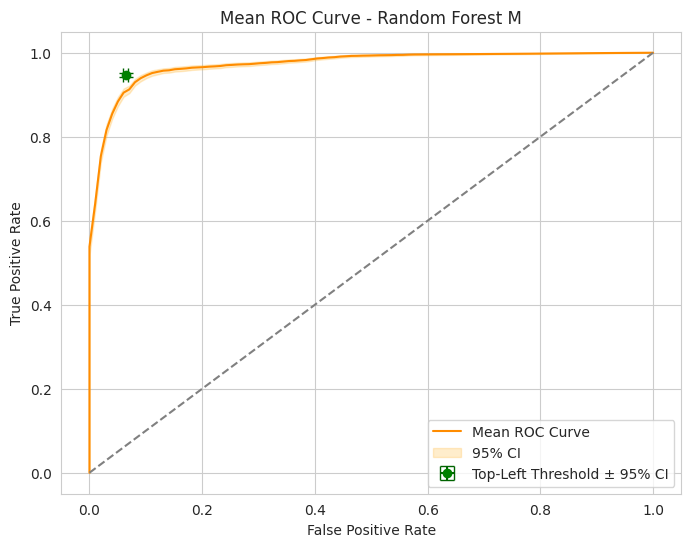


✅ Mean Top-Left Threshold (ROC): 0.17 ± 0.01 (95% CI)


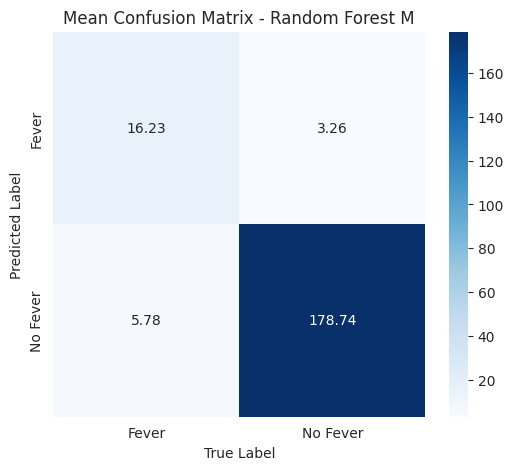

In [ ]:
rf_model = RandomForestClassifier(random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

rf_resultsM, best_rf_modelM = monte_carlo_cv_with_plot(rf_model,
                                                     rf_param_grid,
                                                     X, y2, model_name="Random Forest M",
                                                     num_iterations=200)

monte_carlo_results["Random Forest M"].to_csv(f"{save_path_c_m}/random_forest_mccv_results.csv", index=False)
rf_resultsM.to_csv(f"{save_path_c_m}/random_forest_summary.csv")



- **Best Hyperparameters:**
  - No single configuration dominated — the top five were all chosen around 20–24 times out of 200.
  - Most common:
    - `n_estimators = 50`, `max_depth = 5`, `min_samples_split = 5` (24/200)
    - `n_estimators = 50`, `max_depth = 8`, `min_samples_split = 5` (24/200)
    - Others included `n_estimators = 80` and slightly deeper trees

- **Mean F1 Score (Optimal Threshold = 0.42 ± 0.02):**
  - **F1 Score:** 0.781 ± 0.061

- **Precision-Recall Trade-off Discussion:**
  - The best balance was found around a threshold of 0.42.
  - The model maintained **high precision (0.842)** and also improved **recall (0.738)** — showing strong performance in both aspects.
  - These results reflect fewer missed fever cases without overwhelming false alarms.

- **Mean ROC Curve and AUC Discussion:**
  - Good separation, with **Mean AUC = 0.972 ± 0.018**, matching the best-performing models.
  - ROC-optimal threshold was lower at **0.17 ± 0.01**, showing that lower thresholds further improve sensitivity.

- **Other Metrics (at F1-optimal threshold ~0.42):**
  - **Accuracy:** 0.956 ± 0.012
  - **Precision:** 0.842 ± 0.085
  - **Recall:** 0.738 ± 0.088
  - **AUC:** 0.972 ± 0.018

- **Advantages of Random Forest:**
  - Strong overall performance — high F1 and AUC
  - Naturally handles non-linearities and interactions

- **Disadvantages of Random Forest:**
  - Less interpretable than individual trees or linear models
  - Computationally heavier than simpler models
  - No clearly dominant hyperparameter configuration, making tuning slightly more uncertain


## 3.7 K-Nearest Neighbors (KNN)


**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.6180

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.6400

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.6971

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.5846

🔄 Monte Carlo Iteration 5/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.6546

🔄 Mont

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.5854

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.6504

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.5649

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.6069

🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.6167

🔄 Monte Carlo Iteration 93/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ B

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.959          0.01     0.914    0.053           0.771   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.127        0.529       0.147    0.614   0.118


🏆 Most Common Best Hyperparameters:
1. Params: {'n_neighbors': 7} | Chosen: 103 out of 200 times
2. Params: {'n_neighbors': 10} | Chosen: 42 out of 200 times
3. Params: {'n_neighbors': 5} | Chosen: 31 out of 200 times
4. Params: {'n_neighbors': 3} | Chosen: 24 out of 200 times


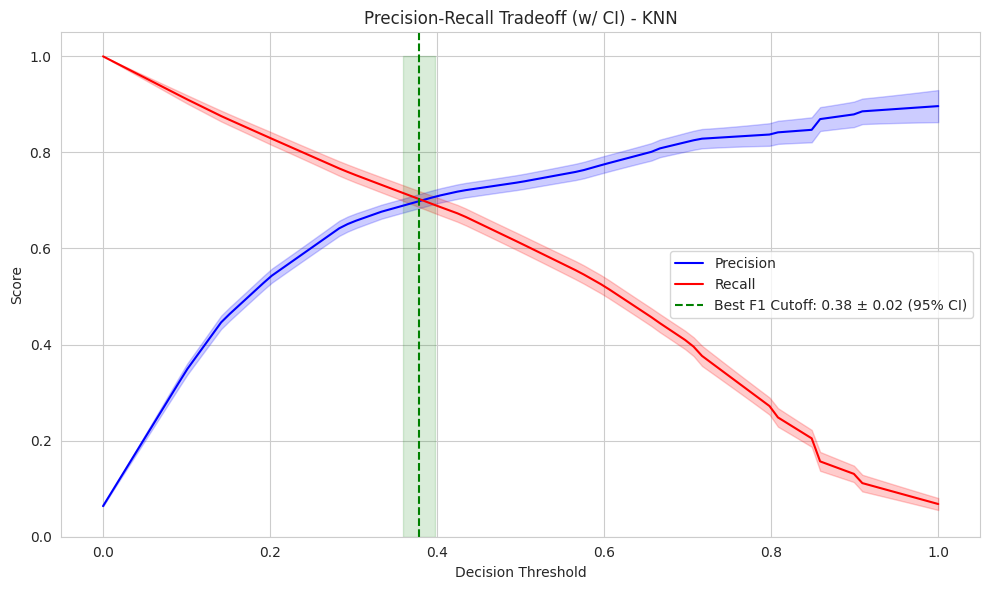

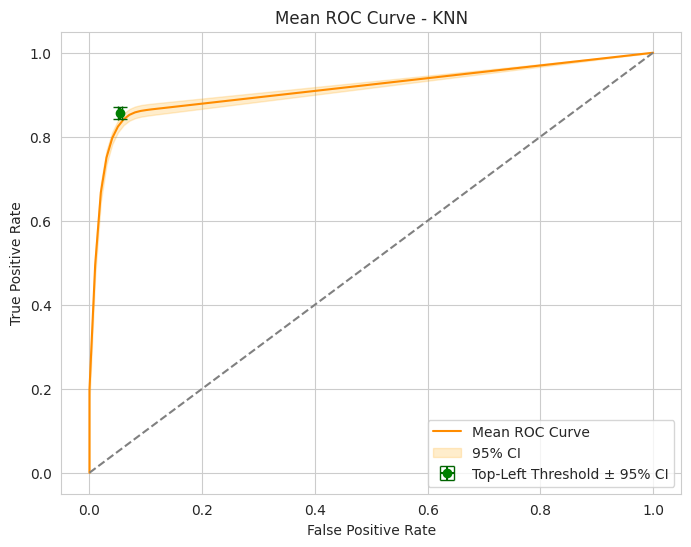


✅ Mean Top-Left Threshold (ROC): 0.20 ± 0.01 (95% CI)


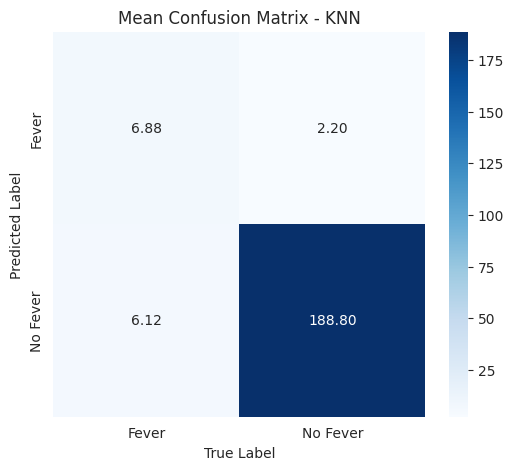

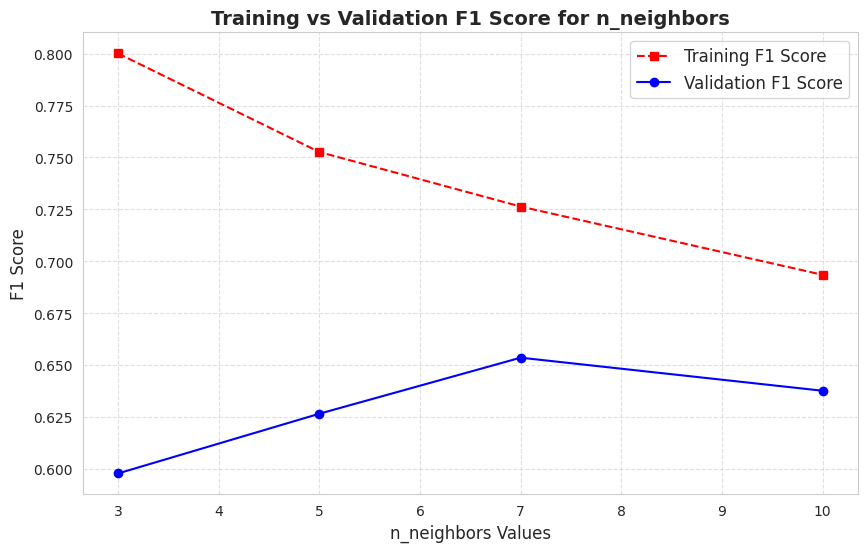

In [ ]:
knn_param_grid = {
    #"n_neighbors": [2,3, 4, 5,6,7,8,9,10,13,15,20],  # Different values for k for low M
     "n_neighbors": [3, 5,7,10],  # Different values for k for high M

}
knn_model = KNeighborsClassifier()
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

knn_results, best_knn = monte_carlo_cv_with_plot(
    knn_model, knn_param_grid, X, y,
    model_name="KNN",
    num_iterations=200
)

monte_carlo_results["KNN"].to_csv(f"{save_path_c_f}/KNN_mccv_results.csv", index=False)
knn_results.to_csv(f"{save_path_c_f}/KNN_summary.csv")


- **Best Hyperparameters:**
  - Most common: `n_neighbors = 7` (chosen 103/200 times)
  - The training vs. validation F1 curve showed a classic overfitting pattern at low k (e.g., k=3), with validation F1 improving and peaking at k=7 before slightly dropping again — this supports k=7 as a strong and stable choice.

- **Mean F1 Score (Optimal Threshold = 0.38 ± 0.02):**
  - **F1 Score:** 0.614 ± 0.118

- **Precision-Recall Trade-off Discussion:**
  - Precision and recall intersect around 0.38.
  - Precision stays fairly high, but recall delines, possibly due to KNN's tendency to be cautious around minority class boundaries.
  - Model is more confident in what it predicts, but misses more fever cases compared to other models.

- **Mean ROC Curve and AUC Discussion:**
  - ROC curve performs reasonably well: **Mean AUC = 0.914 ± 0.053**
  - ROC-optimal threshold = **0.20 ± 0.01**, which would lead to higher recall at the cost of precision.

- **Other Metrics (at F1-optimal threshold ~0.38):**
  - **Accuracy:** 0.959 ± 0.010
  - **Precision:** 0.771 ± 0.127
  - **Recall:** 0.529 ± 0.147

- **Advantages of KNN:**
  - Simple, non-parametric, and easy to understand
  - Captures non-linear decision boundaries

- **Disadvantages of KNN:**
  - Relatively low recall — misses more fever cases
  - Sensitive to imbalanced data and feature scaling


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.7914

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.8163

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.7878

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.7720

🔄 Monte Carlo Iteration 5/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.7858

🔄 Monte C

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.7853

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.8087

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 3}
✅ Best Cross-Validation F1 Score: 0.8086

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.7909

🔄 Monte Carlo Iteration 92/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 10}
✅ Best Cross-Validation F1 Score: 0.7908

🔄 Monte Carlo Iteration 93/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Be

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.7456

🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.8052

🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.8006

🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 7}
✅ Best Cross-Validation F1 Score: 0.7968

🔄 Monte Carlo Iteration 174/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...
✅ Best Parameters: {'n_neighbors': 5}
✅ Best Cross-Validation F1 Score: 0.8130

🔄 Monte Carlo Iteration 175/200...

🔍 Hyperparameter tuning for {'n_neighbors': [3, 5, 7, 10]} (Optimizing F1-Score)...


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.957         0.011     0.925     0.04           0.886   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results           0.07        0.697       0.086    0.776   0.063


🏆 Most Common Best Hyperparameters:
1. Params: {'n_neighbors': 7} | Chosen: 98 out of 200 times
2. Params: {'n_neighbors': 5} | Chosen: 56 out of 200 times
3. Params: {'n_neighbors': 3} | Chosen: 27 out of 200 times
4. Params: {'n_neighbors': 10} | Chosen: 19 out of 200 times


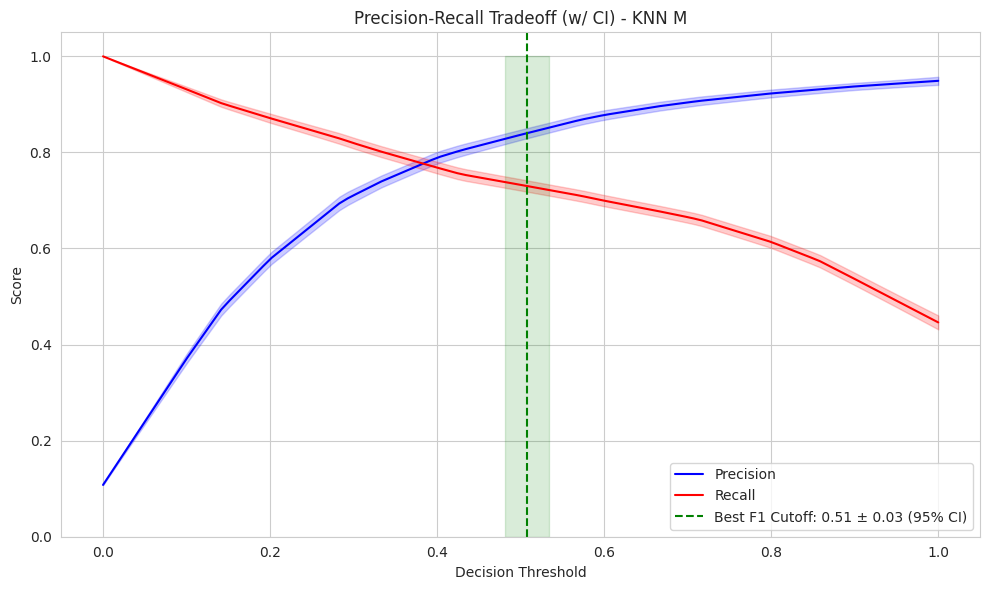

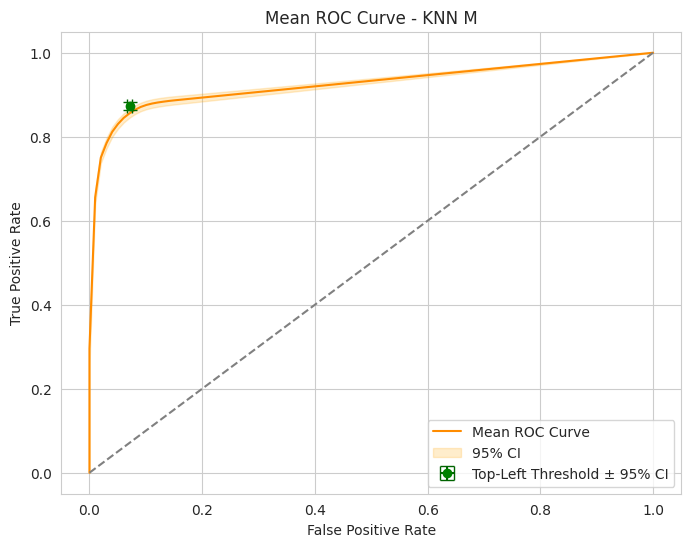


✅ Mean Top-Left Threshold (ROC): 0.23 ± 0.01 (95% CI)


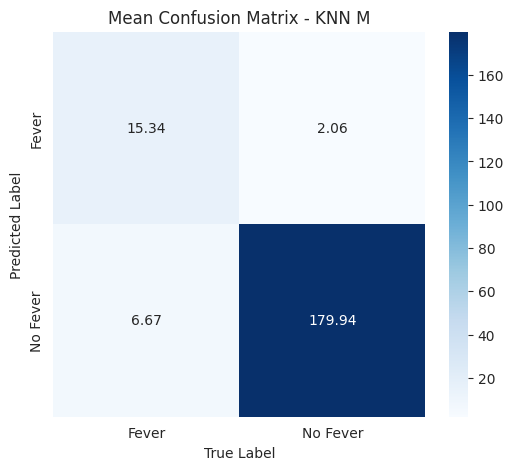

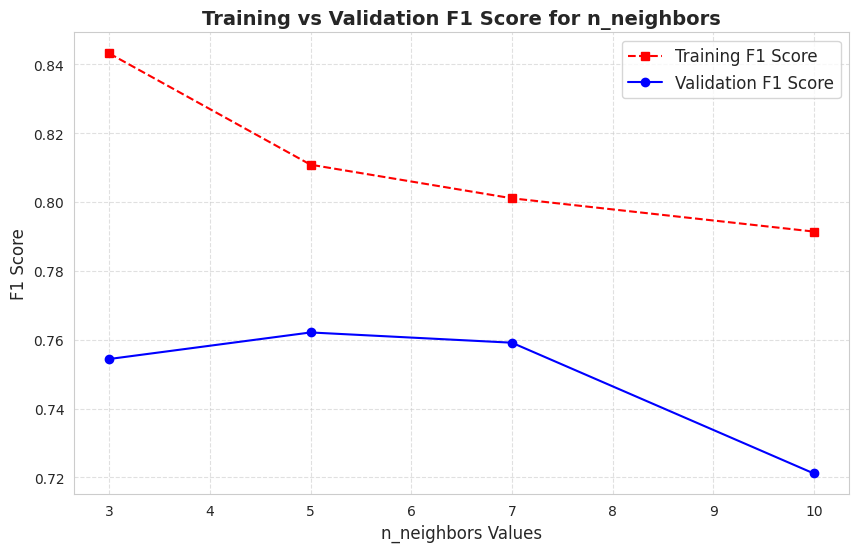

In [ ]:
knn_model = KNeighborsClassifier()
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

knn_resultsM, best_knnM = monte_carlo_cv_with_plot(
    knn_model, knn_param_grid, X, y2,
    model_name="KNN M",
    num_iterations=200
)

monte_carlo_results["KNN M"].to_csv(f"{save_path_c_m}/KNN_mccv_results.csv", index=False)
knn_resultsM.to_csv(f"{save_path_c_m}/KNN_summary.csv")


- **Best Hyperparameters:**
  - Most common: `n_neighbors = 7` (chosen 98/200 times), followed by `n_neighbors = 5` (56/200)
  - The training vs. validation F1 curve supports this — while training F1 drops with higher k, validation F1 peaks at k=5–7, confirming good generalisation at that range.

- **Mean F1 Score (Optimal Threshold = 0.51 ± 0.03):**
  - **F1 Score:** 0.776 ± 0.063

- **Precision-Recall Trade-off Discussion:**
  - Precision and recall intersect at ~0.51 — a noticeably more conservative threshold compared to Fast Mode.
  - The model achieves a strong **precision of 0.886**, which reflects very few false positives.
  - Recall (0.697) is also decent, showing improved fever detection over the Fast Mode version.

- **Mean ROC Curve and AUC Discussion:**
  - The ROC curve is solid, with **Mean AUC = 0.925 ± 0.040**.
  - ROC-optimal threshold (~0.23) would yield a more recall-heavy prediction but might reduce precision.

- **Other Metrics (at F1-optimal threshold ~0.51):**
  - **Accuracy:** 0.957 ± 0.011
  - **Precision:** 0.886 ± 0.070
  - **Recall:** 0.697 ± 0.086
  - **AUC:** 0.925 ± 0.040

- **Advantages of KNN:**
  - High precision — very few false positives
  - Reasonably good at identifying fever cases (better recall than Fast Mode)
  - Simple, intuitive algorithm with minimal assumptions

- **Disadvantages of KNN:**
  - Relatively low recall — misses more fever cases
  - Sensitive to imbalanced data and feature scaling



## 3.8 XGBoost

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.6918

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.7011

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.7262

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.6402

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.6652

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.6066

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.65

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.963          0.01     0.967    0.023           0.756   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.108        0.631       0.127    0.679   0.096


🏆 Most Common Best Hyperparameters:
1. Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 60} | Chosen: 33 out of 200 times
2. Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60} | Chosen: 32 out of 200 times
3. Params: {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 9} | Chosen: 27 out of 200 times
4. Params: {'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 3} | Chosen: 26 out of 200 times
5. Params: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 9} | Chosen: 19 out of 200 times
6. Params: {'learning_rate': 0.1, 'n_estimators': 60, 'max_depth': 9} | Chosen: 18 out of 200 times
7. Params: {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 3} | Chosen: 17 out of 200 times
8. Params: {'learning_rate': 0.05, 'n_estimators': 60, 'max_depth': 9} | Chosen: 13 out of 200 times
9. Params: {'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 9} | Chosen: 8 out of 200 times
10. Params: {'learning_rate': 0.1, 'n_estimators': 20

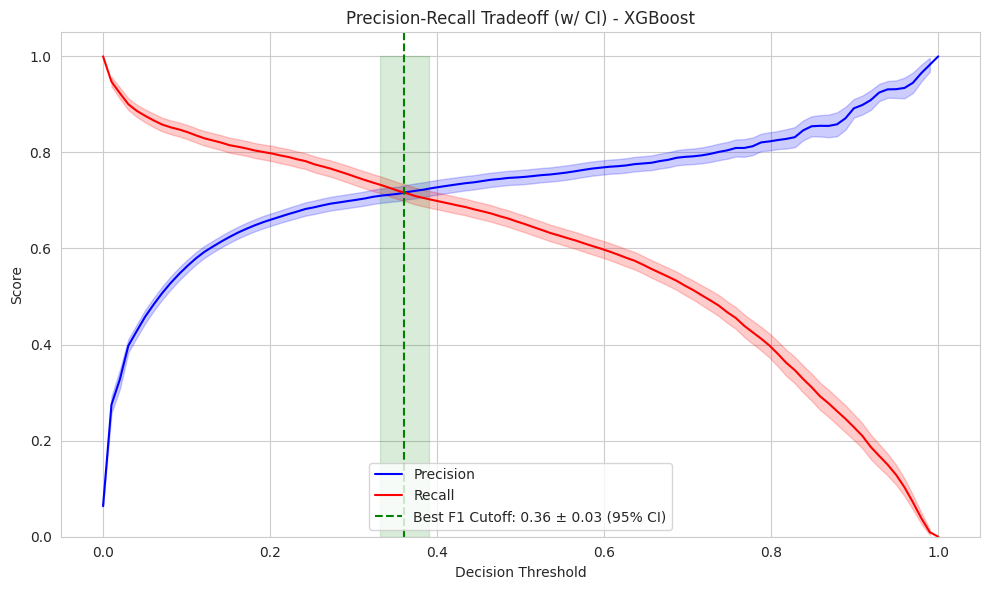

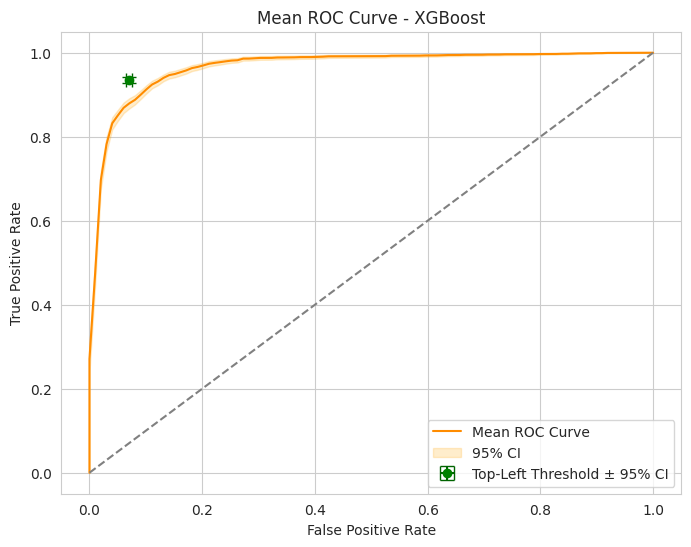


✅ Mean Top-Left Threshold (ROC): 0.10 ± 0.02 (95% CI)


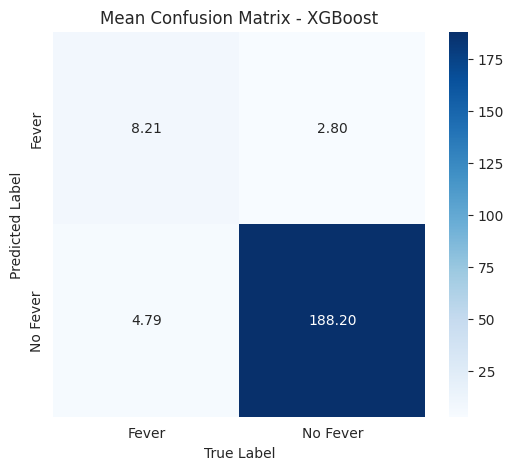

In [ ]:
xgb_param_grid = {
    "n_estimators": [60,200],  # Number of trees
    "max_depth": [3, 9],  # Tree depth
    "learning_rate": [.01, 0.05, 0.1]  # Learning rate
}
xgb_model = XGBClassifier(eval_metric="aucpr", random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

xgb_results, best_xgb = monte_carlo_cv_with_plot(
    xgb_model, xgb_param_grid, X, y,
    model_name="XGBoost",
    num_iterations=200
)

monte_carlo_results["XGBoost"].to_csv(f"{save_path_c_f}/XGBoost_mccv_results.csv", index=False)
xgb_results.to_csv(f"{save_path_c_f}/XGBoost_summary.csv")

- **Best Hyperparameters:**
  - No single dominant combination — most common configs were:
    - `learning_rate = 0.05`, `max_depth = 3`, `n_estimators = 60` (33/200)
    - `learning_rate = 0.1`, `max_depth = 3`, `n_estimators = 60` (32/200)
    - Others varied depth and number of trees — e.g., `max_depth = 9`, `n_estimators = 200`
  - This suggests that XGBoost performs well across a range of settings.

- **Mean F1 Score (Optimal Threshold = 0.36 ± 0.03):**
  - **F1 Score:** 0.679 ± 0.096

- **Precision-Recall Trade-off Discussion:**
  - Best threshold was around 0.36 — slightly more aggressive than in some other models.
  - Precision (0.756) and recall (0.631) are well-balanced, making this a reliable model for catching fever cases without too many false positives.
  - The curves are smooth and consistent.

- **Mean ROC Curve and AUC Discussion:**
  - One of the strongest ROC curves overall: **Mean AUC = 0.967 ± 0.023**
  - ROC-optimal threshold was much lower: **0.10 ± 0.02**, indicating that XGBoost would benefit from lower cutoffs to maximise sensitivity.

- **Other Metrics (at F1-optimal threshold ~0.36):**
  - **Accuracy:** 0.963 ± 0.010
  - **Precision:** 0.756 ± 0.108
  - **Recall:** 0.631 ± 0.127

- **Advantages of XGBoost:**
  - Strong performance in AUC and well-balanced precision/recall
  - Can capture complex relationships and interactions in the data
  - Usually performs well on tabular data

- **Disadvantages of XGBoost:**
  - Less interpretable than simpler models
  - Longer training time than logistic models or KNN


**Monitor Mode**


🔄 Monte Carlo Iteration 1/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.8183

🔄 Monte Carlo Iteration 2/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.7799

🔄 Monte Carlo Iteration 3/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.7696

🔄 Monte Carlo Iteration 4/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.7935

🔄 Monte Carlo Iteration 89/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.8138

🔄 Monte Carlo Iteration 90/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.8006

🔄 Monte Carlo Iteration 91/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
✅ Best Cross-Validation F1 Score: 0.7918



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.7948

🔄 Monte Carlo Iteration 171/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.7954

🔄 Monte Carlo Iteration 172/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score: 0.8315

🔄 Monte Carlo Iteration 173/200...

🔍 Hyperparameter tuning for {'n_estimators': [60, 200], 'max_depth': [3, 9], 'learning_rate': [0.01, 0.05, 0.1]} (Optimizing F1-Score)...
✅ Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
✅ Best Cross-Validation F1 Score:

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.955         0.013     0.968    0.021           0.838   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.085        0.735       0.095    0.778   0.065


🏆 Most Common Best Hyperparameters:
1. Params: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3} | Chosen: 33 out of 200 times
2. Params: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 9} | Chosen: 28 out of 200 times
3. Params: {'learning_rate': 0.1, 'n_estimators': 60, 'max_depth': 9} | Chosen: 27 out of 200 times
4. Params: {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 9} | Chosen: 24 out of 200 times
5. Params: {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 3} | Chosen: 23 out of 200 times
6. Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60} | Chosen: 23 out of 200 times
7. Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 60} | Chosen: 17 out of 200 times
8. Params: {'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 3} | Chosen: 12 out of 200 times
9. Params: {'learning_rate': 0.05, 'n_estimators': 60, 'max_depth': 9} | Chosen: 9 out of 200 times
10. Params: {'learning_rate': 0.01, 'n_estimators': 20

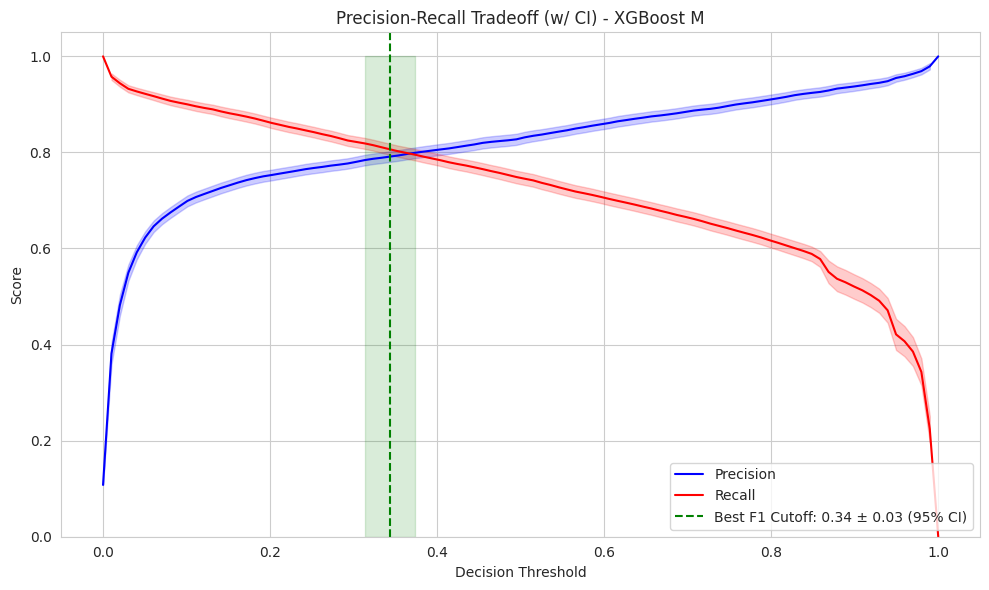

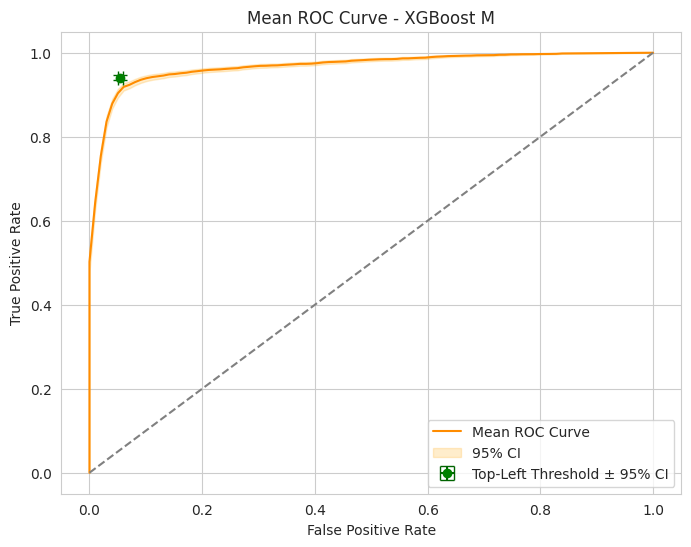


✅ Mean Top-Left Threshold (ROC): 0.12 ± 0.01 (95% CI)


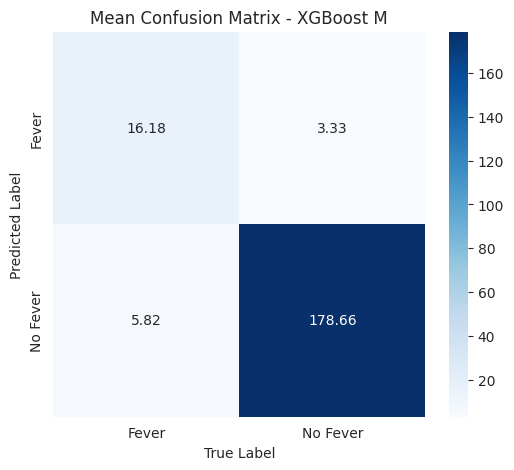

In [ ]:
xgb_model = XGBClassifier(eval_metric="aucpr", random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

xgb_resultsM, best_xgbM = monte_carlo_cv_with_plot(
    xgb_model, xgb_param_grid, X, y2,
    model_name="XGBoost M",
    num_iterations=200
)

monte_carlo_results["XGBoost M"].to_csv(f"{save_path_c_m}/XGBoost_mccv_results.csv", index=False)
xgb_resultsM.to_csv(f"{save_path_c_m}/XGBoost_summary.csv")

- **Best Hyperparameters:**
  - Most commonly selected:
    - `learning_rate = 0.1`, `n_estimators = 200`, `max_depth = 3` (33/200)
    - Variations with deeper trees (`max_depth = 9`) also performed well

- **Mean F1 Score (Optimal Threshold = 0.34 ± 0.03):**
  - **F1 Score:** 0.778 ± 0.065

- **Precision-Recall Trade-off Discussion:**
  - F1-optimal threshold is slightly lower than for Fast Mode (0.34 vs. 0.36), favouring slightly more recall.
  - Both **precision (0.838)** and **recall (0.735)** are high, making this one of the best-balanced models overall.
  - Precision and recall curves are smooth with a clear crossing point, suggesting consistent performance across folds.

- **Mean ROC Curve and AUC Discussion:**
  - Outstanding ROC performance: **Mean AUC = 0.968 ± 0.021**
  - ROC-optimal threshold was even lower at **0.12 ± 0.01**, which would favour recall even more if prioritised.

- **Other Metrics (at F1-optimal threshold ~0.34):**
  - **Accuracy:** 0.955 ± 0.013
  - **Precision:** 0.838 ± 0.085
  - **Recall:** 0.735 ± 0.095

- **Advantages of XGBoost:**
  - Consistently high precision, recall, and F1 — among the top Monitor Mode performers
  - Handles non-linearities, interactions, and feature importance naturally
  - Excellent AUC and stable cross-validation performance

- **Disadvantages of XGBoost:**
  - Slightly longer training time and complexity compared to simpler models
  - Less interpretable than logistic regression or decision trees


## 3.9 Comparing Results

Load in the results

In [8]:
def load_mccv_results(folder_path, keyword="mccv"):
    mccv_files = [f for f in os.listdir(folder_path) if keyword in f and f.endswith(".csv")]
    results_list = []

    for fname in mccv_files:
        model_name = re.split(r"_mc|_s", fname)[0]
        df = pd.read_csv(os.path.join(folder_path, fname))
        df["model"] = model_name
        results_list.append(df)

    combined_df = pd.concat(results_list, ignore_index=True)
    return combined_df


In [9]:
# For classification results - Monte Carlo
Fast_results_df = load_mccv_results(save_path_c_f)
Monitor_results_df = load_mccv_results(save_path_c_m)
print("Fast Mode")
display(Fast_results_df)
print("Monitor Mode")
display(Monitor_results_df)

Fast Mode


Iteration  Accuracy       AUC  Precision    Recall  F1-Score  \
0             1  0.960784  0.951269   1.000000  0.384615  0.555556   
1             2  0.955882  0.882803   0.700000  0.538462  0.608696   
2             3  0.950980  0.918244   0.714286  0.384615  0.500000   
3             4  0.965686  0.958518   0.875000  0.538462  0.666667   
4             5  0.946078  0.903343   0.666667  0.307692  0.421053   
...         ...       ...       ...        ...       ...       ...   
1295         96  0.955882  0.967378   0.750000  0.461538  0.571429   
1296         97  0.955882  0.946436   0.700000  0.538462  0.608696   
1297         98  0.970588  0.969392   0.769231  0.769231  0.769231   
1298         99  0.975490  0.948047   0.900000  0.692308  0.782609   
1299        100  0.960784  0.981877   0.727273  0.615385  0.666667   

                    model  
0     logistic_regression  
1     logistic_regression  
2     logistic_regression  
3     logistic_regression  
4     logistic_regression  
...                   ...  
1295    final_elastic_net  
1296    final_elastic_net  
1297    final_elastic_net  
1298    final_elastic_net  
1299    final_elastic_net  

[1300 rows x 7 columns]

Monitor Mode


Iteration  Accuracy       AUC  Precision    Recall  F1-Score  \
0             1  0.941176  0.921828   0.727273  0.727273  0.727273   
1             2  0.926471  0.928072   0.769231  0.454545  0.571429   
2             3  0.955882  0.950300   0.933333  0.636364  0.756757   
3             4  0.970588  0.978272   1.000000  0.727273  0.842105   
4             5  0.950980  0.936563   0.928571  0.590909  0.722222   
...         ...       ...       ...        ...       ...       ...   
1195        196  0.960784  0.989261   0.888889  0.727273  0.800000   
1196        197  0.975490  0.990260   0.947368  0.818182  0.878049   
1197        198  0.970588  0.994006   0.863636  0.863636  0.863636   
1198        199  0.970588  0.962787   0.833333  0.909091  0.869565   
1199        200  0.941176  0.986513   0.727273  0.727273  0.727273   

                    model  
0     logistic_regression  
1     logistic_regression  
2     logistic_regression  
3     logistic_regression  
4     logistic_regression  
...                   ...  
1195              XGBoost  
1196              XGBoost  
1197              XGBoost  
1198              XGBoost  
1199              XGBoost  

[1200 rows x 7 columns]

In [ ]:
# For classification results - Summary
Fast_results_df_summary = load_mccv_results(save_path_c_f, "summary").iloc[:, 1:]
Monitor_results_df_summary = load_mccv_results(save_path_c_m, "summary").iloc[:, 1:]

print("Fast Mode")
print(tabulate(round(Fast_results_df_summary,3), headers="keys", tablefmt="fancy_grid", showindex=False))
print("Monitor Mode")
print(tabulate(round(Monitor_results_df_summary,3), headers="keys", tablefmt="fancy_grid", showindex=False))


Fast Mode
╒═════════════════╤════════════════╤════════════╤═══════════╤══════════════════╤═════════════════╤═══════════════╤══════════════╤═══════════╤══════════╤═════════════════════╕
│   Mean Accuracy │   Std Accuracy │   Mean AUC │   Std AUC │   Mean Precision │   Std Precision │   Mean Recall │   Std Recall │   Mean F1 │   Std F1 │ model               │
╞═════════════════╪════════════════╪════════════╪═══════════╪══════════════════╪═════════════════╪═══════════════╪══════════════╪═══════════╪══════════╪═════════════════════╡
│           0.96  │          0.01  │      0.94  │     0.037 │            0.788 │           0.129 │         0.526 │        0.131 │     0.619 │    0.111 │ logistic_regression │
├─────────────────┼────────────────┼────────────┼───────────┼──────────────────┼─────────────────┼───────────────┼──────────────┼───────────┼──────────┼─────────────────────┤
│           0.965 │          0.01  │      0.965 │     0.021 │            0.796 │           0.114 │         0.627 │ 

#### Performance Metrics

In [ ]:
def plot_monte_carlo_boxplots(monte_carlo_df, model_name="Model"):
    """
    Plots box plots for Accuracy, AUC, Precision, Recall, and F1-Score from Monte Carlo results.

    Args:
        monte_carlo_df (pd.DataFrame): DataFrame of Monte Carlo results for a given model.
        model_name (str): Name of the model (used in the title).
    """
    if not isinstance(monte_carlo_df, pd.DataFrame):
        print("Input must be a pandas DataFrame.")
        return

    if not {"Accuracy", "AUC", "Precision", "Recall", "F1-Score"}.issubset(monte_carlo_df.columns):
        print("DataFrame must include: Accuracy, AUC, Precision, Recall, and F1-Score columns.")
        return

    melted = monte_carlo_df.melt(
        id_vars="Iteration",
        value_vars=["Accuracy", "AUC", "Precision", "Recall", "F1-Score"],
        var_name="Metric",
        value_name="Score"
    )

    # Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Metric", y="Score", data=melted, palette="Set2", width=0.5, showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})

    plt.title(f"Monte Carlo Performance Distribution - {model_name}", fontsize=15, fontweight='bold')
    plt.xlabel("Performance Metric", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(.3, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


XGBoost - Fast Mode


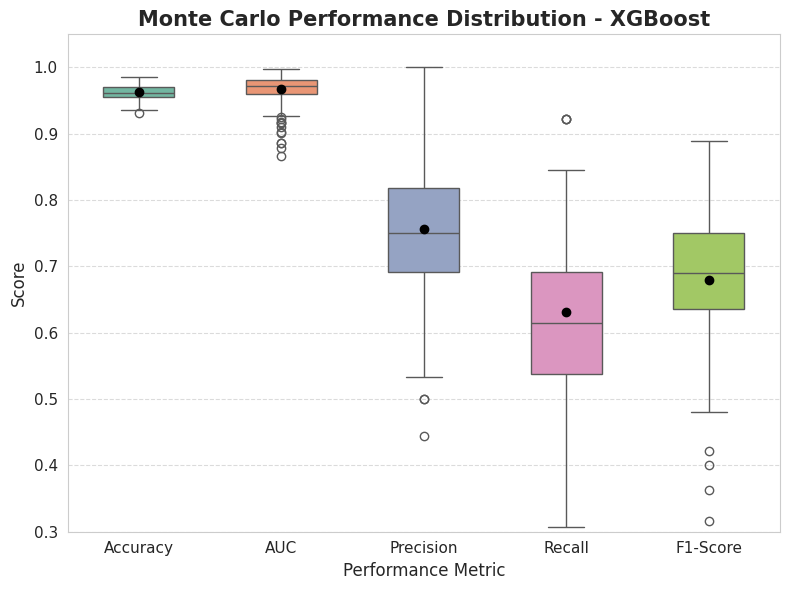

---------------------------------------------------------------------------------------------------------
XGBoost - Monitor Mode


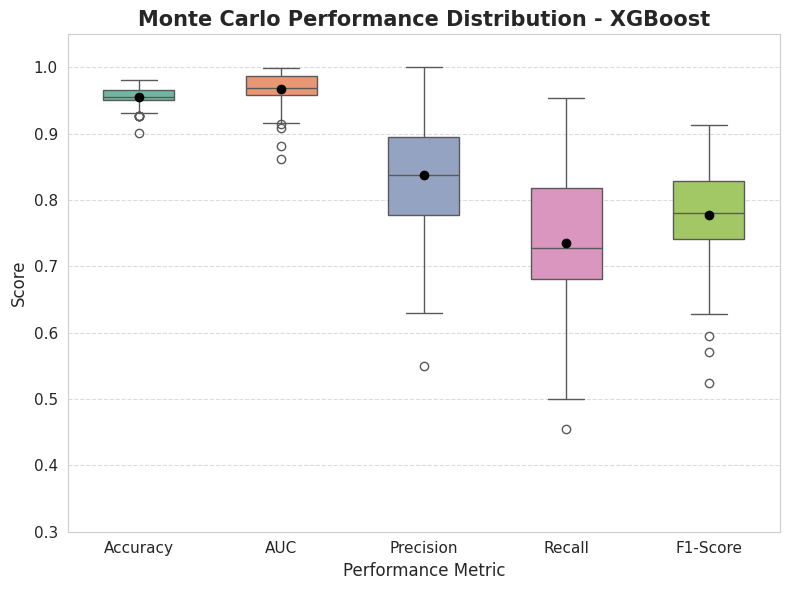

In [ ]:
print("XGBoost - Fast Mode")
plot_monte_carlo_boxplots(
    monte_carlo_df=Fast_results_df[Fast_results_df["model"] == "XGBoost"],
    model_name="XGBoost"
)

print("---------------------------------------------------------------------------------------------------------")


print("XGBoost - Monitor Mode")
plot_monte_carlo_boxplots(
    monte_carlo_df=Monitor_results_df[Monitor_results_df["model"] == "XGBoost"],
    model_name="XGBoost"
)


In [ ]:
def plot_metric_boxplot_comparison(monte_carlo_results_dict, metric_name="F1-Score"):
    """
    Plots a boxplot comparing a specified metric across multiple classification models.

    Args:
        monte_carlo_results_dict (dict): Dictionary of {model_name: DataFrame}
        metric_name (str): Column name of the metric to compare (e.g., 'F1-Score', 'Accuracy')
    """
    metric_data = []

    for model_name, df in monte_carlo_results_dict.items():
        if metric_name not in df.columns:
            print(f"⚠️ Skipping {model_name} (no '{metric_name}' column found).")
            continue

        for score in df[metric_name]:
            metric_data.append({"Model": model_name, "Score": score})

    if not metric_data:
        print(f"❌ No valid '{metric_name}' data found to plot.")
        return

    combined_df = pd.DataFrame(metric_data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Model", y="Score", data=combined_df, palette="Set2", showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})
    plt.title(f"{metric_name} Distribution by Model (Monte Carlo CV)", fontsize=14, fontweight="bold")
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


**Fast mode**

Fast Mode


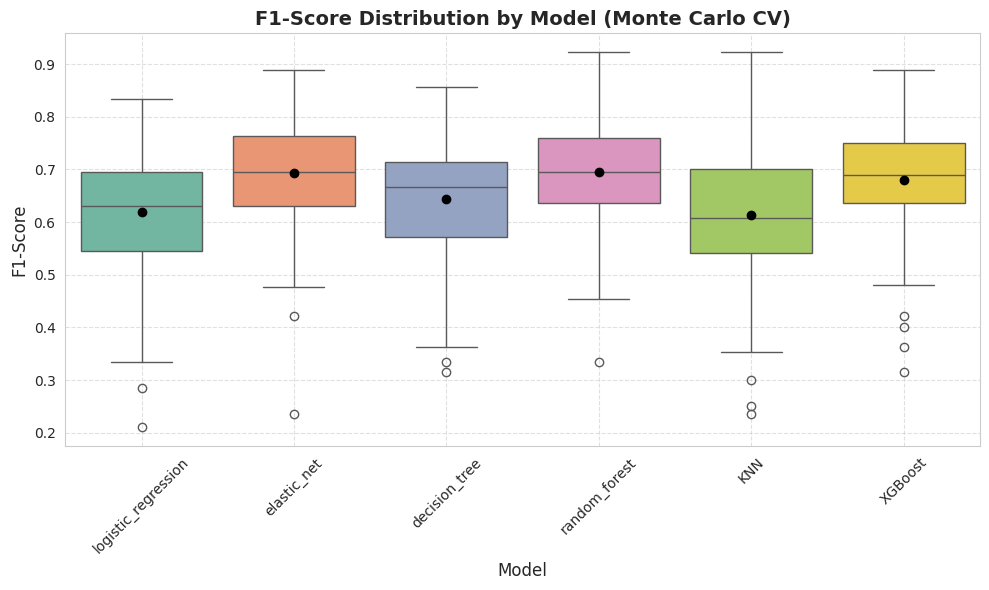

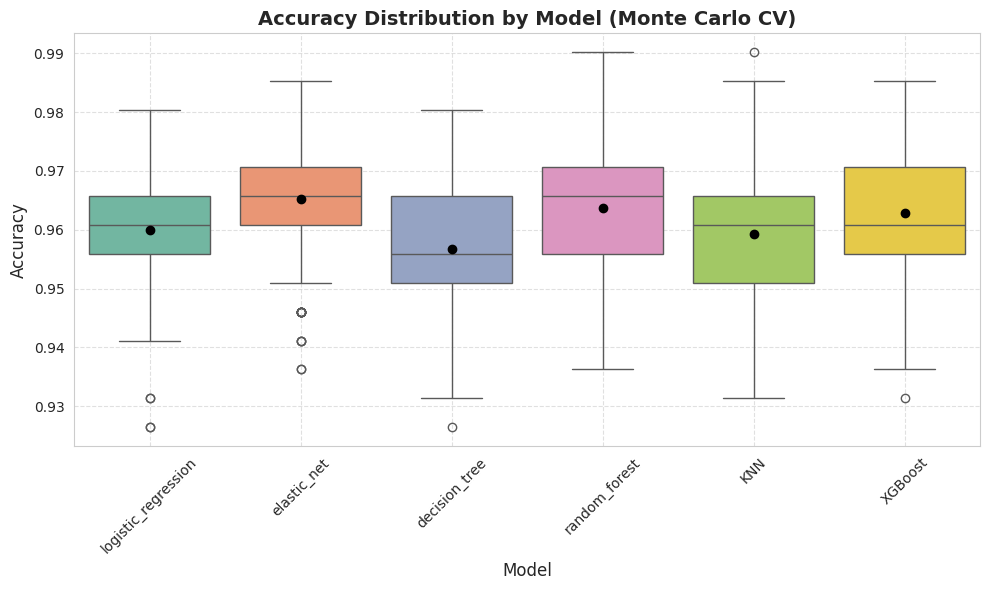

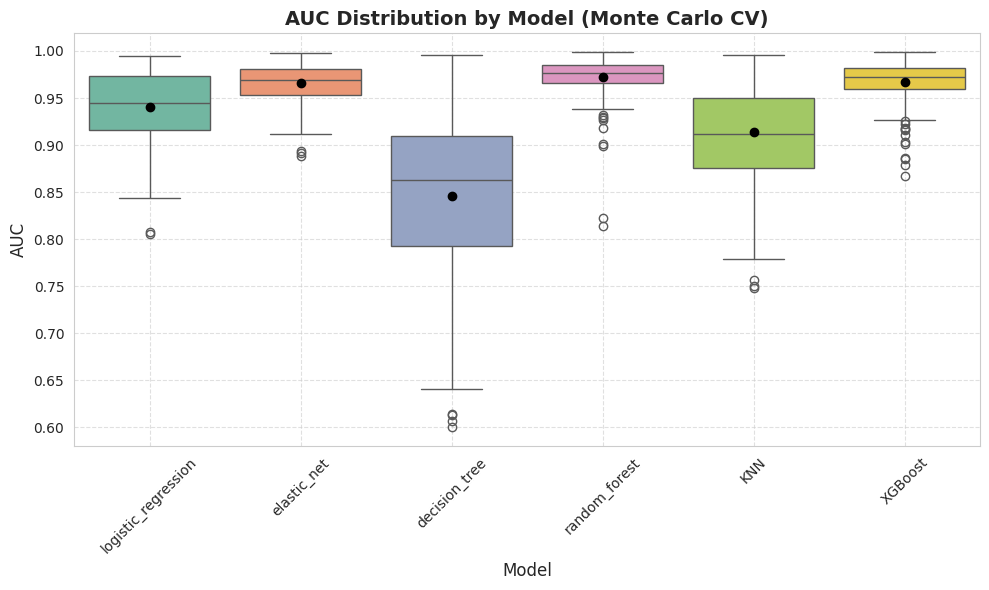

In [ ]:
model_results_dict = {
    model: Fast_results_df[Fast_results_df["model"] == model]
    for model in Fast_results_df["model"].unique()
}

# Plot any metric
print("Fast Mode")
plot_metric_boxplot_comparison(model_results_dict, metric_name="F1-Score")
plot_metric_boxplot_comparison(model_results_dict, metric_name="Accuracy")
plot_metric_boxplot_comparison(model_results_dict, metric_name="AUC")


**Monitor mode**

Monitor Mode


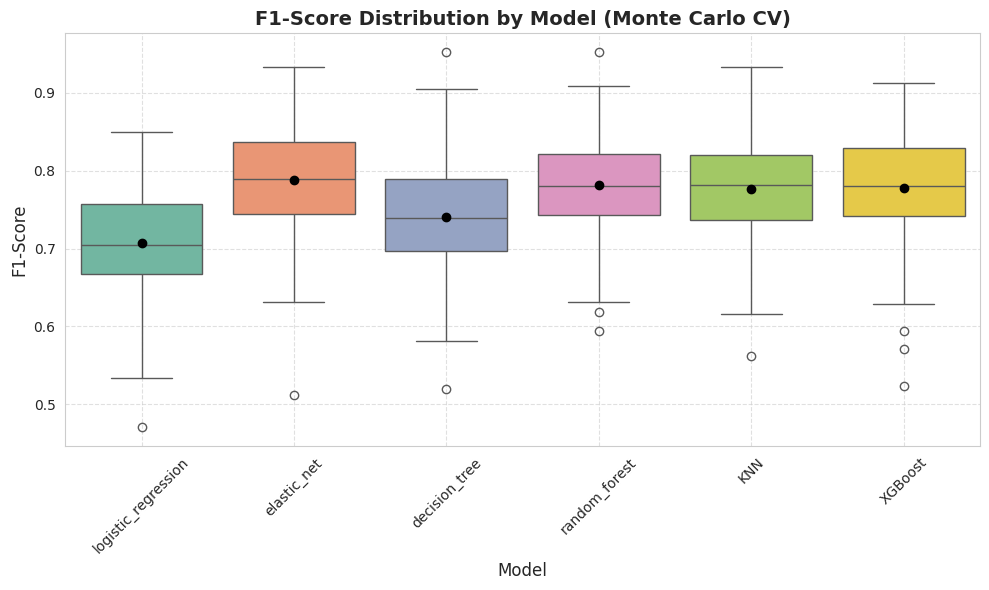

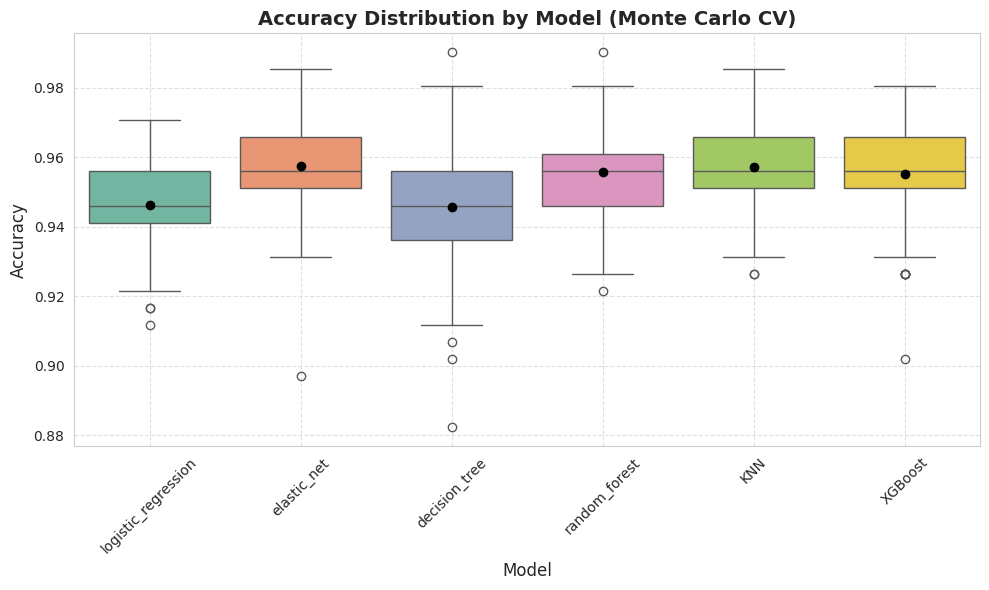

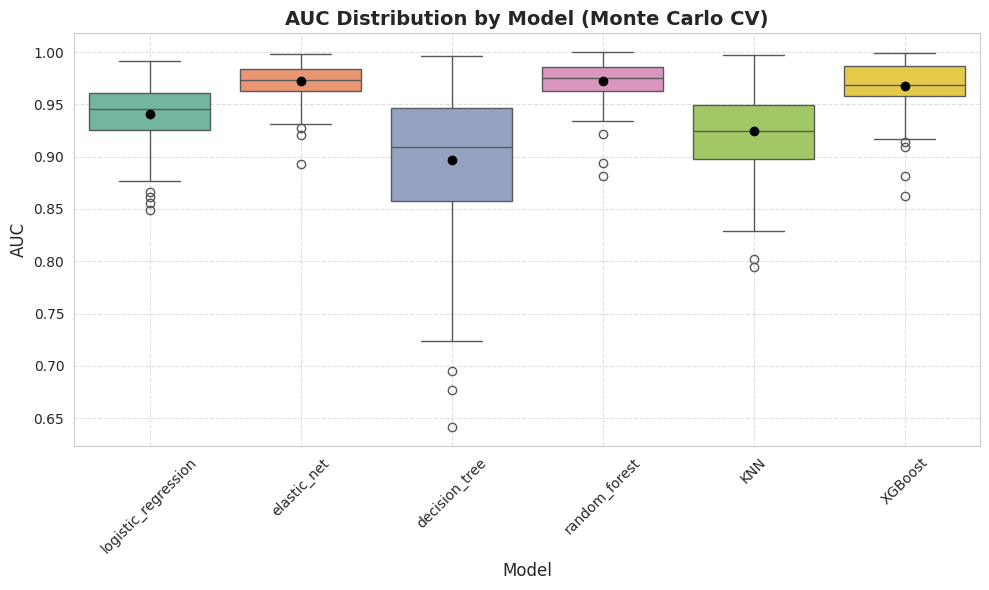

In [ ]:
model_results_dictM = {
    model: Monitor_results_df[Monitor_results_df["model"] == model]
    for model in Monitor_results_df["model"].unique()
}

# Plot any metric
print("Monitor Mode")
plot_metric_boxplot_comparison(model_results_dictM, metric_name="F1-Score")
plot_metric_boxplot_comparison(model_results_dictM, metric_name="Accuracy")
plot_metric_boxplot_comparison(model_results_dictM, metric_name="AUC")

### Model Selection

Given the imbalanced dataset, model selection was based primarily on F1-score, which balances both precision and recall. This is important in medical applications, where false negatives (failing to detect a fever) can have more serious consequences than false positives. Accuracy, though reported, was not used for model selection, as even a naive model predicting the majority class could achieve high accuracy (Baseline Fast Mode = 0.936, Monitor Mode = 0.891).

Model selection was performed independently for each classification target — Fast Mode (aveOralF) and Monitor Mode (aveOralM) — using results from 200 Monte Carlo cross-validation (MCCV) iterations to ensure stable results. The primary metrics considered were mean F1-score and standard deviation, with additional attention given to interpretability and runtime efficiency.

**Fast Mode - Classification**

For the classification of fever status based on Fast Mode oral temperature (aveOralF), six models were evaluated using 200 MCCV iterations. The focus was placed on F1-score due to the imbalanced nature of the target variable, where relatively fewer individuals met the fever threshold of 37.5°C. F1-score provides a balanced view of both precision and recall, which is especially critical in healthcare settings to avoid misclassifying febrile patients.

Across all models, Random Forest delivered the highest mean F1-score (0.695), followed closely by Elastic Net (0.692) and XGBoost (0.679). These models consistently outperformed others such as Logistic Regression (0.619), KNN (0.614), and Decision Tree (0.643). Notably, Random Forest achieved high precision (0.755) and strong recall (0.659), suggesting it identified a large proportion of fever cases with relatively few false positives.

While Random Forest may be the top choice purely from a performance standpoint, model selection in this context should consider other important factors. For instance:

- Elastic Net, despite a slightly lower F1-score, offers two major advantages: it is more interpretable, allowing clinicians or public health professionals to understand the factors influencing predictions, and it is computationally efficient, training faster than ensemble models. This is evident from the tight F1-score distribution shown in Figure the Fast Mode boxplot above, where Elastic Net has low variance across MCCV runs.

- XGBoost also delivered consistently strong performance and would be a viable option in settings where a non-linear model is desired and computational cost is not a major limitation.

Thus, the choice of model in Fast Mode could be tailored to the intended use case:


1. If maximum predictive performance is the top priority and interpretability is secondary, Random Forest is recommended.

2. If transparency and deployment efficiency are critical (e.g. in mobile health apps), Elastic Net is a good alternative, with minimal performance trade-off.

3. If handling complex, non-linear feature interactions is necessary, XGBoost may be favored.

The small difference in F1-score between the top models highlights that multiple valid choices exist, and the final decision should align with real-world deployment requirements, not just metrics.

**Monitor Mode - Classification**

For the classification task based on Monitor Mode oral temperature (aveOralM), a similar evaluation was conducted using 200 MCCV iterations. Once again, F1-score was the primary metric, supported by recall, precision, and standard deviation to assess stability.

In this setting, Elastic Net delivered the highest mean F1-score (0.787), narrowly outperforming Random Forest (0.781), XGBoost (0.778), and KNN (0.776). All four models demonstrated strong recall (Elastic Net: 0.738, Random Forest: 0.738, XGBoost: 0.735, KNN: 0.697) and precision above 0.83, suggesting they were highly competent at identifying fever cases with minimal false positives.

The performance gap between models was even tighter in Monitor Mode compared to Fast Mode. This reinforces the idea that several models are equally valid from a predictive performance perspective. However, key trade-offs still influence the final recommendation:

- Elastic Net again stands out due to its combination of high precision, strong F1-score, low variance, and interpretability. This makes it especially well-suited for clinical environments where explainability and consistency are essential.

- Random Forest performed nearly identically in terms of F1-score but, being an ensemble model, is less interpretable and more computationally demanding. However, it may be preferred in systems prioritising slightly better generalization.

- KNN, although simpler, achieved a competitive F1-score (0.776), indicating that even lightweight models can be effective under certain clinical data settings.

- XGBoost maintained strong results and, like in Fast Mode, is a strong candidate when capturing non-linear patterns is important.

Overall, for Monitor Mode, Elastic Net is recommended due to its balance of predictive strength, reliability, and practical deployment advantages.


**Fast vs Monitor Mode**

This classification task also looks at the use of fast mode versus monitor mode.for predicting oral body temperature and fever status using sensor data derived from thermal infrared (IR) facial images. Fast Mode represents quicker scans that may be noisier or more affected by external conditions, while Monitor Mode reflects longer, more stable measurements.

The tighter F1-score distributions and generally stronger model agreement in Monitor Mode suggest that higher-quality input data returns better classification reliability. However, both modes showed strong results, demonstrating the feasibility of using non-contact IR sensors to approximate oral temperatures and detect fever risk with high accuracy — a valuable application in public health and clinical triage scenarios.



### Feature Importance

To understand which features were most influential in predicting the target, I retrained the final Elastic Net model using the best hyperparameters found during Monte Carlo Cross-Validation (MCCV), and extracted the feature mean coefficients (100 iterations) from this final model. Features consistently retained across runs would be considered more reliable indicators of importance.


🔄 Monte Carlo Iteration 1/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 2/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 3/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 4/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 5/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 6/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 7/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 8/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 9/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 10/

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



🔄 Monte Carlo Iteration 89/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 90/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 91/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 92/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 93/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 94/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 95/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 96/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iteration 97/100...

🚀 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

🔄 Monte Carlo Iter

Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.967         0.009     0.965    0.021           0.809   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.101        0.638       0.127    0.704   0.097

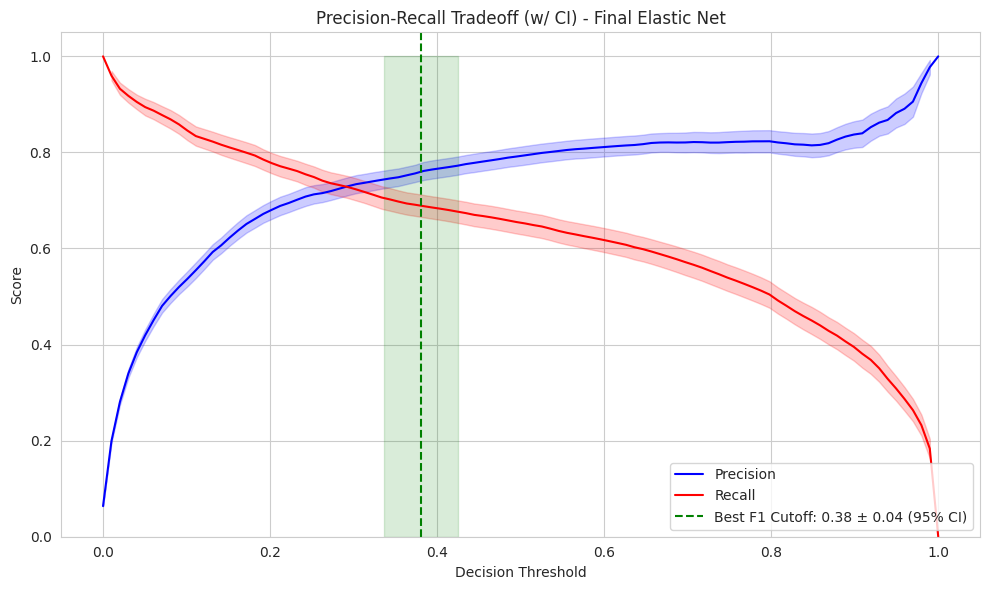

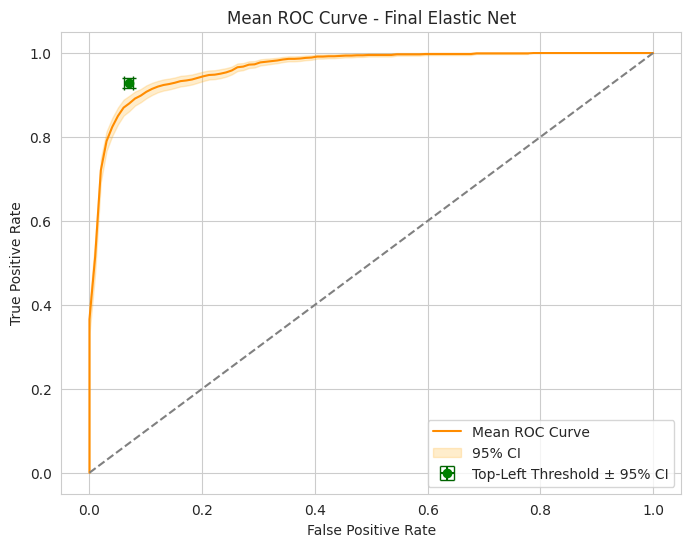


✅ Mean Top-Left Threshold (ROC): 0.10 ± 0.02 (95% CI)


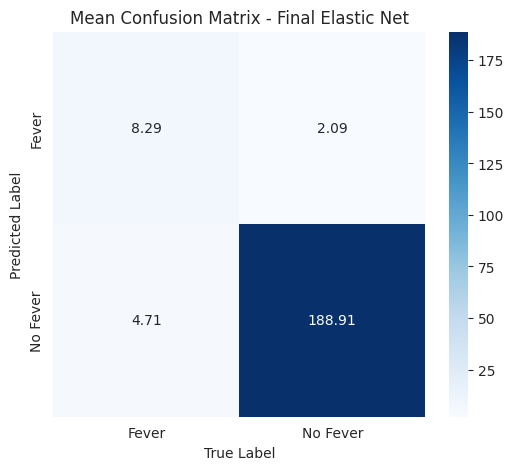

In [ ]:
final_elastic_model = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.1,       # Set directly
    C=1.0,              # Set directly
    random_state=2025,
    max_iter=8000
)
final_elastic_results, final_best_elastic = monte_carlo_cv_with_plot(
    final_elastic_model,
    param_grid=None,
    X=X,
    y=y,
    model_name="Final Elastic Net",
    num_iterations=100
)
final_elastic_results.to_csv(f"{save_path_c_f}/final_elastic_net_summary.csv")
monte_carlo_results["Final Elastic Net"].to_csv(f"{save_path_c_f}/final_elastic_net_mccv_results.csv", index=False)

Functions to visualise feature importance for tree based methods and report coefficients for more statistical models like Logistic regression and elastic net reguralisation

In [ ]:
def summarize_feature_importance(model_name, top_n=25):
    if model_name not in feature_importance_dict:
        print(f"❌ No feature importance data available for '{model_name}'.")
        return

    model = model_results[model_name]["model"]
    # Get expected number of features from the model
    expected_n_features = len(model.feature_names_in_)

    # Stack only valid runs
    valid_runs = []
    for i, run in enumerate(feature_importance_dict[model_name]):
        arr = np.asarray(run)
        if arr.shape[0] == expected_n_features:
            valid_runs.append(arr)
        else:
            print(f"Skipping run {i}: expected {expected_n_features} features, got {arr.shape[0]}, likely due to one hot encoded categorical varibale did not appear in test set for this run")

    if len(valid_runs) == 0:
        print("❌ No valid runs found with matching feature count.")
        return

    importances = np.vstack(valid_runs)
    feature_names = model.feature_names_in_

    # Determine if model uses coefficients or feature_importances_
    if hasattr(model, "coef_"):
        # Coefficient-based model (e.g., Logistic Regression)
        import_type = "Coefficient"
        means = importances.mean(axis=0)
        stds = importances.std(axis=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            cis = st.t.interval(0.95, df=len(importances)-1, loc=means, scale=st.sem(importances, axis=0))
    else:
        # Tree-based model (e.g., Random Forest, XGBoost)
        import_type = "Feature Importance"
        means = importances.mean(axis=0)
        stds = importances.std(axis=0)
        # Confidence intervals for importances aren't usually reported, but you can still estimate them
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            cis = st.t.interval(0.95, df=len(importances)-1, loc=means, scale=st.sem(importances, axis=0))

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        f"Mean {import_type}": means,
        "Std Dev": stds,
        "95% CI Lower": cis[0],
        "95% CI Upper": cis[1]
    })

    importance_df = importance_df.reindex(importance_df[f"Mean {import_type}"].abs().sort_values(ascending=False).index)
    display(importance_df.head(top_n))
    return importance_df

def plot_feature_importance_barplot(
    importance_df,
    top_n=25,
    model_name="",
    importance_col="Mean Coefficient",
    show_sign_legend=True,
    show_signed_axis=True
):
    # Select and sort top features
    top_features = importance_df.copy()
    top_features["Abs Import"] = importance_df[importance_col].abs()
    top_features = top_features.sort_values("Abs Import", ascending=False).head(top_n)

    # Use gradient coloring
    norm = Normalize(vmin=top_features["Abs Import"].min(), vmax=top_features["Abs Import"].max())
    cmap = plt.cm.viridis
    colors = [cmap(norm(val)) for val in top_features["Abs Import"]]

    # Set style
    plt.figure(figsize=(10, max(6, 0.4 * top_n)))
    sns.set(style="whitegrid", font_scale=1.2)

    # Plot bar chart
    barplot = plt.barh(
        y=top_features["Feature"],
        width=top_features[importance_col],
        color=colors,
        edgecolor="black"
    )

    # Add error bars
    for i, row in top_features.iterrows():
        plt.errorbar(
            x=row[importance_col],
            y=i,
            xerr=[[row[importance_col] - row["95% CI Lower"]],
                  [row["95% CI Upper"] - row[importance_col]]],
            fmt="none",
            ecolor="black",
            elinewidth=1,
            capsize=3,
            capthick=1
        )

    # Axis, labels, title
    plt.title(f"Top {top_n} Feature Importances\n({model_name})", fontsize=16, weight="bold", pad=20)
    plt.xlabel(importance_col.replace("Mean ", ""), fontsize=13)
    plt.ylabel("Feature", fontsize=13)
    plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Axis line at 0 (only for coefficients)
    if show_signed_axis:
        plt.axvline(0, color='black', linestyle='--', linewidth=1)

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label("Absolute Importance", fontsize=12)

    # Legend only for signed models
    if show_sign_legend:
        # You can keep or improve this if you reintroduce hue='Sign'
        plt.legend(title="Effect Direction", loc="best", frameon=True)
    else:
        plt.gca().legend().set_visible(False)

    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

    plt.show()

def plot_feature_importance_barplot(
    importance_df,
    top_n=25,
    model_name="",
    importance_col="Mean Coefficient",
    show_sign_legend=True,
    show_signed_axis=True
):
    # Clean feature names
    importance_df = importance_df.copy()
    importance_df["Feature"] = importance_df["Feature"].apply(clean_feature_name)

    # Select and sort top features
    importance_df["Abs Import"] = importance_df[importance_col].abs()
    top_features = importance_df.sort_values("Abs Import", ascending=False).head(top_n)
    top_features = top_features.reset_index(drop=True)

    plt.figure(figsize=(10, max(6, 0.4 * top_n)))
    sns.set(style="whitegrid", font_scale=1.2)

    # Coefficient-based model plotting section
    if show_signed_axis:
        # Assign signs and colors
        top_features["Sign"] = top_features[importance_col].apply(lambda x: "Positive" if x >= 0 else "Negative")
        palette = {"Positive": "#0072B2", "Negative": "#D55E00"}

        # Sort features explicitly and reverse order for plotting (largest at top)
        plot_order = top_features.sort_values("Abs Import", ascending=True)["Feature"]

        barplot = sns.barplot(
            data=top_features,
            x=importance_col,
            y="Feature",
            hue="Sign",
            dodge=False,
            palette=palette,
            orient="h",
            errorbar=None,
            order=plot_order
        )

        # Add error bars correctly aligned to bar positions
        for feature_name in plot_order:
            row = top_features[top_features["Feature"] == feature_name].iloc[0]
            y_pos = list(plot_order).index(feature_name)

            plt.errorbar(
                x=row[importance_col],
                y=y_pos,
                xerr=[[row[importance_col] - row["95% CI Lower"]],
                      [row["95% CI Upper"] - row[importance_col]]],
                fmt="none",
                ecolor="black",
                elinewidth=1,
                capsize=3,
                capthick=1
            )

        if show_sign_legend:
            plt.legend(title="Effect Direction", loc="best", frameon=True)
        plt.axvline(0, color='black', linestyle='--', linewidth=1)


    else:
        # Tree-based model (e.g. XGBoost)
        norm = Normalize(vmin=top_features["Abs Import"].min(), vmax=top_features["Abs Import"].max())
        cmap = plt.cm.viridis
        colors = [cmap(norm(val)) for val in top_features["Abs Import"]]

        for i, (feature, val) in enumerate(zip(top_features["Feature"], top_features[importance_col])):
            plt.barh(
                y=i,
                width=val,
                color=colors[i],
                edgecolor="black",
                height=0.7
            )
            # Add value labels only for tree-based
            plt.text(
                x=val + 0.001,
                y=i,
                s=f"{val:.3f}",
                va="center",
                fontsize=10,
                color="black"
            )

        plt.yticks(ticks=range(len(top_features)), labels=top_features["Feature"])

    # Final styling
    plt.title(f"Top {top_n} Feature Importance\n({model_name})", fontsize=16, weight="bold", pad=20)
    plt.xlabel(importance_col.replace("Mean ", ""), fontsize=13)
    plt.ylabel("Feature", fontsize=13)
    plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.show()

def plot_model_importance(model_name, top_n=25):
    """
    Wrapper to summarize and plot feature importance for a given model,
    adapting the plot style depending on whether the model uses coefficients or feature importances.

    Args:
        model_name (str): Key from model_results and feature_importance_dict
        top_n (int): Number of top features to visualize
    """
    if model_name not in feature_importance_dict:
        print(f"No feature importance data available for '{model_name}'.")
        return

    model = model_results[model_name]["model"]

    # Determine importance type and summarize
    importance_df = summarize_feature_importance(model_name, top_n=top_n)
    if importance_df is None:
        return

    # Choose style depending on model type
    if hasattr(model, "coef_"):
        # Coefficient-based
        importance_col = "Mean Coefficient"
        show_sign_legend = True
        show_signed_axis = True
    else:
        # Tree-based: XGBoost, RandomForest, etc.
        importance_col = "Mean Feature Importance"
        show_sign_legend = False
        show_signed_axis = False

    # Plot
    plot_feature_importance_barplot(
        importance_df=importance_df,
        top_n=top_n,
        model_name=model_name,
        importance_col=importance_col,
        show_sign_legend=show_sign_legend,
        show_signed_axis=show_signed_axis
    )
def clean_feature_name(name):
    # Remove prefixes like 'cat__' or 'num__'
    for prefix in ["cat__", "num__", "ohe__"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    # Replace underscores with space and capitalize words
    return name.replace("_", " ").title()


Skipping run 87: expected 43 features, got 42, likely due to one hot encoded categorical varibale did not appear in test set for this run


Feature  Mean Coefficient   Std Dev  95% CI Lower  \
19            num__canthi4Max1          0.750097  0.153450      0.719336   
41  cat__Ethnicity_Multiracial          0.749984  0.232251      0.703426   
18             num__canthiMax1          0.693166  0.156351      0.661823   
42        cat__Ethnicity_White         -0.679411  0.199734     -0.719450   
38        cat__Ethnicity_Asian         -0.665447  0.227039     -0.710960   
28                  num__T_OR1          0.663390  0.127933      0.637744   
29              num__T_OR_Max1          0.644903  0.129546      0.618934   
8                   num__T_RC1          0.567754  0.166297      0.534418   
11              num__T_RC_Max1          0.492610  0.154904      0.461558   
21                num__T_FHRC1         -0.487906  0.199348     -0.527868   
25              num__T_FH_Max1          0.471130  0.187248      0.433594   
10              num__T_RC_Wet1          0.462334  0.152235      0.431816   
20                num__T_FHCC1         -0.435608  0.211324     -0.477970   
4               num__Max1R13_1         -0.386507  0.186766     -0.423947   
0                   num__T_atm         -0.371017  0.160430     -0.403177   
23                num__T_FHBC1          0.367590  0.201291      0.327239   
14              num__T_LC_Wet1          0.356727  0.214477      0.313732   
30            cat__Gender_Male          0.341145  0.208175      0.299414   
16                   num__RCC1         -0.332683  0.166986     -0.366157   
9               num__T_RC_Dry1         -0.316574  0.155376     -0.347721   

    95% CI Upper  
19      0.780857  
41      0.796541  
18      0.724508  
42     -0.639372  
38     -0.619935  
28      0.689035  
29      0.670872  
8       0.601090  
11      0.523662  
21     -0.447944  
25      0.508666  
10      0.492851  
20     -0.393245  
4      -0.349068  
0      -0.338857  
23      0.407941  
14      0.399721  
30      0.382876  
16     -0.299208  
9      -0.285427

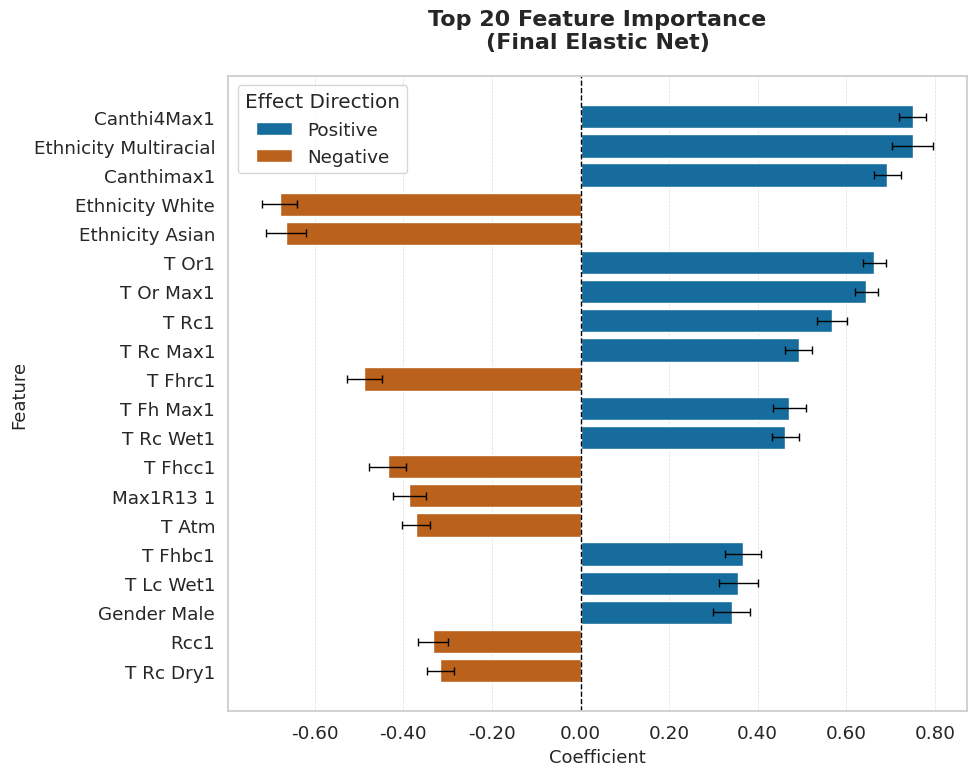

In [ ]:
plot_model_importance("Final Elastic Net", top_n=20)


To better understand the relationship between input variables and the classification of fever, we examined the top 20 features from the final Elastic Net model. The coefficients represent the average values across 200 Monte Carlo cross-validation (MCCV) iterations, with error bars indicating the standard deviation, allowing us to assess both effect size and consistency.

Many of the most influential features relate to thermal readings from physiologically relevant facial regions. For instance:

canthi4Max1 and canthimax1 measure maximum temperatures in the extended canthi region (near the inner corners of the eyes), a hotspot for thermoregulation.

T_OR1 and T_OR_Max1 correspond to average and maximum temperatures in the mouth region, which is closely tied to internal temperature.

Features like T_RC1, T_RC_Wet1, and T_LC_Wet1 represent temperatures in segmented wet and dry areas around the eyes, derived from specific rectangular or circular masks in the infrared images.

Demographic variables also appear with high influence. Notably:

- Ethnicity Multiracial is positively associated with oral temperature indicating a higher predicted oral temperature for individuals of this ethnicity.

- Ethnicity Asian and Ethnicity White have strong negative coefficients indicating a lower predicted oral temperature for individuals of these ethnicities.

These findings align with known physiological and environmental variations in thermoregulation and thermal imaging response. [**Infrared Thermography for Measuring Elevated Body Temperature: Clinical Accuracy, Calibration, and Evaluation**](https://www.semanticscholar.org/paper/Infrared-Thermography-for-Measuring-Elevated-Body-Wang-Zhou/443b9932d295ca3a014e7d874b4bd77a33a276bd)

While these coefficients provide directional insight into variable importance, they are not accompanied by formal p-values or hypothesis tests. Instead, we rely on average values across 200 MCCV iterations, which helps stabilise estimates and reduce overfitting to particular folds. However, features near zero with large error bars or changing directionality (e.g., flipping from slightly negative to slightly positive) should be interpreted with caution. These likely reflect low signal and instability across folds, meaning they may not generalise well to new data.

In contrast, top-ranked features with large magnitudes and narrow error bars (e.g., canthi4Max1, Ethnicity Multiracial, T_OR1) are more likely to represent genuine, stable relationships with oral temperature.

# **4. REGRESSION**

In [ ]:
y_full

aveOralF  aveOralM OralF_Fever OralM_Fever
0        36.85     36.59          No          No
1        37.00     37.19          No          No
2        37.20     37.34          No          No
3        36.85     37.09          No          No
4        36.80     37.04          No          No
...        ...       ...         ...         ...
1015     36.95     36.99          No          No
1016     37.25     37.19          No          No
1017     37.35     37.59          No         Yes
1018     37.15     37.29          No          No
1019     37.05     37.19          No          No

[1017 rows x 4 columns]

In [52]:
y = y_full["aveOralF"]
y2 = y_full["aveOralM"]

In [53]:
df = pd.concat([X, y], axis=1)
df2 = pd.concat([X, y2], axis=1)

## 4.1 Baseline Results

In [ ]:
def evaluate_baseline(X, y, label=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Baseline Regressor Performance ({label}):")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ R²:   {r2:.4f}")
    print("")

# Example usage:
evaluate_baseline(X, y, label="Fast Mode")
evaluate_baseline(X, y2, label="Monitor Mode")



Baseline Regressor Performance (Fast Mode):
✅ RMSE: 0.3460
✅ MAE:  0.2203
✅ R²:   -0.0116

Baseline Regressor Performance (Monitor Mode):
✅ RMSE: 0.4861
✅ MAE:  0.3157
✅ R²:   -0.0039



A baseline prediction of the mean predicts a low RMSE of .3460 (Fast) and .4861 (Monitor). The goal of this regression task is to build models that return the lowest RMSE possible and ultimately beating the baseline guess.

## 4.2 Monte Carlo CV Function for Regression

In [ ]:
# Categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Numerical columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Global storage
regression_model_results = {}
regression_monte_carlo_results = {}
regression_feature_importance_dict = defaultdict(list)
regression_best_hyperparams_counter = defaultdict(int)

def monte_carlo_cv_regression_with_plot(model, param_grid, X, y, model_name, num_iterations=100, test_size=0.2, n_neighbors=5, cv_folds=5, track_feature_importance=True):
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    scaler = StandardScaler()
    results = []
    best_rmse = float("inf")
    best_overall_model = None
    validation_results = {}

    for i in range(num_iterations):
        print(f"\n🔄 Monte Carlo Iteration {i+1}/{num_iterations}...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        X_train[num_cols] = knn_imputer.fit_transform(X_train[num_cols])
        X_test[num_cols] = knn_imputer.transform(X_test[num_cols])

        preprocessor = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ])

        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        feature_names = preprocessor.get_feature_names_out()

        X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
        X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

        if param_grid and len(param_grid) >= 1:
            print(f"🔍 Tuning hyperparameters for {model_name}...")
            grid_search = GridSearchCV(model, param_grid, cv=cv_folds, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train_df, y_train)
            best_model = grid_search.best_estimator_

            best_params = frozenset(grid_search.best_params_.items())
            regression_best_hyperparams_counter[best_params] += 1

            print(f"✅ Best params: {grid_search.best_params_}")
            print(f"✅ Best CV RMSE: {-grid_search.best_score_:.4f}")
            if len(param_grid) == 1:
                validation_results = {
                    "Model": model_name,
                    "Hyperparameters": grid_search.cv_results_["params"],
                    "Validation RMSE": -grid_search.cv_results_["mean_test_score"],
                    "Training RMSE": -grid_search.cv_results_["mean_train_score"]
                }
        else:
            best_model = model.fit(X_train_df, y_train)

        y_pred = best_model.predict(X_test_df)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if rmse < best_rmse:
            best_rmse = rmse
            best_overall_model = best_model
            best_y_test = y_test
            best_y_pred = y_pred

        results.append({"Iteration": i+1, "RMSE": rmse, "MAE": mae, "R2": r2})

        if track_feature_importance:
            if hasattr(best_model, "coef_"):
                regression_feature_importance_dict[model_name].append(best_model.coef_.flatten())
            elif hasattr(best_model, "feature_importances_"):
                regression_feature_importance_dict[model_name].append(best_model.feature_importances_)

    regression_monte_carlo_results[model_name] = pd.DataFrame(results)

    df_results = pd.DataFrame(results).drop(columns=["Iteration"])
    mean_metrics = df_results.mean()
    std_metrics = df_results.std()

    final_results = pd.DataFrame({
        "Mean RMSE": mean_metrics["RMSE"], "Std RMSE": std_metrics["RMSE"],
        "Mean MAE": mean_metrics["MAE"], "Std MAE": std_metrics["MAE"],
        "Mean R2": mean_metrics["R2"], "Std R2": std_metrics["R2"]
    }, index=["Results"])

    print("\n📊 Final Monte Carlo CV Results:")
    display(final_results.round(3))

    if regression_best_hyperparams_counter:
        print("\n🏆 Most Common Best Hyperparameters:")
        sorted_params = Counter(regression_best_hyperparams_counter).most_common()
        for i, (params, count) in enumerate(sorted_params, 1):
            print(f"{i}. Params: {dict(params)} | Chosen: {count} out of {num_iterations} times")

    regression_best_hyperparams_counter.clear()

    regression_model_results[model_name] = {
        "model": best_overall_model,
        "y_test": best_y_test,
        "y_pred": best_y_pred
    }

    plot_residuals_with_ci(model_name)
    plot_predictions_with_lowess(model_name)

    if param_grid and len(param_grid) == 1:
        plot_validation_trends_regression(validation_results)

    return final_results, best_overall_model

def plot_residuals_with_ci(model_name):
    data = regression_model_results[model_name]
    y_test = data["y_test"]
    y_pred = data["y_pred"]
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    sns.regplot(x=y_pred, y=residuals, lowess=True, scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': 'darkorange'})
    plt.axhline(0, linestyle='--', color='black')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot with Trend - {model_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def plot_predictions_with_lowess(model_name):
    data = regression_model_results[model_name]
    y_test = data["y_test"]
    y_pred = data["y_pred"]

    plt.figure(figsize=(6, 6))
    sns.regplot(x=y_test, y=y_pred, lowess=True, scatter_kws={'color': 'royalblue', 'alpha': 0.6}, line_kws={'color': 'darkorange'})
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--', label='Perfect Prediction')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Prediction Plot with Lowess - {model_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_validation_trends_regression(validation_results):
    if not validation_results:
        print("No validation results to plot.")
        return

    params = validation_results["Hyperparameters"]
    val_rmse = validation_results["Validation RMSE"]
    train_rmse = validation_results["Training RMSE"]

    param_name = list(params[0].keys())[0]
    param_values = [p[param_name] for p in params]

    plt.figure(figsize=(10, 6))
    plt.plot(param_values, train_rmse, marker='s', linestyle='--', color="red", label="Training RMSE")
    plt.plot(param_values, val_rmse, marker='o', linestyle='-', color="blue", label="Validation RMSE")
    plt.xlabel(f"{param_name} Values", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.title(f"Training vs Validation RMSE - {param_name}", fontsize=14, fontweight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


---
## 4.3 Linear Regression

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔄 Monte Carlo Iteration 2/200...

🔄 Monte Carlo Iteration 3/200...

🔄 Monte Carlo Iteration 4/200...

🔄 Monte Carlo Iteration 5/200...

🔄 Monte Carlo Iteration 6/200...

🔄 Monte Carlo Iteration 7/200...

🔄 Monte Carlo Iteration 8/200...

🔄 Monte Carlo Iteration 9/200...

🔄 Monte Carlo Iteration 10/200...

🔄 Monte Carlo Iteration 11/200...

🔄 Monte Carlo Iteration 12/200...

🔄 Monte Carlo Iteration 13/200...

🔄 Monte Carlo Iteration 14/200...

🔄 Monte Carlo Iteration 15/200...

🔄 Monte Carlo Iteration 16/200...

🔄 Monte Carlo Iteration 17/200...

🔄 Monte Carlo Iteration 18/200...

🔄 Monte Carlo Iteration 19/200...

🔄 Monte Carlo Iteration 20/200...

🔄 Monte Carlo Iteration 21/200...

🔄 Monte Carlo Iteration 22/200...

🔄 Monte Carlo Iteration 23/200...

🔄 Monte Carlo Iteration 24/200...

🔄 Monte Carlo Iteration 25/200...

🔄 Monte Carlo Iteration 26/200...

🔄 Monte Carlo Iteration 27/200...

🔄 Monte Carlo Iteration 28/200...

🔄 Monte Carlo Iteration 29/2

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.296      0.02     0.215    0.012    0.391   0.083

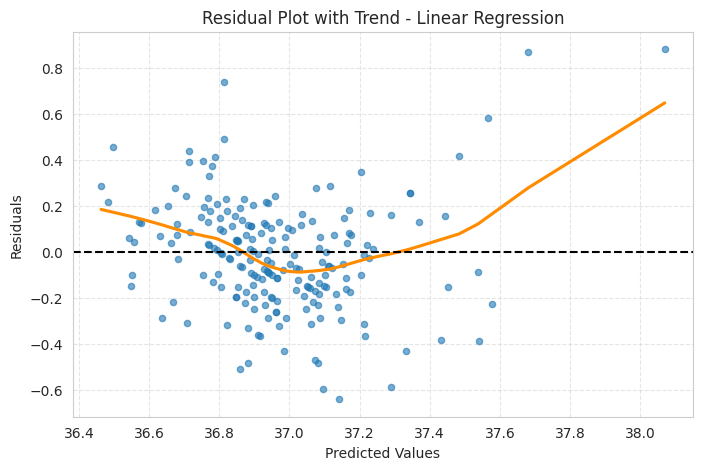

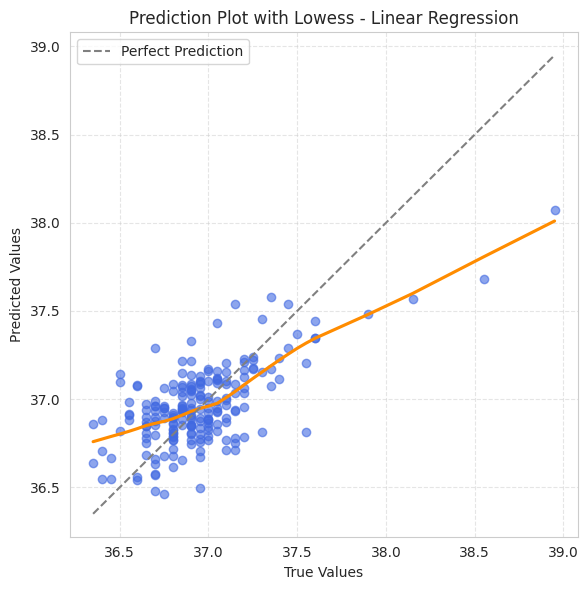

In [ ]:
num_cols = X_REDUCED.select_dtypes(exclude=['object', 'category']).columns.tolist()

linreg_model = LinearRegression()
linreg_results, linreg_best_model = monte_carlo_cv_regression_with_plot(
    linreg_model,
    param_grid=None,
    X=X_REDUCED,
    y=y,
    model_name="Linear Regression",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Linear Regression"].to_csv(f"{save_path_r_f}/linear_regression_mccv_results.csv", index=False)
linreg_results.to_csv(f"{save_path_r_f}/linear_regression_summary.csv")



- **Features Used:**
  - `T_atm`, `Humidity`, `Distance`, `T_offset1`, `Max1R13_1`, `T_FHCC1`, `Gender`, `Age`, `Ethnicity`
  - These were selected due to low correlation (Pearson r < 0.8) to reduce multicollinearity and improve model stability.
  > See section 1.2 to see the correlation matrix.


- **Best Hyperparameters:**
  - No hyperparameters.

- **Monte Carlo CV Results (200 iterations):**
  - **RMSE:** 0.296 ± 0.020   - *Lower than baseline*
  - **MAE:** 0.215 ± 0.012  
  - **R² Score:** 0.391 ± 0.083  

- **Prediction vs True Value Discussion:**
  - The prediction plot shows a general linear trend that approximates the ideal diagonal, indicating decent overall performance.
  - However, the model tends to **underestimate higher oral temperatures**, as seen where the orange LOWESS line dips below the perfect prediction line in the upper range.
  - Most predicted values cluster around 36.8°C–37.2°C, suggesting that the model is better calibrated for non-fever cases.

- **Residual Analysis:**
  - The residual plot shows a **non-random curve**, especially rising for higher predicted temperatures, suggesting that **the model fails to capture non-linear patterns** in the data.
  - The curved LOWESS line implies model misspecification, with signs of **heteroscedasticity** — increasing residual variance at higher temperatures.
  - This indicates the model may underfit the complexity of the task.

- **Advantages of Linear Regression:**
  - Simple and highly interpretable — each feature’s influence can be clearly understood.
  - Computationally efficient and quick to train.
  - Useful as a performance baseline across models.
  - Despite its simplicity, it captured some variance in temperature (R² ≈ 0.39).

- **Limitations of Linear Regression:**
  - Cannot model complex, non-linear interactions — which are likely present in thermal image features.
  - Curved residual trend suggests **missed patterns** that more flexible models could capture.
  - Sensitive to the presence of outliers and heteroscedasticity.
  - No statistical inference (p-values or confidence intervals) was calculated; although, averaging over 200 MCCV iterations offers **some stabilization** of the performance metrics.

> **Note:**  
> The residual and prediction plots were generated from a **single final model**, not averaged across the 200 Monte Carlo CV iterations.  
> This means they **may not reflect the average behaviour** of the model. Ideally, visualisations should be aggregated across iterations to identify **systemic patterns** (e.g. consistent underprediction), rather than potential one off returns of one train/test split.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...

🔄 Monte Carlo Iteration 2/200...

🔄 Monte Carlo Iteration 3/200...

🔄 Monte Carlo Iteration 4/200...

🔄 Monte Carlo Iteration 5/200...

🔄 Monte Carlo Iteration 6/200...

🔄 Monte Carlo Iteration 7/200...

🔄 Monte Carlo Iteration 8/200...

🔄 Monte Carlo Iteration 9/200...

🔄 Monte Carlo Iteration 10/200...

🔄 Monte Carlo Iteration 11/200...

🔄 Monte Carlo Iteration 12/200...

🔄 Monte Carlo Iteration 13/200...

🔄 Monte Carlo Iteration 14/200...

🔄 Monte Carlo Iteration 15/200...

🔄 Monte Carlo Iteration 16/200...

🔄 Monte Carlo Iteration 17/200...

🔄 Monte Carlo Iteration 18/200...

🔄 Monte Carlo Iteration 19/200...

🔄 Monte Carlo Iteration 20/200...

🔄 Monte Carlo Iteration 21/200...

🔄 Monte Carlo Iteration 22/200...

🔄 Monte Carlo Iteration 23/200...

🔄 Monte Carlo Iteration 24/200...

🔄 Monte Carlo Iteration 25/200...

🔄 Monte Carlo Iteration 26/200...

🔄 Monte Carlo Iteration 27/200...

🔄 Monte Carlo Iteration 28/200...

🔄 Monte Carlo Iteration 29/2

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.335     0.019     0.256    0.013    0.557   0.065

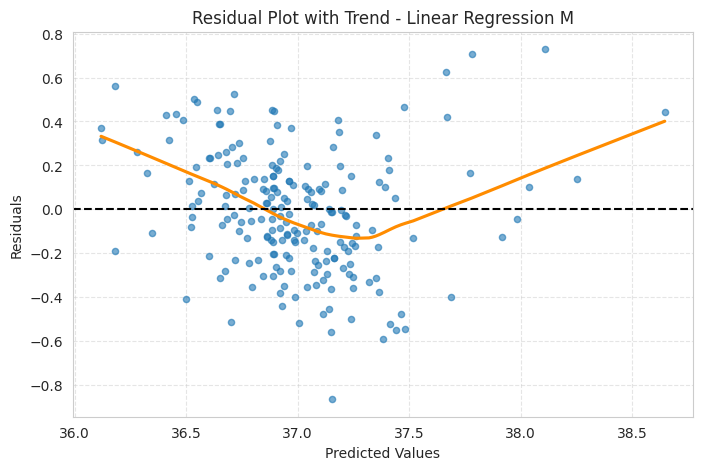

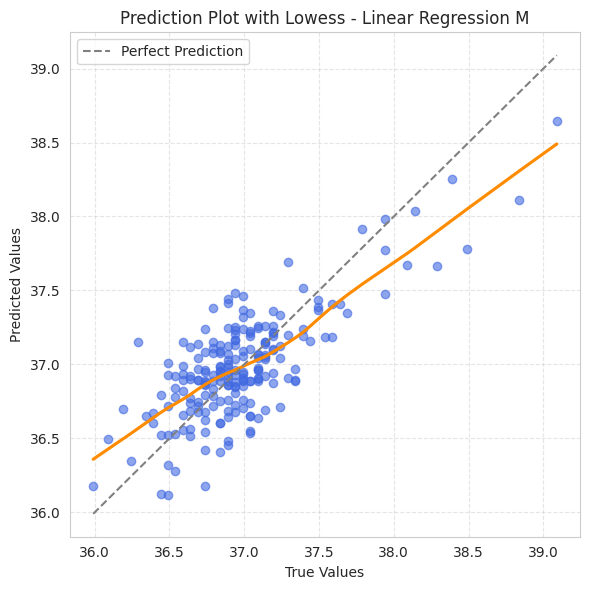

In [ ]:
num_cols = X_REDUCED.select_dtypes(exclude=['object', 'category']).columns.tolist()

linreg_model = LinearRegression()
linreg_resultsM, linreg_best_modelM = monte_carlo_cv_regression_with_plot(
    linreg_model,
    param_grid=None,
    X=X_REDUCED,
    y=y2,
    model_name="Linear Regression M",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Linear Regression M"].to_csv(f"{save_path_r_m}/linear_regression_mccv_results.csv", index=False)
linreg_resultsM.to_csv(f"{save_path_r_m}/linear_regression_summary.csv")


*Model trained using features after correlation filtering*

- **Mean Performance (200 MCCV iterations):**  
  - **RMSE:** 0.335 ± 0.019   - *Lower than baseline (.48)*
  - **MAE:** 0.256 ± 0.013  
  - **R² Score:** 0.557 ± 0.065

- **Prediction Plot Analysis:**  
  - Predictions generally track the true values well. However, the LOWESS trend line shows minor curvature, particularly at the lower and higher ends.
  - This suggests a mild tendency to **underestimate lower oral temperatures** and **overestimate higher values**, likely due to the linear model's inability to capture subtle non-linear relationships.

- **Residual Plot Analysis:**  
  - Residuals appear centered around zero, which is a good sign.  
  - That said, the LOWESS curve indicates a slight **U-shaped trend**, implying some curvature that the linear model cannot fully capture.
  - A few large residuals at the higher predicted end also suggest mild **heteroscedasticity**.

- **Advantages of Linear Regression:**  
  - Simple, interpretable, and easy to explain  
  - Fast training time and low computational time
  - Useful as a **baseline** and for gaining insight into individual feature effects

- **Limitations of Linear Regression:**  
  - Assumes a purely linear relationship between predictors and temperature  
  - Cannot model interaction or non-linear effects unless explicitly engineered  
  - As seen in the residuals, its performance dips slightly on extreme values

> **Note:**  
> The residual and prediction plots shown represent **a single MCCV iteration**, not averaged results.  
> This may reflect a specific run's variability. Averaging across iterations would better show **model stability** and avoid overinterpreting anomalies in a single fold.


---
## 4.4 Elastic Net Reguralisation & Ridge Regression

**Fast mode**


🔄 Monte Carlo Iteration 1/200...

🔄 Monte Carlo Iteration 2/200...

🔄 Monte Carlo Iteration 3/200...

🔄 Monte Carlo Iteration 4/200...

🔄 Monte Carlo Iteration 5/200...

🔄 Monte Carlo Iteration 6/200...

🔄 Monte Carlo Iteration 7/200...

🔄 Monte Carlo Iteration 8/200...

🔄 Monte Carlo Iteration 9/200...

🔄 Monte Carlo Iteration 10/200...

🔄 Monte Carlo Iteration 11/200...

🔄 Monte Carlo Iteration 12/200...

🔄 Monte Carlo Iteration 13/200...

🔄 Monte Carlo Iteration 14/200...

🔄 Monte Carlo Iteration 15/200...

🔄 Monte Carlo Iteration 16/200...

🔄 Monte Carlo Iteration 17/200...

🔄 Monte Carlo Iteration 18/200...

🔄 Monte Carlo Iteration 19/200...

🔄 Monte Carlo Iteration 20/200...

🔄 Monte Carlo Iteration 21/200...

🔄 Monte Carlo Iteration 22/200...

🔄 Monte Carlo Iteration 23/200...

🔄 Monte Carlo Iteration 24/200...

🔄 Monte Carlo Iteration 25/200...

🔄 Monte Carlo Iteration 26/200...

🔄 Monte Carlo Iteration 27/200...

🔄 Monte Carlo Iteration 28/200...

🔄 Monte Carlo Iteration 29/2

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.286     0.032     0.187    0.014    0.439   0.029

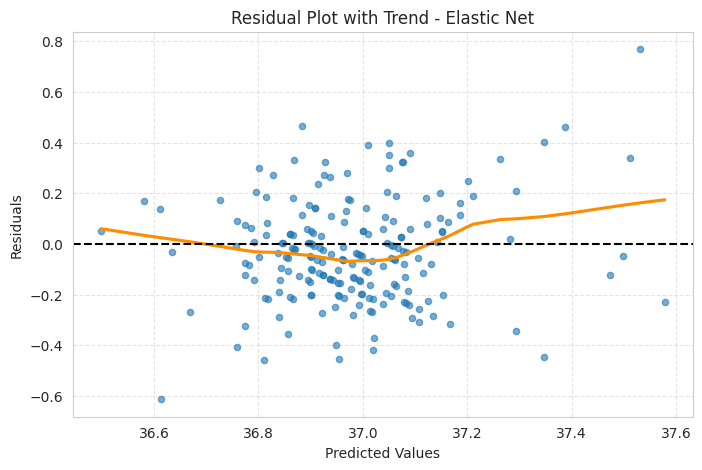

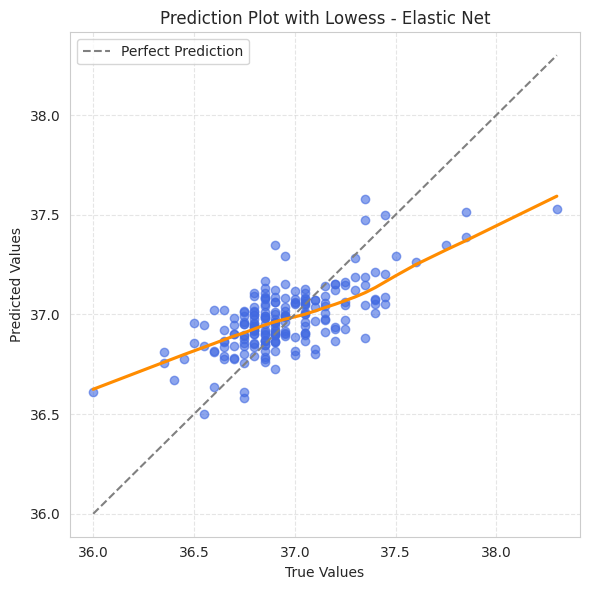

In [ ]:
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
regression_best_hyperparams_counter = defaultdict(int)

elastic_net_model = ElasticNet(max_iter=3000,l1_ratio=0.1,alpha=1.0)
# en_param_grid = {
#     "alpha": [0.1],        # Regularization strength
#     "l1_ratio": [0,.1],      # 0 = Ridge, 1 = Lasso, in between = Elastic Net
# }
enet_results, enet_best_model = monte_carlo_cv_regression_with_plot(
    elastic_net_model,
    param_grid=None, #en_param_grid,
    X=X,
    y=y,
    model_name="Elastic Net",
    num_iterations=200
)

# Save results
regression_monte_carlo_results["Elastic Net"].to_csv(f"{save_path_r_f}/elastic_net_mccv_results.csv", index=False)
enet_results.to_csv(f"{save_path_r_f}/elastic_net_summary.csv")


*All features were retained in this model.*  
Elastic Net's built-in regularisation (L1 + L2) performs automatic feature selection and shrinks less important coefficients toward zero, reducing overfitting risk even with correlated features.  

- **Best Hyperparameters:**  
  - `l1_ratio=0.1`, `alpha=1.0`, `max_iter=3000`  
  - A broad sweep of `l1_ratio` values was used, including 0 (ridge) and 1 (lasso), to assess whether a purely L1 or L2 penalty would perform better. The selected ratio (0.1) suggests a mostly ridge-like behaviour with a small amount of sparsity.

- **Mean Performance (200 MCCV Iterations):**  
  - **RMSE:** 0.286 ± 0.032  
  - **MAE:** 0.187 ± 0.014  
  - **R² Score:** 0.439 ± 0.029

- **Prediction Plot (LOWESS Trend):**  
  - The predictions generally follow the true values well, but show slight underestimation at higher temperatures.
  - The orange LOWESS line confirms this trend, staying slightly below the perfect prediction line at the upper end.

- **Residual Plot (with Trend Line):**  
  - Residuals are reasonably homoscedastic with minor curvature.
  - There's a slight tendency to underpredict higher temperatures (residuals skew positive as predictions increase).
  - This pattern suggests that while linear assumptions are mostly reasonable, slight non-linear trends may be present.

- **Advantages of Elastic Net Regression:**  
  - Handles multicollinearity better than standard linear regression.
  - Automatically selects important features through regularisation.

- **Limitations:**  
  - Still assumes linear relationships, which may limit performance on non-linear patterns.
  - While regularisation stabilises coefficients, it doesn't provide statistical inference (e.g. p-values).
  - Residual patterns suggest that a more flexible model (e.g. tree-based) could capture the underlying structure better.

> **Note:**  
> These plots reflect one representative Monte Carlo split. While helpful for visual interpretation, they do not show averaged behaviour across folds. Averaged prediction plots or distribution plots over iterations would provide a more comprehensive view of model consistency.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.883e+01, tolerance: 2.138e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2627

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.926e+01, tolerance: 2.091e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2665

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e+01, tolerance: 2.112e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2587

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e+01, tolerance: 2.083e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2636

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.820e+01, tolerance: 2.043e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2604

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+01, tolerance: 2.123e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2613

🔄 Monte Carlo Iteration 7/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e+01, tolerance: 2.116e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2647

🔄 Monte Carlo Iteration 8/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+01, tolerance: 2.227e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2609

🔄 Monte Carlo Iteration 9/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e+01, tolerance: 2.114e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2595

🔄 Monte Carlo Iteration 10/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.906e+01, tolerance: 2.084e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2663

🔄 Monte Carlo Iteration 11/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+01, tolerance: 2.014e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2547

🔄 Monte Carlo Iteration 12/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+01, tolerance: 2.076e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2604

🔄 Monte Carlo Iteration 13/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+01, tolerance: 2.186e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2645

🔄 Monte Carlo Iteration 14/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+01, tolerance: 2.258e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2615

🔄 Monte Carlo Iteration 15/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e+01, tolerance: 2.227e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2631

🔄 Monte Carlo Iteration 16/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.905e+01, tolerance: 2.148e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2647

🔄 Monte Carlo Iteration 17/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+01, tolerance: 2.110e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2645

🔄 Monte Carlo Iteration 18/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+01, tolerance: 2.220e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2663

🔄 Monte Carlo Iteration 19/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.807e+01, tolerance: 2.198e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2608

🔄 Monte Carlo Iteration 20/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+01, tolerance: 2.118e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2643

🔄 Monte Carlo Iteration 21/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.780e+01, tolerance: 1.944e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2573

🔄 Monte Carlo Iteration 22/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+01, tolerance: 2.284e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2625

🔄 Monte Carlo Iteration 23/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+01, tolerance: 2.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2548

🔄 Monte Carlo Iteration 24/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.944e+01, tolerance: 2.179e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2656

🔄 Monte Carlo Iteration 25/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+01, tolerance: 1.927e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2502

🔄 Monte Carlo Iteration 26/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e+01, tolerance: 2.154e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2609

🔄 Monte Carlo Iteration 27/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.846e+01, tolerance: 2.072e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2613

🔄 Monte Carlo Iteration 28/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e+01, tolerance: 2.019e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2582

🔄 Monte Carlo Iteration 29/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e+01, tolerance: 2.145e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2553

🔄 Monte Carlo Iteration 30/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+01, tolerance: 2.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2665

🔄 Monte Carlo Iteration 31/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.932e+01, tolerance: 2.136e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2666

🔄 Monte Carlo Iteration 32/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+01, tolerance: 2.185e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2633

🔄 Monte Carlo Iteration 33/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+01, tolerance: 2.198e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2641

🔄 Monte Carlo Iteration 34/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+01, tolerance: 2.030e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2590

🔄 Monte Carlo Iteration 35/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.845e+01, tolerance: 2.083e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2628

🔄 Monte Carlo Iteration 36/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.780e+01, tolerance: 2.062e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2584

🔄 Monte Carlo Iteration 37/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.901e+01, tolerance: 2.171e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2634

🔄 Monte Carlo Iteration 38/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+01, tolerance: 2.116e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2611

🔄 Monte Carlo Iteration 39/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e+01, tolerance: 2.139e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2603

🔄 Monte Carlo Iteration 40/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.811e+01, tolerance: 2.109e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2614

🔄 Monte Carlo Iteration 41/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e+01, tolerance: 2.090e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2560

🔄 Monte Carlo Iteration 42/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e+01, tolerance: 2.197e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2597

🔄 Monte Carlo Iteration 43/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e+01, tolerance: 2.160e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2653

🔄 Monte Carlo Iteration 44/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.806e+01, tolerance: 2.170e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 45/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.849e+01, tolerance: 2.056e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2631

🔄 Monte Carlo Iteration 46/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+01, tolerance: 2.145e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2598

🔄 Monte Carlo Iteration 47/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.811e+01, tolerance: 2.090e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 48/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e+01, tolerance: 1.974e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2546

🔄 Monte Carlo Iteration 49/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e+01, tolerance: 1.955e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2617

🔄 Monte Carlo Iteration 50/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.851e+01, tolerance: 2.107e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2604

🔄 Monte Carlo Iteration 51/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e+01, tolerance: 2.278e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2606

🔄 Monte Carlo Iteration 52/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.934e+01, tolerance: 2.280e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 53/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.770e+01, tolerance: 1.998e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2583

🔄 Monte Carlo Iteration 54/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+01, tolerance: 2.170e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2642

🔄 Monte Carlo Iteration 55/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+01, tolerance: 2.110e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 56/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+01, tolerance: 2.070e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2657

🔄 Monte Carlo Iteration 57/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+01, tolerance: 2.066e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2594

🔄 Monte Carlo Iteration 58/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+01, tolerance: 2.322e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2694

🔄 Monte Carlo Iteration 59/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.670e+01, tolerance: 2.070e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2522

🔄 Monte Carlo Iteration 60/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e+01, tolerance: 2.231e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2599

🔄 Monte Carlo Iteration 61/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.823e+01, tolerance: 1.982e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2601

🔄 Monte Carlo Iteration 62/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+01, tolerance: 2.135e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2544

🔄 Monte Carlo Iteration 63/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.901e+01, tolerance: 2.191e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2644

🔄 Monte Carlo Iteration 64/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+01, tolerance: 2.180e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2591

🔄 Monte Carlo Iteration 65/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e+01, tolerance: 2.071e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2604

🔄 Monte Carlo Iteration 66/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+01, tolerance: 2.210e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2677

🔄 Monte Carlo Iteration 67/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+01, tolerance: 1.898e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2584

🔄 Monte Carlo Iteration 68/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+01, tolerance: 2.128e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 69/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+01, tolerance: 2.091e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2609

🔄 Monte Carlo Iteration 70/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.818e+01, tolerance: 2.006e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2617

🔄 Monte Carlo Iteration 71/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+01, tolerance: 2.257e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2556

🔄 Monte Carlo Iteration 72/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+01, tolerance: 2.043e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2552

🔄 Monte Carlo Iteration 73/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e+01, tolerance: 2.213e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2627

🔄 Monte Carlo Iteration 74/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e+01, tolerance: 2.189e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2621

🔄 Monte Carlo Iteration 75/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+01, tolerance: 2.089e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2622

🔄 Monte Carlo Iteration 76/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.877e+01, tolerance: 2.264e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2630

🔄 Monte Carlo Iteration 77/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.886e+01, tolerance: 2.140e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2631

🔄 Monte Carlo Iteration 78/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 2.172e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2564

🔄 Monte Carlo Iteration 79/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+01, tolerance: 2.056e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2579

🔄 Monte Carlo Iteration 80/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e+01, tolerance: 2.028e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2605

🔄 Monte Carlo Iteration 81/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e+01, tolerance: 2.164e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2625

🔄 Monte Carlo Iteration 82/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e+01, tolerance: 2.180e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2661

🔄 Monte Carlo Iteration 83/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.679e+01, tolerance: 1.976e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2556

🔄 Monte Carlo Iteration 84/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+01, tolerance: 2.219e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2610

🔄 Monte Carlo Iteration 85/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+01, tolerance: 2.105e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2595

🔄 Monte Carlo Iteration 86/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e+01, tolerance: 2.075e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2594

🔄 Monte Carlo Iteration 87/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.755e+01, tolerance: 1.988e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2565

🔄 Monte Carlo Iteration 88/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.787e+01, tolerance: 2.111e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2562

🔄 Monte Carlo Iteration 89/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+01, tolerance: 1.983e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2550

🔄 Monte Carlo Iteration 90/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.834e+01, tolerance: 2.179e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2615

🔄 Monte Carlo Iteration 91/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.814e+01, tolerance: 2.127e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2598

🔄 Monte Carlo Iteration 92/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.842e+01, tolerance: 2.073e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2633

🔄 Monte Carlo Iteration 93/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.756e+01, tolerance: 1.997e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2620

🔄 Monte Carlo Iteration 94/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e+01, tolerance: 2.015e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2550

🔄 Monte Carlo Iteration 95/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.823e+01, tolerance: 2.096e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2597

🔄 Monte Carlo Iteration 96/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e+01, tolerance: 2.037e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2602

🔄 Monte Carlo Iteration 97/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e+01, tolerance: 2.306e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2671

🔄 Monte Carlo Iteration 98/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.807e+01, tolerance: 1.991e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2596

🔄 Monte Carlo Iteration 99/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.855e+01, tolerance: 2.309e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2593

🔄 Monte Carlo Iteration 100/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+01, tolerance: 2.222e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2626

🔄 Monte Carlo Iteration 101/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e+01, tolerance: 2.141e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2589

🔄 Monte Carlo Iteration 102/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.787e+01, tolerance: 1.933e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2597

🔄 Monte Carlo Iteration 103/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e+01, tolerance: 2.154e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2599

🔄 Monte Carlo Iteration 104/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+01, tolerance: 2.167e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2665

🔄 Monte Carlo Iteration 105/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.890e+01, tolerance: 2.238e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2636

🔄 Monte Carlo Iteration 106/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.991e+01, tolerance: 2.264e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2687

🔄 Monte Carlo Iteration 107/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.846e+01, tolerance: 2.008e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 108/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.744e+01, tolerance: 2.221e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2545

🔄 Monte Carlo Iteration 109/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+01, tolerance: 2.184e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2658

🔄 Monte Carlo Iteration 110/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+01, tolerance: 2.114e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2595

🔄 Monte Carlo Iteration 111/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.846e+01, tolerance: 1.919e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2639

🔄 Monte Carlo Iteration 112/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+01, tolerance: 2.101e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2618

🔄 Monte Carlo Iteration 113/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e+01, tolerance: 2.286e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2604

🔄 Monte Carlo Iteration 114/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e+01, tolerance: 2.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 115/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e+01, tolerance: 2.175e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2586

🔄 Monte Carlo Iteration 116/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+01, tolerance: 2.150e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2594

🔄 Monte Carlo Iteration 117/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+01, tolerance: 1.914e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2498

🔄 Monte Carlo Iteration 118/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+01, tolerance: 2.122e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2591

🔄 Monte Carlo Iteration 119/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+01, tolerance: 2.162e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2624

🔄 Monte Carlo Iteration 120/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e+01, tolerance: 2.132e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2653

🔄 Monte Carlo Iteration 121/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e+01, tolerance: 2.049e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2495

🔄 Monte Carlo Iteration 122/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+01, tolerance: 2.264e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2652

🔄 Monte Carlo Iteration 123/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+01, tolerance: 2.088e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2675

🔄 Monte Carlo Iteration 124/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e+01, tolerance: 2.064e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2610

🔄 Monte Carlo Iteration 125/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e+01, tolerance: 2.241e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2657

🔄 Monte Carlo Iteration 126/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e+01, tolerance: 2.016e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2620

🔄 Monte Carlo Iteration 127/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e+01, tolerance: 2.001e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2566

🔄 Monte Carlo Iteration 128/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+01, tolerance: 2.195e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2696

🔄 Monte Carlo Iteration 129/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+01, tolerance: 2.221e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2647

🔄 Monte Carlo Iteration 130/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e+01, tolerance: 1.993e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2559

🔄 Monte Carlo Iteration 131/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.814e+01, tolerance: 1.953e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2582

🔄 Monte Carlo Iteration 132/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.802e+01, tolerance: 2.067e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2605

🔄 Monte Carlo Iteration 133/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+01, tolerance: 2.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2602

🔄 Monte Carlo Iteration 134/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e+01, tolerance: 2.063e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2619

🔄 Monte Carlo Iteration 135/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.830e+01, tolerance: 2.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2612

🔄 Monte Carlo Iteration 136/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+01, tolerance: 2.209e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2656

🔄 Monte Carlo Iteration 137/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e+01, tolerance: 1.971e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2532

🔄 Monte Carlo Iteration 138/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+01, tolerance: 2.127e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2631

🔄 Monte Carlo Iteration 139/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.894e+01, tolerance: 2.132e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2642

🔄 Monte Carlo Iteration 140/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e+01, tolerance: 2.086e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2647

🔄 Monte Carlo Iteration 141/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.808e+01, tolerance: 1.896e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2616

🔄 Monte Carlo Iteration 142/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.846e+01, tolerance: 2.184e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2592

🔄 Monte Carlo Iteration 143/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e+01, tolerance: 2.074e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2610

🔄 Monte Carlo Iteration 144/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e+01, tolerance: 1.960e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2595

🔄 Monte Carlo Iteration 145/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.727e+01, tolerance: 1.912e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2572

🔄 Monte Carlo Iteration 146/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e+01, tolerance: 2.207e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2616

🔄 Monte Carlo Iteration 147/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.843e+01, tolerance: 2.037e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2619

🔄 Monte Carlo Iteration 148/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e+01, tolerance: 2.181e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2607

🔄 Monte Carlo Iteration 149/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+01, tolerance: 2.228e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2637

🔄 Monte Carlo Iteration 150/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e+01, tolerance: 2.037e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2524

🔄 Monte Carlo Iteration 151/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+01, tolerance: 2.086e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 152/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e+01, tolerance: 2.220e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2535

🔄 Monte Carlo Iteration 153/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+01, tolerance: 2.113e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2633

🔄 Monte Carlo Iteration 154/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+01, tolerance: 2.066e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2571

🔄 Monte Carlo Iteration 155/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+01, tolerance: 2.103e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2553

🔄 Monte Carlo Iteration 156/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.830e+01, tolerance: 2.009e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2614

🔄 Monte Carlo Iteration 157/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e+01, tolerance: 2.158e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2669

🔄 Monte Carlo Iteration 158/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+01, tolerance: 2.060e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2593

🔄 Monte Carlo Iteration 159/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.906e+01, tolerance: 2.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2639

🔄 Monte Carlo Iteration 160/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+01, tolerance: 2.081e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2582

🔄 Monte Carlo Iteration 161/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+01, tolerance: 2.147e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2544

🔄 Monte Carlo Iteration 162/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+01, tolerance: 2.229e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2643

🔄 Monte Carlo Iteration 163/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.764e+01, tolerance: 2.116e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2578

🔄 Monte Carlo Iteration 164/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e+01, tolerance: 2.169e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2603

🔄 Monte Carlo Iteration 165/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.857e+01, tolerance: 2.202e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2599

🔄 Monte Carlo Iteration 166/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+01, tolerance: 2.183e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2640

🔄 Monte Carlo Iteration 167/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+01, tolerance: 1.917e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2559

🔄 Monte Carlo Iteration 168/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.943e+01, tolerance: 2.310e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2666

🔄 Monte Carlo Iteration 169/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e+01, tolerance: 2.112e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2647

🔄 Monte Carlo Iteration 170/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e+01, tolerance: 2.204e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2612

🔄 Monte Carlo Iteration 171/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e+01, tolerance: 2.060e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 172/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e+01, tolerance: 1.930e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2556

🔄 Monte Carlo Iteration 173/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+01, tolerance: 2.031e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 174/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.857e+01, tolerance: 2.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2625

🔄 Monte Carlo Iteration 175/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e+01, tolerance: 2.002e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2573

🔄 Monte Carlo Iteration 176/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+01, tolerance: 1.957e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2598

🔄 Monte Carlo Iteration 177/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.708e+01, tolerance: 2.142e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2553

🔄 Monte Carlo Iteration 178/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e+01, tolerance: 2.181e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2584

🔄 Monte Carlo Iteration 179/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e+01, tolerance: 2.050e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2648

🔄 Monte Carlo Iteration 180/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.939e+01, tolerance: 2.262e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2652

🔄 Monte Carlo Iteration 181/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e+01, tolerance: 2.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2619

🔄 Monte Carlo Iteration 182/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e+01, tolerance: 1.987e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2592

🔄 Monte Carlo Iteration 183/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+01, tolerance: 1.973e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2562

🔄 Monte Carlo Iteration 184/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+01, tolerance: 2.225e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2600

🔄 Monte Carlo Iteration 185/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.706e+01, tolerance: 1.996e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2550

🔄 Monte Carlo Iteration 186/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+01, tolerance: 2.142e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2605

🔄 Monte Carlo Iteration 187/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+01, tolerance: 1.990e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2599

🔄 Monte Carlo Iteration 188/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.781e+01, tolerance: 2.069e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2597

🔄 Monte Carlo Iteration 189/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+01, tolerance: 2.001e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2585

🔄 Monte Carlo Iteration 190/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+01, tolerance: 2.056e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2579

🔄 Monte Carlo Iteration 191/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.881e+01, tolerance: 2.163e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2629

🔄 Monte Carlo Iteration 192/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.844e+01, tolerance: 2.278e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2618

🔄 Monte Carlo Iteration 193/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.799e+01, tolerance: 1.921e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2601

🔄 Monte Carlo Iteration 194/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.824e+01, tolerance: 2.159e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2613

🔄 Monte Carlo Iteration 195/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+01, tolerance: 2.233e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2620

🔄 Monte Carlo Iteration 196/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.849e+01, tolerance: 2.111e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2603

🔄 Monte Carlo Iteration 197/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+01, tolerance: 2.227e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2610

🔄 Monte Carlo Iteration 198/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.860e+01, tolerance: 2.136e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2621

🔄 Monte Carlo Iteration 199/200...
🔍 Tuning hyperparameters for Elastic Net M...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+01, tolerance: 2.138e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2649

🔄 Monte Carlo Iteration 200/200...
🔍 Tuning hyperparameters for Elastic Net M...
✅ Best params: {'alpha': 0.1, 'l1_ratio': 0}
✅ Best CV RMSE: 0.2611

📊 Final Monte Carlo CV Results:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e+01, tolerance: 2.161e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.261     0.014     0.203     0.01    0.729   0.046


🏆 Most Common Best Hyperparameters:
1. Params: {'l1_ratio': 0, 'alpha': 0.1} | Chosen: 200 out of 200 times


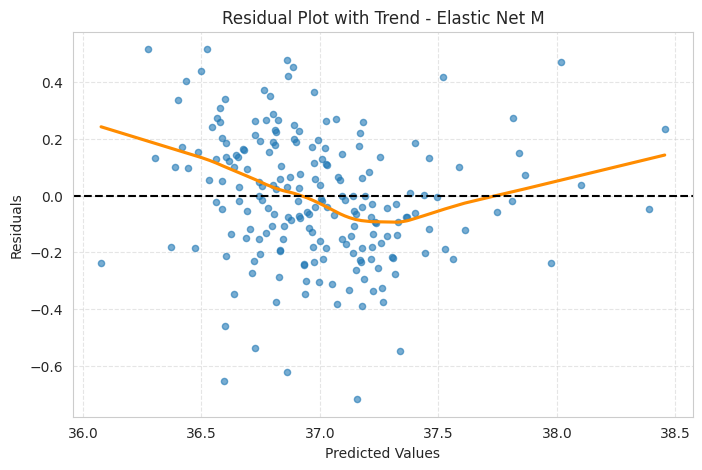

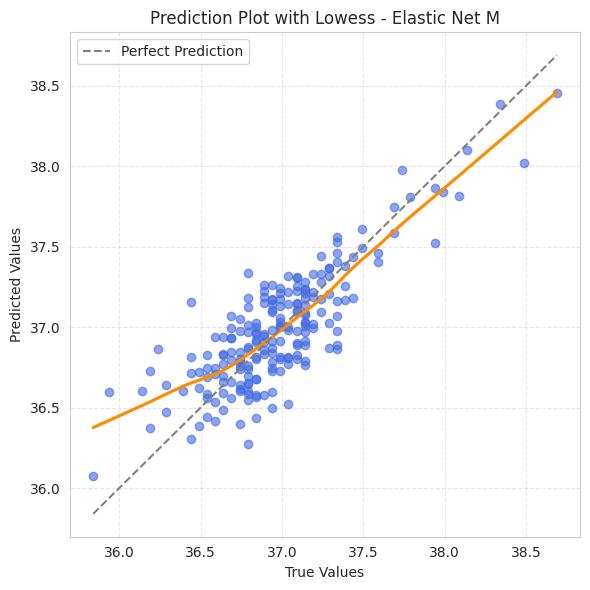

In [ ]:
elastic_net_model = ElasticNet(max_iter=3000)
regression_best_hyperparams_counter = defaultdict(int)
en_param_grid = {
    "alpha": [0.1],        # Regularization strength
    "l1_ratio": [0,.1],      # 0 = Ridge, 1 = Lasso, in between = Elastic Net
}
enet_resultsM, enet_best_modelM = monte_carlo_cv_regression_with_plot(
    elastic_net_model,
    param_grid=en_param_grid,
    X=X,
    y=y2,
    model_name="Elastic Net M",
    num_iterations=200
)

# Save results
regression_monte_carlo_results["Elastic Net M"].to_csv(f"{save_path_r_m}/elastic_net_mccv_results.csv", index=False)
enet_resultsM.to_csv(f"{save_path_r_m}/elastic_net_summary.csv")


All features were retained in this model. Given that Elastic Net includes L1 (Lasso) and L2 (Ridge) penalties, it performs regularisation and, when L1 is used, can also perform feature selection. However, in this case, the optimal `l1_ratio` was **0**, meaning the model effectively reduced to **Ridge regression**.

**Best Hyperparameters:**
- `l1_ratio`: 0 → equivalent to **Ridge Regression**
- `alpha`: 0.1  
- Chosen in **200 out of 200** iterations — indicating very strong consensus.

**Mean Performance Metrics (200 MCCV iterations):**
- **RMSE:** 0.261 ± 0.014  
- **MAE:** 0.203 ± 0.010  
- **R²:** 0.729 ± 0.046

**Prediction Plot Discussion:**
- The **Lowess curve** closely follows the diagonal, especially between 36.5°C and 38°C.
- Predictions slightly underestimate at the lower end and slightly overestimate at the higher end.
- Overall, the model captures the core temperature trend with good calibration.

**Residual Plot Discussion:**
- Residuals are fairly symmetrically distributed and show a mild curve in the Lowess trend.
- Most residuals fall within ±0.4, suggesting relatively tight predictions.
- Slight non-linearity remains, which may be better addressed by more flexible models.

**Advantages:**
- As Ridge regression, it effectively handles multicollinearity by shrinking correlated coefficients.
- Strong regularisation improves generalisation.
- Consistency in hyperparameter selection and predictive performance.

**Limitations:**
- Does not perform feature selection — all features remain in the model. (Because it is ridge regression)
- Linear assumptions still limit its ability to model complex, non-linear relationships.
- Coefficient interpretation can be difficult in the presence of many correlated predictors, even if their variance is stabilised.


---
## 4.5 Decision Tree

**Fast mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 7}
✅ Best CV RMSE: 0.2609

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
✅ Best CV RMSE: 0.2714

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
✅ Best CV RMSE: 0.2474

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
✅ Best CV RMSE: 0.2469

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
✅ Best CV RMSE: 0.2442

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for Decision Tree...
✅ Best 

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.252     0.023     0.177    0.013    0.553   0.093


🏆 Most Common Best Hyperparameters:
1. Params: {'min_samples_split': 10, 'max_depth': 3, 'min_samples_leaf': 4} | Chosen: 58 out of 200 times
2. Params: {'min_samples_split': 10, 'max_depth': 3, 'min_samples_leaf': 2} | Chosen: 54 out of 200 times
3. Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4} | Chosen: 53 out of 200 times
4. Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} | Chosen: 27 out of 200 times
5. Params: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2} | Chosen: 8 out of 200 times


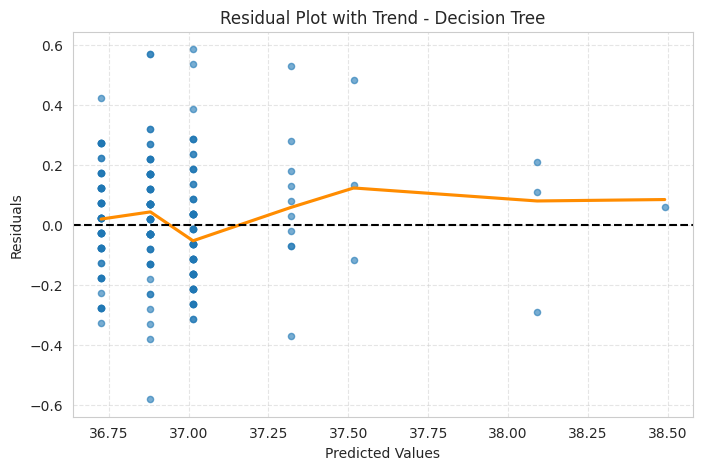

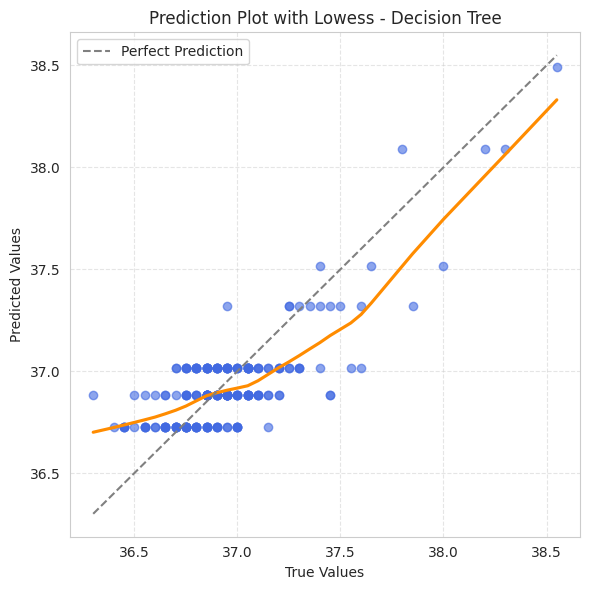

In [ ]:
dtr_model = DecisionTreeRegressor(random_state=2025)
dtr_param_grid = {
    "max_depth": [3],
    "min_samples_split": [2, 7, 10],
    "min_samples_leaf": [2, 4]
}
regression_best_hyperparams_counter = defaultdict(int)

# Run Monte Carlo CV
dtr_results, dtr_best_model = monte_carlo_cv_regression_with_plot(
    dtr_model,
    param_grid=dtr_param_grid,
    X=X,
    y=y,
    model_name="Decision Tree",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Decision Tree"].to_csv(f"{save_path_r_f}/decision_tree_mccv_results.csv", index=False)
dtr_results.to_csv(f"{save_path_r_f}/decision_tree_summary.csv")


All features were retained in this model

**Best Hyperparameters:**
- `max_depth`: 3
- `min_samples_split`: 10
- `min_samples_leaf`: 4  

**Mean Performance Metrics (200 Monte Carlo CV Iterations):**
- **RMSE:** 0.252 ± 0.023
- **MAE:** 0.177 ± 0.013
- **R² Score:** 0.553 ± 0.093

**Prediction and Residual Plot Interpretation:**
- The **prediction plot** indicates good alignment with the perfect prediction line for the majority of values, particularly in the middle range.
- However, **noticeable step-wise predictions** reflect the discrete nature of decision trees, as seen in the horizontal lines of predicted values.
- The **residual plot** shows relatively tight residuals around zero, but with some minor structure remaining—suggesting a limited ability to capture finer gradients in temperature variation.

**Advantages of Decision Tree Regression:**
- Naturally captures **non-linear interactions** without feature engineering.
- **Interpretability** is high – tree structure can be visualized.
- Minimal preprocessing required (no need for scaling or dummy encoding in many cases).

**Limitations of Decision Tree Regression:**
- Prone to **overfitting**, though regularization via `max_depth`, `min_samples_leaf`, and `min_samples_split` helps mitigate this.
- Lacks **smoothness** in predictions – evident from blocky outputs.
- Performs worse on extrapolation and can be **unstable to data variation** (though 200 MCCV helps reduce this risk).

> Overall, the decision tree performed competitively, particularly in MAE and RMSE, but its stepwise prediction style and slightly lower R² suggest that it may benefit from ensemble techniques (e.g., Random Forest or Gradient Boosting) to improve stability and generalization.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for Decision Tree M...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
✅ Best CV RMSE: 0.2709

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for Decision Tree M...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
✅ Best CV RMSE: 0.2709

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for Decision Tree M...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
✅ Best CV RMSE: 0.2613

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for Decision Tree M...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 7}
✅ Best CV RMSE: 0.2602

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for Decision Tree M...
✅ Best params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
✅ Best CV RMSE: 0.2681

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for Decision Tree M.

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.268     0.017     0.204    0.012    0.714   0.055


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4} | Chosen: 88 out of 200 times
2. Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} | Chosen: 51 out of 200 times
3. Params: {'min_samples_split': 10, 'max_depth': 3, 'min_samples_leaf': 2} | Chosen: 30 out of 200 times
4. Params: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2} | Chosen: 21 out of 200 times
5. Params: {'min_samples_split': 10, 'max_depth': 3, 'min_samples_leaf': 4} | Chosen: 10 out of 200 times


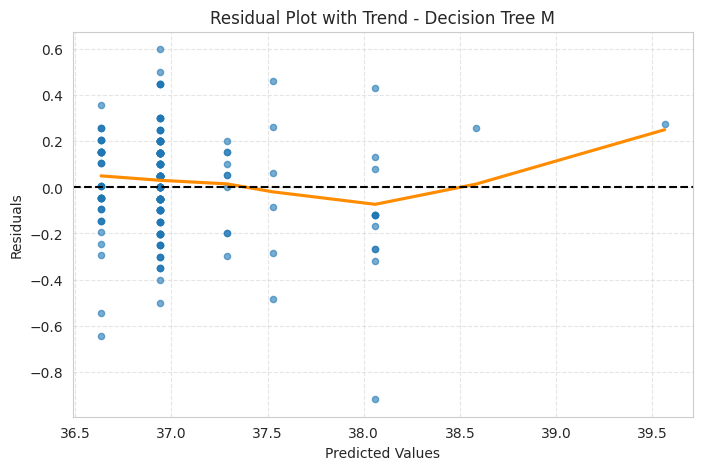

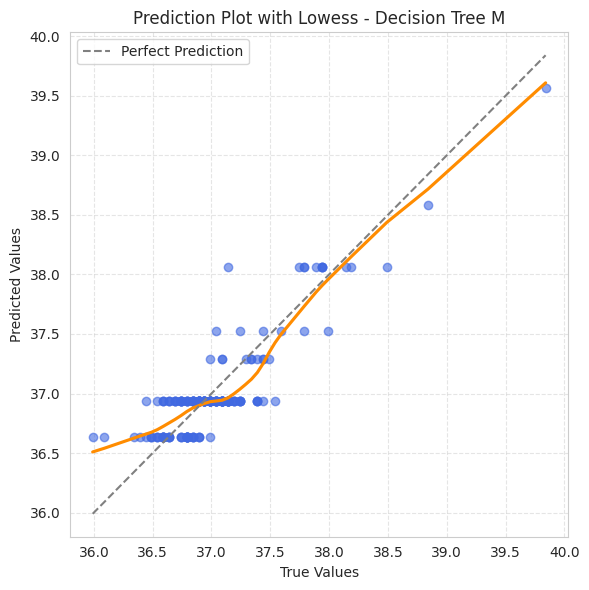

In [ ]:
regression_best_hyperparams_counter = defaultdict(int)

dtr_resultsM, dtr_best_modelM = monte_carlo_cv_regression_with_plot(
    dtr_model,
    param_grid=dtr_param_grid,
    X=X,
    y=y2,
    model_name="Decision Tree M",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Decision Tree M"].to_csv(f"{save_path_r_m}/decision_tree_mccv_results.csv", index=False)
dtr_resultsM.to_csv(f"{save_path_r_m}/decision_tree_summary.csv")

- **Best Hyperparameters:**
  - `max_depth`: 3, `min_samples_split`: 2, `min_samples_leaf`: 4  
  - **Most Commonly Chosen:** 88 out of 200 MCCV iterations

- **Performance (200 Monte Carlo CV Iterations):**
  - **Mean RMSE:** 0.268 ± 0.017  
  - **Mean MAE:** 0.204 ± 0.012  
  - **Mean $R^2$ Score:** 0.714 ± 0.055

- **Prediction Plot Discussion:**
  - The predicted values follow the overall structure of the true values, with reasonably good alignment along the diagonal reference line.
  - The orange Lowess trend line shows slight underprediction in the lower range and slight overprediction in the upper range, but generally tracks the ideal line well.

- **Residual Plot Discussion:**
  - The residuals are centered around zero, with mild systematic deviations captured by the trend line.
  - Flat segments in predictions (a known behaviour of decision trees) are reflected in the vertical stripes seen in the plot, where the model predicts the same value across a range of inputs.

- **Advantages of Decision Tree:**
  - Naturally handles non-linear interactions between features.
  - Intuitive and interpretable (if tree depth is small).

- **Limitations of Decision Tree:**
  - Discrete step-wise predictions result in non-smooth outputs.
  - Prone to overfitting unless carefully regularized (which was mitigated via hyperparameter tuning).
  - Sensitive to small variations in the data.



---
## 4.6 Random Forest

**Fast mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for Random Forest...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2375

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for Random Forest...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2440

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for Random Forest...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2260

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for Random Forest...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2405

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for Random Forest...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best C

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.235     0.018     0.169    0.011    0.613   0.079


🏆 Most Common Best Hyperparameters:
1. Params: {'min_samples_split': 5, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 80} | Chosen: 134 out of 200 times
2. Params: {'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 80} | Chosen: 66 out of 200 times


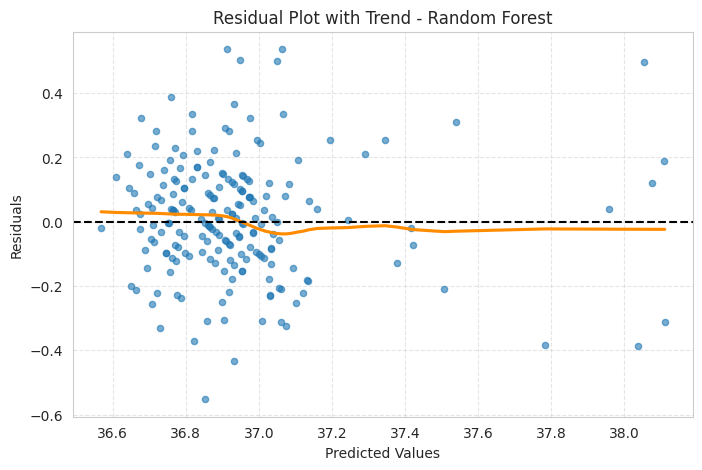

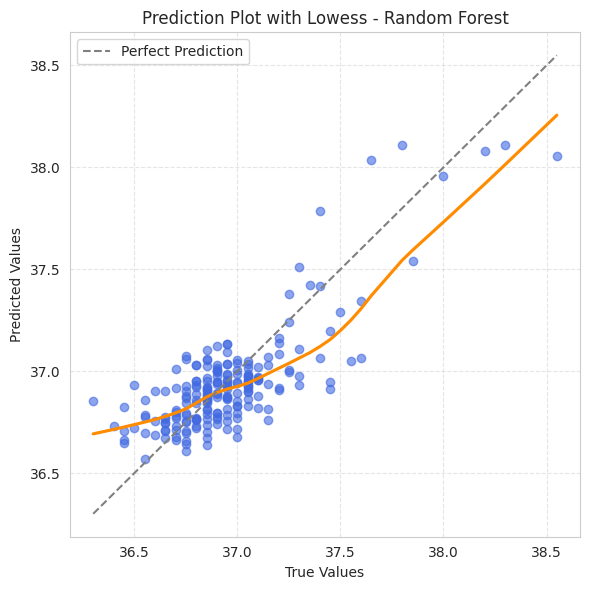

In [ ]:
rf_model = RandomForestRegressor(random_state=2025)
rf_param_grid = {
    "n_estimators": [80],
    "max_depth": [10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2]
}
regression_best_hyperparams_counter = defaultdict(int)

rf_results, rf_best_model = monte_carlo_cv_regression_with_plot(
    rf_model,
    param_grid=rf_param_grid,
    X=X,
    y=y,
    model_name="Random Forest",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Random Forest"].to_csv(f"{save_path_r_f}/random_forest_mccv_results.csv", index=False)
rf_results.to_csv(f"{save_path_r_f}/random_forest_summary.csv")




- **Best Hyperparameters:**
  - `min_samples_split`: 5  
  - `max_depth`: 10  
  - `min_samples_leaf`: 2  
  - `n_estimators`: 80  
  - (Chosen in 134 out of 200 MCCV runs)

- **Mean Performance (200 Monte Carlo CV iterations):**
  - **RMSE:** 0.235 ± 0.018  
  - **MAE:** 0.169 ± 0.011  
  - **R² Score:** 0.613 ± 0.079

- **Prediction and Residual Insights:**
  - The **prediction plot** showed a tight alignment with the perfect prediction line, particularly in the lower and mid-range of temperature values.
  - The **residual plot** revealed minimal curvature or heteroscedasticity, indicating well-distributed residuals and reliable model behavior.
  - Random Forest provided **smooth and stable predictions**, outperforming linear models in capturing nuanced relationships.

- **Advantages of Random Forest:**
  - Excellent at modeling **non-linear interactions**  
  - **Resistant to overfitting** due to ensemble averaging  
  - Works well without heavy preprocessing or feature engineering

- **Disadvantages of Random Forest:**
  - **Limited interpretability**, which is a concern in medical contexts
  - **Slower inference time** and more memory-intensive compared to simpler models


> Random Forest achieved the **lowest RMSE and MAE** in Fast Mode regression, with reliable generalization performance across MCCV splits.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for Random Forest M...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2530

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for Random Forest M...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2585

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for Random Forest M...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
✅ Best CV RMSE: 0.2431

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for Random Forest M...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
✅ Best CV RMSE: 0.2491

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for Random Forest M...
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results       0.25     0.015      0.19     0.01    0.751   0.047


🏆 Most Common Best Hyperparameters:
1. Params: {'min_samples_split': 5, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 80} | Chosen: 131 out of 200 times
2. Params: {'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 80} | Chosen: 69 out of 200 times


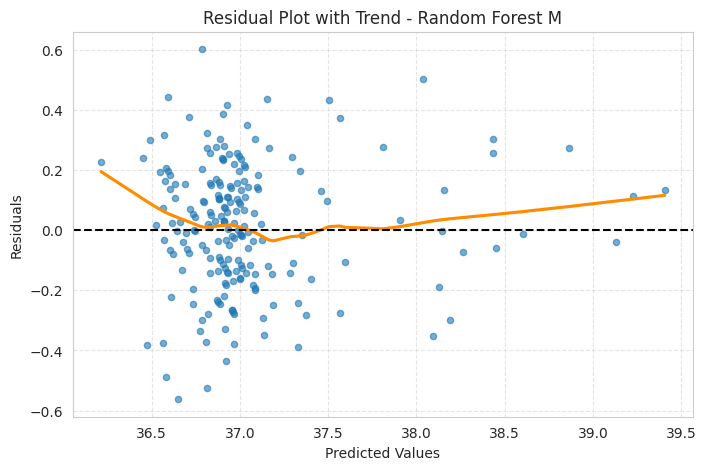

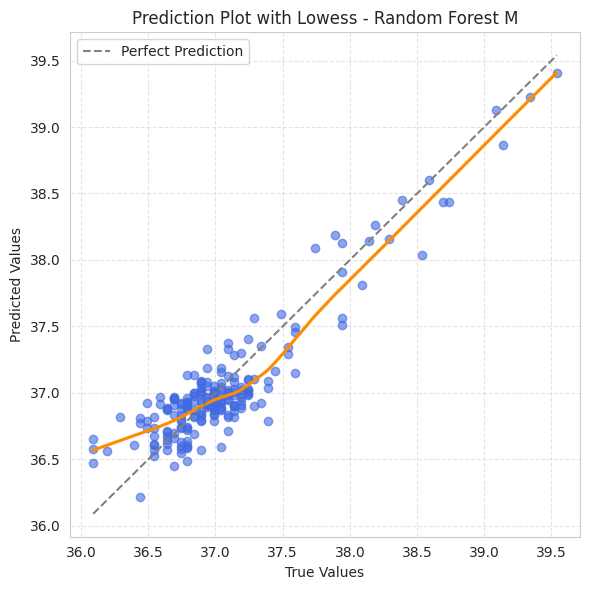

In [ ]:
regression_best_hyperparams_counter = defaultdict(int)

rf_resultsM, rf_best_modelM = monte_carlo_cv_regression_with_plot(
    rf_model,
    param_grid=rf_param_grid,
    X=X,
    y=y2,
    model_name="Random Forest M",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["Random Forest M"].to_csv(f"{save_path_r_m}/random_forest_mccv_results.csv", index=False)
rf_resultsM.to_csv(f"{save_path_r_m}/random_forest_summary.csv")


**Final Monte Carlo CV Results (200 iterations):**
- **RMSE:** 0.250 ± 0.015  
- **MAE:** 0.190 ± 0.010  
- **R² Score:** 0.751 ± 0.047  

- **Best Hyperparameters:**
  - `min_samples_split`: 5  
  - `max_depth`: 10  
  - `min_samples_leaf`: 2  
  - `n_estimators`: 80  
  - (Chosen in 131 out of 200 MCCV runs)

**Prediction Plot and Residual Trends:**
- The **prediction plot** closely followed the identity line, especially in the middle and upper temperature ranges, indicating solid predictive alignment with true values.
- **Residuals were centered around zero**, with only mild curvature in the low end — suggesting the model slightly underestimated some lower values.
- Importantly, **random forest maintained consistency** across the full range of oral temperatures in monitor mode, handling both typical and elevated values well.

**Advantages of Random Forest:**
- Strong predictive accuracy with low RMSE and high R², particularly in monitor mode.
- Able to capture complex, non-linear interactions between features.
- Consistent performance across MCCV iterations, showing stability in generalization.

**Limitations of Random Forest:**
- Less interpretable than linear models — difficult to trace individual feature effects.
- Longer training time compared to simpler models like Elastic Net.
- Susceptible to overfitting without careful hyperparameter tuning — though this was mitigated using MCCV and regularization through parameter constraints.

> **Note:**  
> The LOWESS line on both residual and prediction plots was drawn from a **single final model**, not the average over MCCV folds. While helpful for qualitative insight, averaging across all iterations would provide a more better view of model behaviour.


---
## 4.7 KNN

**Fast mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 10}
✅ Best CV RMSE: 0.2532

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 9}
✅ Best CV RMSE: 0.2550

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 10}
✅ Best CV RMSE: 0.2410

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 13}
✅ Best CV RMSE: 0.2562

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 15}
✅ Best CV RMSE: 0.2519

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 20}
✅ Best CV RMSE: 0.2533

🔄 Monte Carlo Iteration 7/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 10}
✅ Best CV RMSE: 0.2476

🔄 Monte Carlo Iteration 8/200...
🔍 Tuning hyperparameters for KNN...
✅ Best params: {'n_neighbors': 10}


Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.251      0.02     0.176    0.012    0.561   0.073


🏆 Most Common Best Hyperparameters:
1. Params: {'n_neighbors': 15} | Chosen: 35 out of 200 times
2. Params: {'n_neighbors': 10} | Chosen: 33 out of 200 times
3. Params: {'n_neighbors': 9} | Chosen: 30 out of 200 times
4. Params: {'n_neighbors': 11} | Chosen: 28 out of 200 times
5. Params: {'n_neighbors': 13} | Chosen: 25 out of 200 times
6. Params: {'n_neighbors': 20} | Chosen: 22 out of 200 times
7. Params: {'n_neighbors': 8} | Chosen: 19 out of 200 times
8. Params: {'n_neighbors': 7} | Chosen: 8 out of 200 times


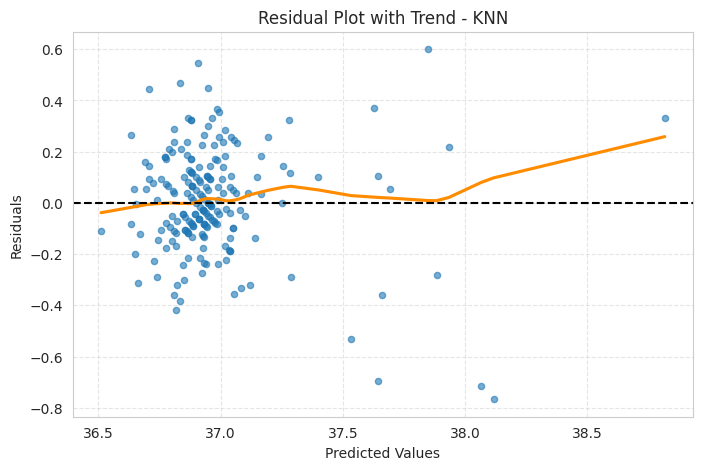

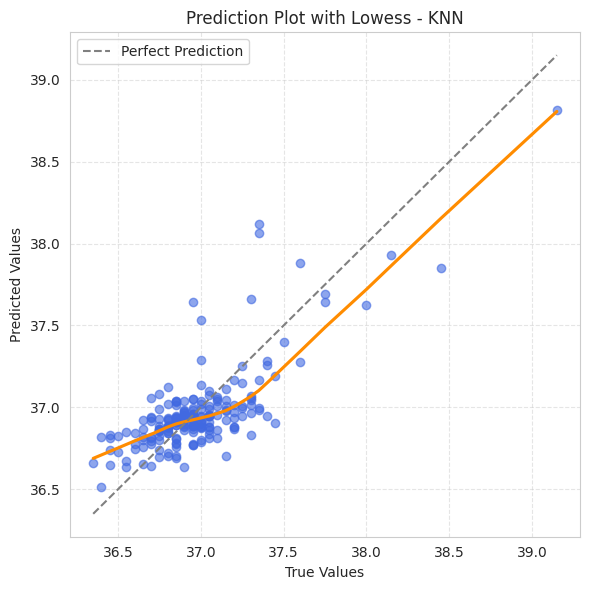

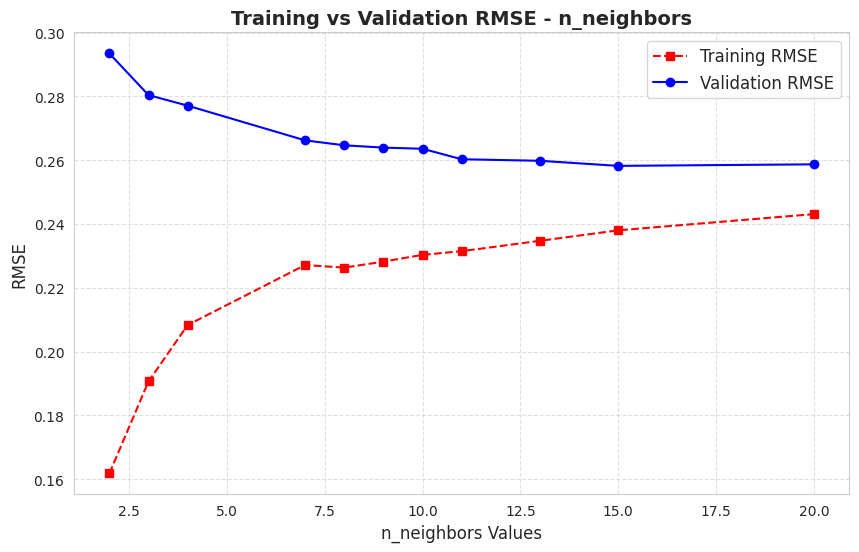

In [ ]:
regression_best_hyperparams_counter = defaultdict(int)
knn_model = KNeighborsRegressor()
knn_param_grid = {
    "n_neighbors": [ 2, 3, 4, 7, 8,9, 10,11,13,15,20 ]
}
knn_results, knn_best_model = monte_carlo_cv_regression_with_plot(
    knn_model,
    param_grid=knn_param_grid,
    X=X,
    y=y,
    model_name="KNN",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["KNN"].to_csv(f"{save_path_r_f}/knn_mccv_results.csv", index=False)
knn_results.to_csv(f"{save_path_r_f}/knn_summary.csv")


*All features were retained in this model.*  
K-Nearest Neighbours (KNN) is a non-parametric model that makes predictions by averaging the target values of the k most similar instances. It is sensitive to feature scaling and local structure but does not make linearity assumptions.

- **Best Hyperparameters:**  
  - `n_neighbors=15` was the most frequently selected hyperparameter.  
  - Other frequently chosen values included 10, 9, 11, 13, 20, and 8.  
  - The training vs validation RMSE plot showed validation error flattening around **k=15**, supporting its selection as a balance between underfitting and overfitting.

- **Mean Performance (200 MCCV Iterations):**  
  - **RMSE:** 0.251 ± 0.020  
  - **MAE:** 0.176 ± 0.012  
  - **R² Score:** 0.561 ± 0.073

- **Prediction Plot (LOWESS Trend):**  
  - Predictions tracked the true values well across most of the temperature range.
  - Some underestimation was observed at higher temperatures, with the LOWESS line dipping slightly below the perfect prediction line.
  - Tight clustering around the trend line in mid-range values reflects good local generalisation.

- **Residual Plot (with Trend Line):**  
  - Residuals showed minor skewness and slightly fanned out at higher predicted temperatures.
  - The model tended to underpredict higher oral temperatures, especially above ~37.5°C.
  - Despite minor trends, residuals were generally centered and showed no strong systemic error.

- **Advantages of KNN Regression:**  
  - Simple and intuitive, with no training phase required.
  - Naturally captures local patterns in the data.
  - Performs well with sufficient data density in all regions.

- **Limitations:**  
  - Sensitive to noisy data and outliers, particularly in sparse regions.
  - Performance depends heavily on the choice of k and the distance metric.
  - Scaling is critical, and interpretability is low compared to models with explicit coefficients.

> **Note:**  
> These plots reflect one representative Monte Carlo split. While helpful for visual interpretation, they do not show averaged behaviour across folds. Averaged prediction plots or distribution plots over iterations would provide a more comprehensive view of model consistency.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 8}
✅ Best CV RMSE: 0.2764

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 13}
✅ Best CV RMSE: 0.2763

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 10}
✅ Best CV RMSE: 0.2679

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 13}
✅ Best CV RMSE: 0.2709

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 11}
✅ Best CV RMSE: 0.2742

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 8}
✅ Best CV RMSE: 0.2683

🔄 Monte Carlo Iteration 7/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_neighbors': 7}
✅ Best CV RMSE: 0.2718

🔄 Monte Carlo Iteration 8/200...
🔍 Tuning hyperparameters for KNN M...
✅ Best params: {'n_ne

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.271     0.018     0.203    0.012    0.709   0.048


🏆 Most Common Best Hyperparameters:
1. Params: {'n_neighbors': 10} | Chosen: 57 out of 200 times
2. Params: {'n_neighbors': 11} | Chosen: 53 out of 200 times
3. Params: {'n_neighbors': 13} | Chosen: 29 out of 200 times
4. Params: {'n_neighbors': 9} | Chosen: 29 out of 200 times
5. Params: {'n_neighbors': 8} | Chosen: 23 out of 200 times
6. Params: {'n_neighbors': 7} | Chosen: 5 out of 200 times
7. Params: {'n_neighbors': 15} | Chosen: 4 out of 200 times


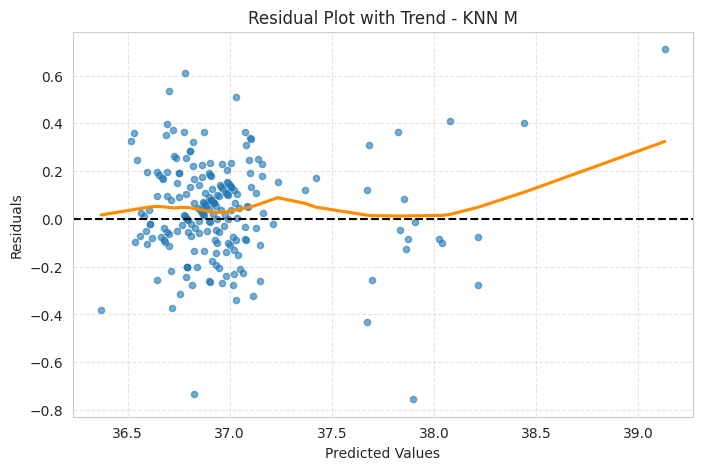

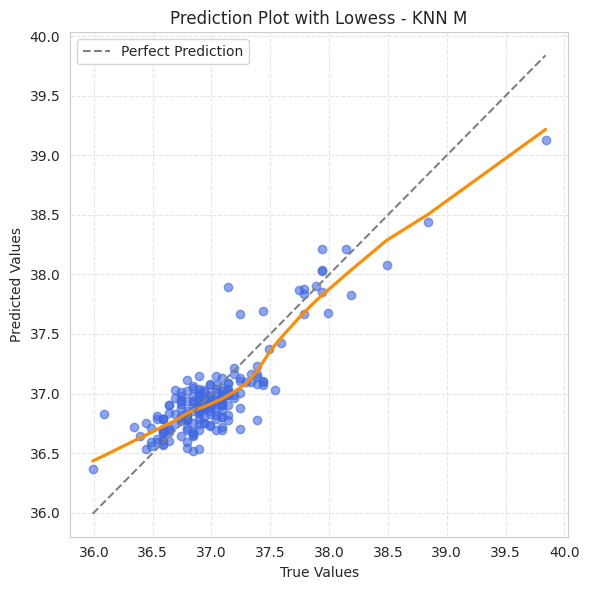

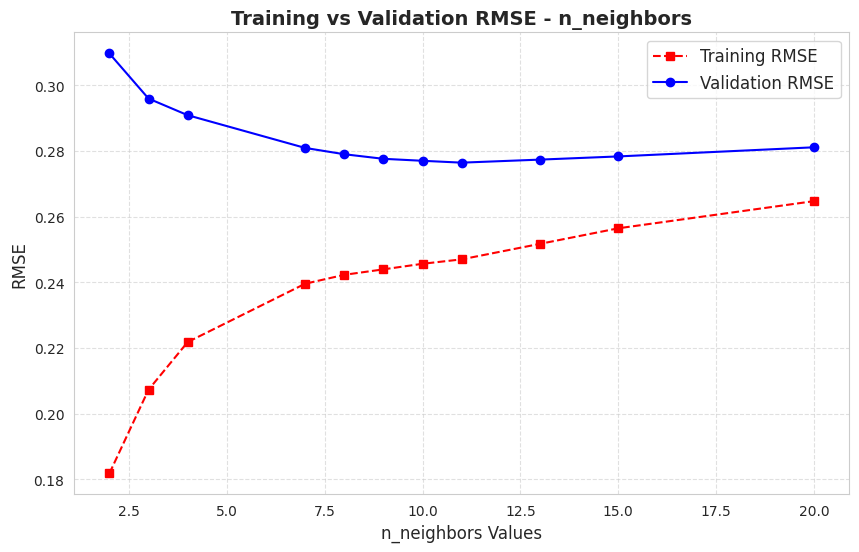

In [ ]:
regression_best_hyperparams_counter = defaultdict(int)

knn_resultsM, knn_best_modelM = monte_carlo_cv_regression_with_plot(
    knn_model,
    param_grid=knn_param_grid,
    X=X,
    y=y2,
    model_name="KNN M",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["KNN M"].to_csv(f"{save_path_r_m}/knn_mccv_results.csv", index=False)
knn_resultsM.to_csv(f"{save_path_r_m}/knn_summary.csv")


*All features were retained in this model.*  
K-Nearest Neighbors (KNN) does not require explicit feature selection, and its non-parametric nature allows it to model local patterns directly based on the training data. However, performance is sensitive to the choice of `n_neighbors`.

- **Best Hyperparameters:**  
    - `n_neighbors=10` (57/200 runs)  
    - `n_neighbors=11` (53/200 runs)
  
    - The training vs validation RMSE curve revealed diminishing returns beyond ~10 neighbors. This aligns with the most frequent hyperparameter selections, balancing underfitting (large k) and overfitting (small k).

- **Mean Performance (200 MCCV Iterations):**  
  - **RMSE:** 0.271 ± 0.018  
  - **MAE:** 0.203 ± 0.012  
  - **R² Score:** 0.709 ± 0.048

- **Prediction Plot (LOWESS Trend):**  
  - The predicted values closely follow the true oral temperatures, with slight underestimation at the higher range.
  - The orange LOWESS curve generally tracks the identity line, though some smoothing is observed due to local averaging.

- **Residual Plot (with Trend Line):**  
  - Residuals are mostly centered around zero with a flat spread across predicted values.
  - Slight structure appears at the extremes (especially above 38°C), where residuals tend to rise.
  - This may reflect KNN’s tendency to regress to the local mean, especially in regions with fewer nearby training points.

- **Advantages of KNN Regression:**  
  - Simple to implement and explain.
  - Naturally captures non-linear relationships without requiring model assumptions.
  - Effective when local neighborhoods contain informative patterns.

- **Limitations:**  
  - Sensitive to the choice of `k` and the distribution of training data.
  - Poor extrapolation beyond the training data range.
  - More computationally intensive at prediction time due to distance calculations.
  - Can struggle in regions with low density or overlapping temperatures (e.g., near the fever threshold).

> **Note:**  
> These plots reflect a single representative MCCV iteration. To gain insight into consistency and robustness, additional visualisations (e.g. density plots of RMSE or averaged LOWESS curves) across all iterations would be valuable.


## 4.8 XGBoost

**Fast mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2399

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2398

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2269

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2436

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2341

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for XGBoost...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators':

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.233     0.019     0.166    0.011    0.619   0.076


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 75} | Chosen: 111 out of 200 times
2. Params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 75} | Chosen: 89 out of 200 times


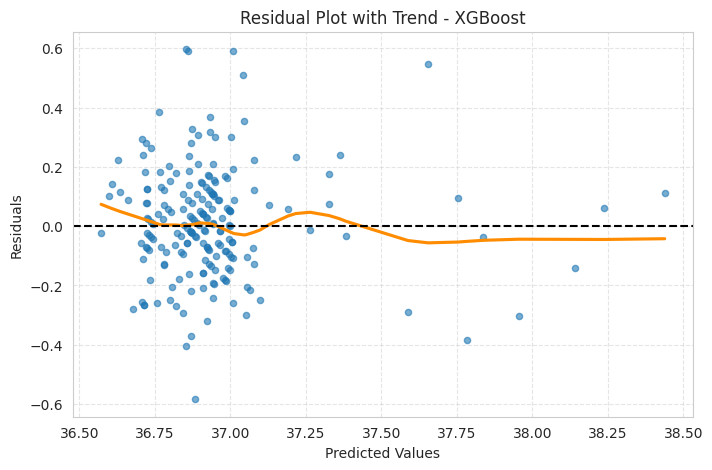

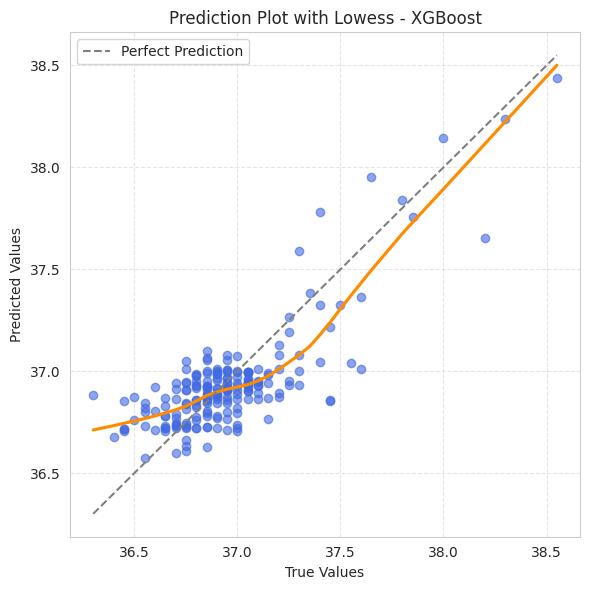

In [ ]:
xgb_model = XGBRegressor(random_state=2025, verbosity=0)
xgb_param_grid = {
    "n_estimators": [75],
    "max_depth": [3],
    "learning_rate": [0.05, 0.1]
}
regression_best_hyperparams_counter = defaultdict(int)

xgb_results, xgb_best_model = monte_carlo_cv_regression_with_plot(
    xgb_model,
    param_grid=xgb_param_grid,
    X=X,
    y=y,
    model_name="XGBoost",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["XGBoost"].to_csv(f"{save_path_r_f}/xgboost_mccv_results.csv", index=False)
xgb_results.to_csv(f"{save_path_r_f}/xgboost_summary.csv")


*All features were retained in this model.*  

- **Best Hyperparameters:**  
  - `max_depth=3`, `learning_rate=0.05`, `n_estimators=75`  
  - A broader sweep including `learning_rate=0.05` and `0.1` was explored. The most common configuration had a lower learning rate and moderate number of estimators, balancing complexity and generalisation effectively.
  - Both top configurations used `max_depth=3`, supporting the idea that shallow trees were sufficient to capture meaningful patterns in the data.

- **Mean Performance (200 MCCV Iterations):**  
  - **RMSE:** 0.233 ± 0.019  
  - **MAE:** 0.166 ± 0.011  
  - **R² Score:** 0.619 ± 0.076

- **Prediction Plot (LOWESS Trend):**  
  - Predictions closely follow the true temperature values, with minimal deviation across the range.
  - The LOWESS line aligns well with the perfect prediction line, particularly at the higher end, showing better calibration than simpler models.

- **Residual Plot (with Trend Line):**  
  - Residuals are tightly clustered with low variance, and the LOWESS trend shows minimal deviation from zero.
  - No strong patterns are visible in the residuals, indicating good model fit and minimal systematic error.
  - Slight asymmetry remains around the 37°C mark, where most samples lie, but it is substantially reduced compared to linear models.

- **Advantages of XGBoost:**  
  - Captures complex non-linear relationships through gradient boosting.
  - Excellent generalisation and performance due to tree regularisation.
  - Handles both numeric and categorical features effectively (when encoded appropriately).
  - Minimal tuning needed beyond early depth and learning rate selection.

- **Limitations:**  
  - Interpretation is more difficult compared to simpler models (e.g. coefficients in linear regression).
  - Still susceptible to overfitting if hyperparameters like tree depth and learning rate are not properly controlled.
  - Slight underestimation may occur in densely packed regions of the output space, as seen near 37°C.

> **Note:**  
> These plots represent a single Monte Carlo split. For deeper insight into model reliability, future work could include visualising averaged LOWESS or residual plots across all iterations.


**Monitor mode**


🔄 Monte Carlo Iteration 1/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2537

🔄 Monte Carlo Iteration 2/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2610

🔄 Monte Carlo Iteration 3/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2499

🔄 Monte Carlo Iteration 4/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2505

🔄 Monte Carlo Iteration 5/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75}
✅ Best CV RMSE: 0.2595

🔄 Monte Carlo Iteration 6/200...
🔍 Tuning hyperparameters for XGBoost M...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n

Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R2  Std R2
Results      0.249     0.017     0.189    0.011    0.754   0.043


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 75} | Chosen: 152 out of 200 times
2. Params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 75} | Chosen: 48 out of 200 times


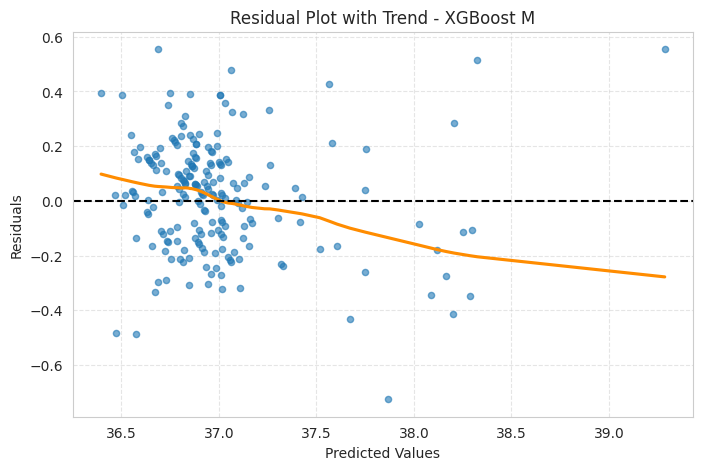

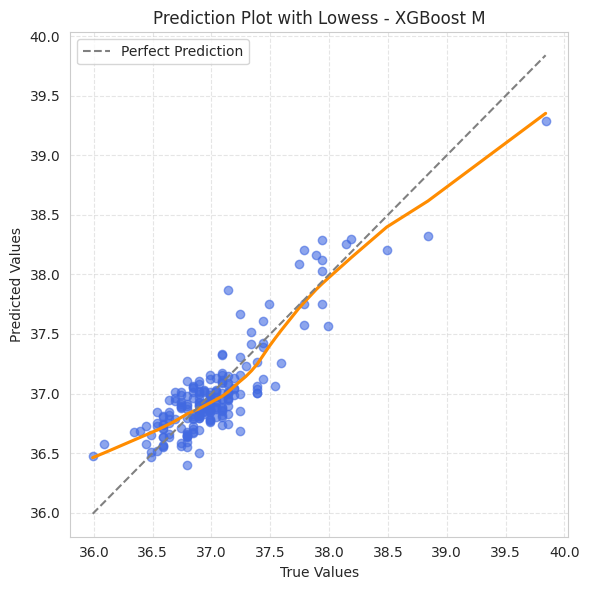

In [ ]:
regression_best_hyperparams_counter = defaultdict(int)

xgb_resultsM, xgb_best_modelM = monte_carlo_cv_regression_with_plot(
    xgb_model,
    param_grid=xgb_param_grid,
    X=X,
    y=y2,
    model_name="XGBoost M",
    num_iterations=200,
)

# Save results
regression_monte_carlo_results["XGBoost M"].to_csv(f"{save_path_r_m}/xgboost_mccv_results.csv", index=False)
xgb_resultsM.to_csv(f"{save_path_r_m}/xgboost_summary.csv")


*All features were retained in this model.*  
XGBoost includes built-in regularisation (via tree pruning and shrinkage) and performs internal feature selection through its boosting mechanism, which helps reduce overfitting while maintaining flexibility in capturing complex patterns.

- **Best Hyperparameters:**  
  - `max_depth=3`, `learning_rate=0.1`, `n_estimators=75`  
  - These settings were chosen **152 out of 200** times, showing very high consistency in optimal configuration across iterations.  
  - A smaller depth and moderate learning rate allowed the model to generalise without excessive variance.

- **Mean Performance (200 MCCV Iterations):**  
  - **RMSE:** 0.249 ± 0.017  
  - **MAE:** 0.189 ± 0.011  
  - **R² Score:** 0.754 ± 0.043

- **Prediction Plot (LOWESS Trend):**  
  - The predictions align well with the true values, particularly at the higher end of the temperature spectrum.
  - The orange LOWESS line tracks the perfect prediction line closely, with minor deviations in the lower range (~36.5–37°C).

- **Residual Plot (with Trend Line):**  
  - Residuals show mild negative bias at higher predicted values, indicating slight underprediction in those cases.
  - However, the overall spread is relatively balanced with no extreme outliers or major curvature.

- **Advantages of XGBoost Regression:**  
  - High predictive performance and generalisation across temperature ranges.
  - Inherently handles non-linearities and interactions without manual feature engineering.
  - Consistent hyperparameter selection suggests reliable optimisation and model stability.

- **Limitations:**  
  - Less interpretable than linear models; individual feature contributions are not straightforward.
  - Like other tree ensembles, XGBoost does not naturally produce confidence intervals for predictions.
  - Residual trends hint at slight systemic underprediction for higher temperatures, which may require post-correction or calibration in deployment.

> **Note:**  
> These plots show results from one fold of the Monte Carlo CV. Averaged or distributional residual/prediction plots across all 200 folds would enhance the interpretation of model consistency.


## 4.9 Comparing Results

Load in the results

In [ ]:
# For Regression results
Fast_results_df_reg = load_mccv_results(save_path_r_f)
Monitor_results_df_reg = load_mccv_results(save_path_r_m)
display(Fast_results_df_reg)
display(Monitor_results_df_reg)

Iteration      RMSE       MAE        R2              model
0             1  0.288489  0.208037  0.398848  linear_regression
1             2  0.287988  0.211618  0.499682  linear_regression
2             3  0.334455  0.225983  0.388783  linear_regression
3             4  0.294637  0.198004  0.490985  linear_regression
4             5  0.309944  0.218592  0.434600  linear_regression
...         ...       ...       ...       ...                ...
1195        196  0.243577  0.172633  0.577210            xgboost
1196        197  0.233799  0.169749  0.587788            xgboost
1197        198  0.233998  0.163187  0.611626            xgboost
1198        199  0.237729  0.167209  0.593688            xgboost
1199        200  0.207163  0.151318  0.692121            xgboost

[1200 rows x 5 columns]

Iteration      RMSE       MAE        R2              model
0             1  0.327949  0.244697  0.563275  linear_regression
1             2  0.316204  0.247226  0.628132  linear_regression
2             3  0.349289  0.267164  0.530714  linear_regression
3             4  0.328674  0.238204  0.605517  linear_regression
4             5  0.330313  0.249243  0.625484  linear_regression
...         ...       ...       ...       ...                ...
1195        196  0.238164  0.185820  0.781869            xgboost
1196        197  0.237015  0.187606  0.723735            xgboost
1197        198  0.239149  0.186028  0.767307            xgboost
1198        199  0.225621  0.173758  0.792246            xgboost
1199        200  0.229723  0.176911  0.774776            xgboost

[1200 rows x 5 columns]

In [ ]:
# Regression results - Summary
Fast_results_df_summary_reg = load_mccv_results(save_path_r_f, "summary").iloc[:, 1:]
Monitor_results_df_summary_reg = load_mccv_results(save_path_r_m, "summary").iloc[:, 1:]

print("Fast Mode")
print(tabulate(Fast_results_df_summary_reg, headers="keys", tablefmt="fancy_grid", showindex=False))
print("Monitor Mode")
print(tabulate(Monitor_results_df_summary_reg, headers="keys", tablefmt="fancy_grid", showindex=False))


Fast Mode
╒═════════════╤════════════╤════════════╤═══════════╤═══════════╤═══════════╤═══════════════════╕
│   Mean RMSE │   Std RMSE │   Mean MAE │   Std MAE │   Mean R2 │    Std R2 │ model             │
╞═════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════════════╡
│    0.295938 │  0.0203268 │   0.214783 │ 0.0119218 │  0.391025 │ 0.0830929 │ linear_regression │
├─────────────┼────────────┼────────────┼───────────┼───────────┼───────────┼───────────────────┤
│    0.244758 │  0.0171892 │   0.177805 │ 0.0106291 │  0.582346 │ 0.0667776 │ elastic_net       │
├─────────────┼────────────┼────────────┼───────────┼───────────┼───────────┼───────────────────┤
│    0.252484 │  0.0229733 │   0.177488 │ 0.0126157 │  0.553031 │ 0.0933665 │ decision_tree     │
├─────────────┼────────────┼────────────┼───────────┼───────────┼───────────┼───────────────────┤
│    0.234902 │  0.0183073 │   0.168515 │ 0.0107715 │  0.612969 │ 0.0788934 │ random_forest     │
├─────────

#### Performance Metrics

**Fast mode**

Fast Mode


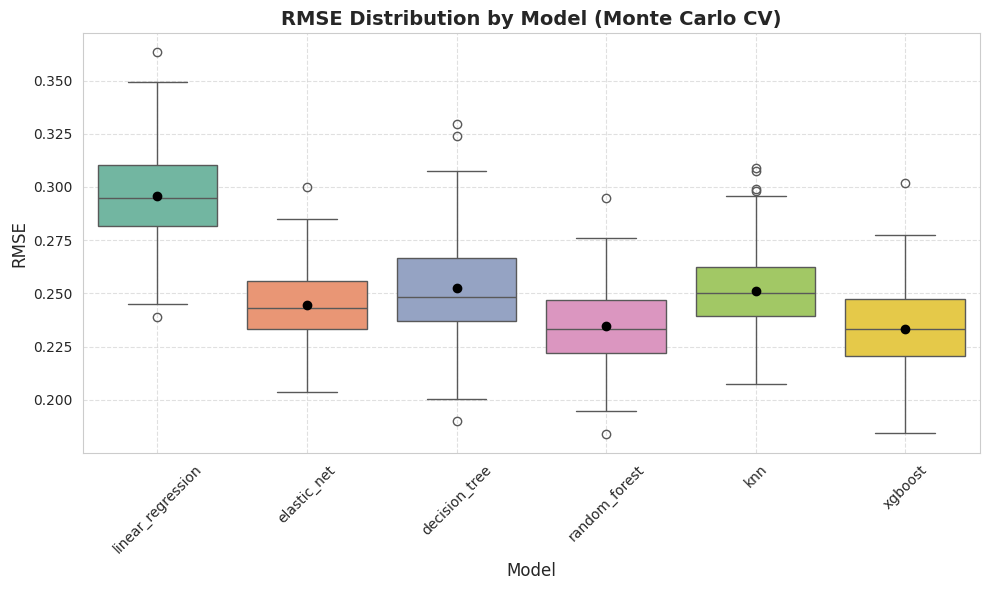

In [ ]:
model_results_dict = {
    model: Fast_results_df_reg[Fast_results_df_reg["model"] == model]
    for model in Fast_results_df_reg["model"].unique()
}

# Plot any metric you like
print("Fast Mode")
plot_metric_boxplot_comparison(model_results_dict, metric_name="RMSE")


**Monitor mode**

Monitor Mode


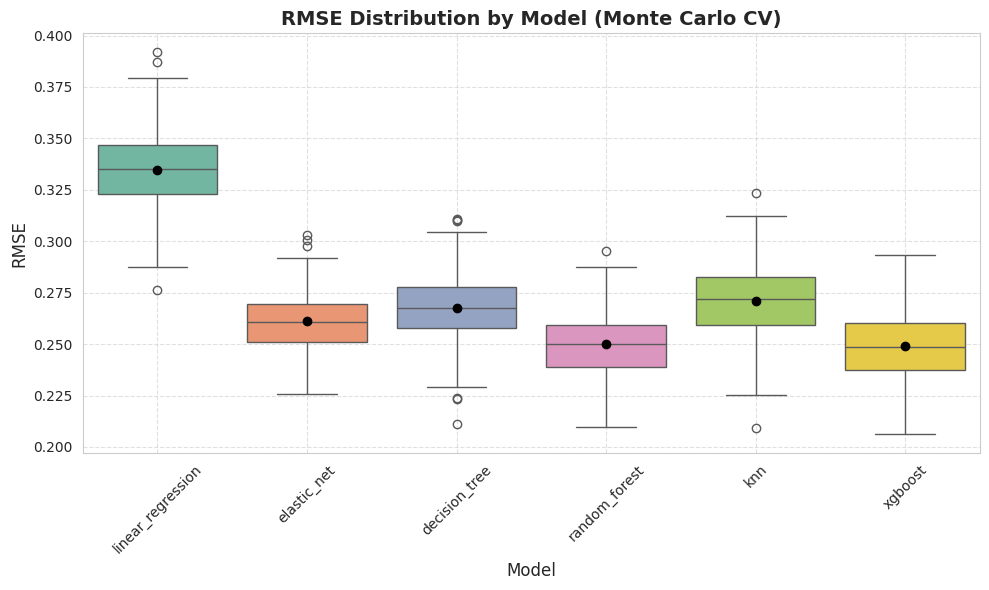

In [ ]:
model_results_dictM = {
    model: Monitor_results_df_reg[Monitor_results_df_reg["model"] == model]
    for model in Monitor_results_df_reg["model"].unique()
}

# Plot any metric you like
print("Monitor Mode")
plot_metric_boxplot_comparison(model_results_dictM, metric_name="RMSE")


### Model Selection
The goal is to estimate continuous oral temperature values as closely as possible to clinical measurements. Accurate regression is critical, as small deviations could lead to misclassifications in downstream fever screening. Therefore, **model selection was based primarily on RMSE (Root Mean Squared Error)**, which penalizes larger errors more severely than MAE. R² scores were also considered to understand how much variance each model explained, and standard deviations were used to evaluate model stability.

Model selection was performed independently for **Fast Mode** and **Monitor Mode** using **200 Monte Carlo Cross-Validation (MCCV) iterations**. These results are visualized using boxplots and summarized in tables for RMSE, MAE, and R².

**Fast Mode - Regression**

For Fast Mode predictions (aveOralF), six regression models were compared. These predictions are based on shorter infrared scans and are more susceptible to noise, making this a slightly more challenging setting.

Across all models, **XGBoost** achieved the **lowest mean RMSE (0.233 ± 0.019)**, followed closely by **Random Forest (0.235 ± 0.018)** and **Elastic Net (0.245 ± 0.017)**. These three models consistently outperformed KNN, Decision Tree, and especially Linear Regression, which showed the **highest RMSE (0.296 ± 0.020)** and lowest R² (0.391 ± 0.083).

Notably:

- **XGBoost** delivered the best overall performance, capturing non-linear patterns with high consistency. It also showed a relatively narrow distribution of RMSE values, indicating stable performance across iterations.

- **Random Forest**, while slightly behind, offered similarly strong results and could be favoured in cases where model robustness and outlier handling are critical.

- **Elastic Net** stood out among linear models. Its built-in regularisation made it more resilient to overfitting than standard linear regression, and it achieved strong accuracy with faster training times.

- **KNN** and **Decision Tree** were ok but showed slightly higher variance and lower R², suggesting potential sensitivity to specific data splits.

- **Linear Regression**, while interpretable, struggled in this setting due to its limited capacity to model non-linear patterns.

> **Conclusion - Fast Mode:**  
> If interpretability and efficiency are critical, **Elastic Net** is a strong option with minimal trade-off. However, for highest predictive performance, **XGBoost** or **Random Forest** are recommended.


**Monitor Mode - Regression**

Monitor Mode predictions (aveOralM) represent longer and more stable measurements, which generally led to improved performance across models.

Once again, **XGBoost** was the top-performing model with an RMSE of **0.249 ± 0.017** and the **highest R² (0.754 ± 0.043)**. **Random Forest (0.250 ± 0.015)** matched this performance closely, with **Elastic Net (0.261 ± 0.014)** and **Decision Tree (0.268 ± 0.017)** also performing well.

Highlights:

- **XGBoost** and **Random Forest** remained the strongest models, delivering the **lowest prediction error** and **highest explained variance**.

- **Ridge Regression**  performed well, offering a stable and interpretable solution with good accuracy.

- **KNN**, while simple, achieved **0.271 ± 0.018**, competitive with tree-based.

- **Linear Regression** remained the weakest model, with a relatively high RMSE (0.335 ± 0.019) and lower R² (0.557 ± 0.065).

> **Conclusion - Monitor Mode:**  
> The longer, higher-quality measurements in Monitor Mode allowed all models to improve. However, **XGBoost and Random Forest** were again the most accurate. **Ridge Regresssion** remained a strong choice for interpretable applications, especially where computational resources are limited.

**Fast vs Monitor Mode**

The comparison across modes reveals a consistent pattern: **all models perform better in Monitor Mode**, with lower RMSE and tighter variance. This is expected, as the input data is less noisy and more representative of actual oral temperature.

Across both modes:

- **XGBoost** was the most accurate and consistent model overall.
- **Random Forest** offered similar performance and may be preferred in some use cases for its easier parallelisation and tuning.
- **Elastic Net** held its ground across settings, consistently outperforming plain Linear Regression and offering a transparent alternative to black-box models.

This suggests that even though model rankings remain consistent across Fast and Monitor Mode, the **gap in performance between models narrows with higher-quality data**. Therefore, the final model selection should be guided not only by metrics, but also by factors like interpretability, runtime efficiency, and deployment context.


### Feature Importance

In [ ]:
def summarize_feature_importance(model_name, top_n=25):
    if model_name not in regression_feature_importance_dict:
        print(f"❌ No feature importance data available for '{model_name}'.")
        return

    model = regression_model_results[model_name]["model"]
        # Get expected number of features from the model
    expected_n_features = len(model.feature_names_in_)

    # Stack only valid runs
    valid_runs = []
    for i, run in enumerate(regression_feature_importance_dict[model_name]):
        arr = np.asarray(run)
        if arr.shape[0] == expected_n_features:
            valid_runs.append(arr)
        else:
            print(f"Skipping run {i}: expected {expected_n_features} features, got {arr.shape[0]}, likely due to one hot encoded categorical varibale did not appear in test set for this run")

    if len(valid_runs) == 0:
        print("❌ No valid runs found with matching feature count.")
        return

    importances = np.vstack(valid_runs)
    #importances = np.array(regression_feature_importance_dict[model_name])
    feature_names = model.feature_names_in_

    if hasattr(model, "coef_"):
        import_type = "Coefficient"
        means = importances.mean(axis=0)
        stds = importances.std(axis=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            cis = st.t.interval(0.95, df=len(importances)-1, loc=means, scale=st.sem(importances, axis=0))
    else:
        import_type = "Feature Importance"
        means = importances.mean(axis=0)
        stds = importances.std(axis=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            cis = st.t.interval(0.95, df=len(importances)-1, loc=means, scale=st.sem(importances, axis=0))

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        f"Mean {import_type}": means,
        "Std Dev": stds,
        "95% CI Lower": cis[0],
        "95% CI Upper": cis[1]
    })

    importance_df = importance_df.reindex(importance_df[f"Mean {import_type}"].abs().sort_values(ascending=False).index)
    display(importance_df.head(top_n))
    return importance_df
def plot_model_importance(model_name, top_n=25):
    """
    Wrapper to summarize and plot feature importance for a regression model.
    """
    if model_name not in regression_feature_importance_dict:
        print(f"❌ No feature importance data available for '{model_name}'.")
        return

    model = regression_model_results[model_name]["model"]

    # Get importance DataFrame
    importance_df = summarize_feature_importance(model_name, top_n=top_n)
    if importance_df is None:
        return

    # Select correct column name
    if hasattr(model, "coef_"):
        importance_col = "Mean Coefficient"
        show_sign_legend = True
        show_signed_axis = True
    else:
        importance_col = "Mean Feature Importance"
        show_sign_legend = False
        show_signed_axis = False

    # Plot
    plot_feature_importance_barplot(
        importance_df=importance_df,
        top_n=top_n,
        model_name=model_name,
        importance_col=importance_col,
        show_sign_legend=show_sign_legend,
        show_signed_axis=show_signed_axis
    )


Feature  Mean Coefficient   Std Dev  \
27                               num__T_Max1          0.042503  0.012590   
28                                num__T_OR1          0.035530  0.010598   
29                            num__T_OR_Max1          0.035422  0.010389   
18                           num__canthiMax1          0.012968  0.002631   
19                          num__canthi4Max1          0.012729  0.002641   
11                            num__T_RC_Max1          0.011955  0.004129   
8                                 num__T_RC1          0.011613  0.004001   
10                            num__T_RC_Wet1          0.009779  0.004411   
25                            num__T_FH_Max1          0.007590  0.016128   
0                                 num__T_atm         -0.005144  0.016321   
9                             num__T_RC_Dry1          0.004058  0.001621   
39  cat__Ethnicity_Black or African-American          0.003960  0.012562   
42                      cat__Ethnicity_White         -0.003018  0.009619   
21                              num__T_FHRC1         -0.002283  0.007416   
7                           num__aveAllL13_1         -0.002000  0.006489   
12                                num__T_LC1          0.001695  0.001553   
23                              num__T_FHBC1          0.001676  0.005533   
20                              num__T_FHCC1         -0.001676  0.005468   
15                            num__T_LC_Max1          0.001642  0.001732   
31                            cat__Age_21-25          0.001405  0.004666   

    95% CI Lower  95% CI Upper  
27      0.040826      0.044179  
28      0.034119      0.036941  
29      0.034038      0.036805  
18      0.012618      0.013319  
19      0.012377      0.013080  
11      0.011406      0.012505  
8       0.011080      0.012146  
10      0.009192      0.010367  
25      0.005443      0.009738  
0      -0.007317     -0.002970  
9       0.003842      0.004274  
39      0.002287      0.005633  
42     -0.004299     -0.001737  
21     -0.003270     -0.001295  
7      -0.002864     -0.001135  
12      0.001488      0.001902  
23      0.000939      0.002413  
20     -0.002404     -0.000947  
15      0.001411      0.001873  
31      0.000784      0.002026

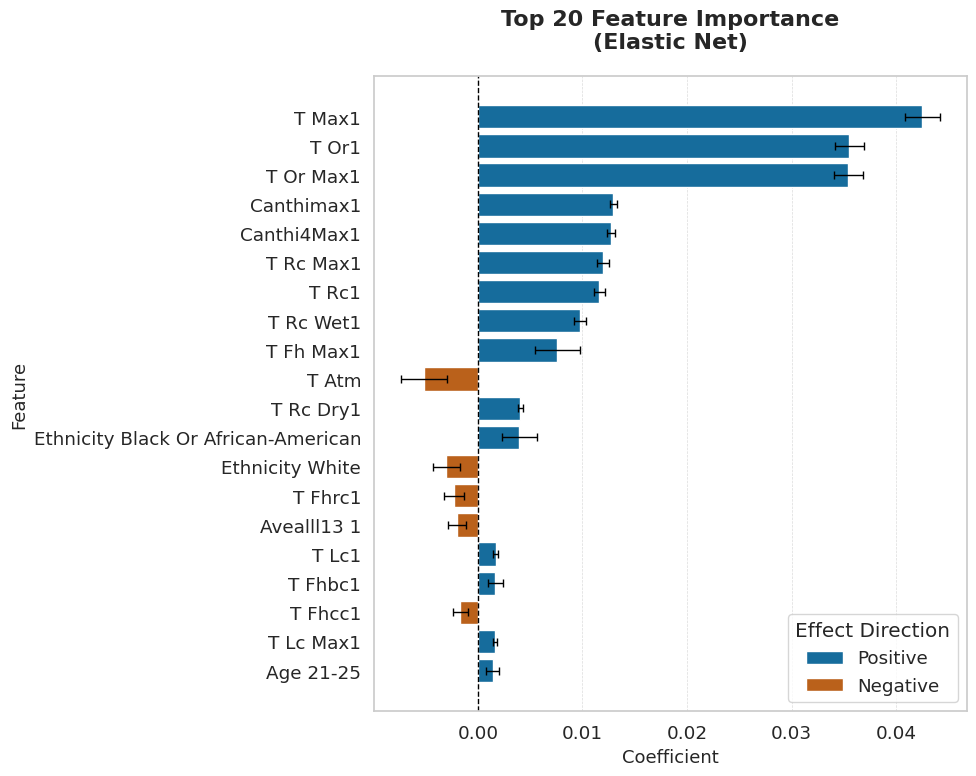

In [ ]:
plot_model_importance("Elastic Net", top_n=20)


**Fast Mode (Elastic Net Regression)**

To interpret how the Elastic Net model predicts oral temperature in Fast Mode, we examined the top 20 features ranked by mean coefficient magnitude across **200 Monte Carlo Cross-Validation (MCCV) iterations**. The **horizontal bars show the mean coefficients**, while **error bars represent standard deviation**, giving insight into both average effect size and consistency across folds.

**Top Predictive Features - Thermal Inputs**

The most influential predictors are all temperature-derived features from specific facial regions:

- **T_Max1 (Mean Coefficient: 0.0425 ± 0.0126)**  
  The most important predictor overall, representing the **maximum facial temperature** captured from thermal imaging. Its strong and consistent positive association reflects its relevance to internal temperature.

- **T_OR1 (0.0355 ± 0.0106)** and **T_OR_Max1 (0.0354 ± 0.0104)**  
  These features relate to the **oral region**, which is biologically tied to core body temperature and thus highly predictive.

- **canthiMax1 (0.0130 ± 0.0026)** and **canthi4Max1 (0.0127 ± 0.0026)**  
  These refer to **maximum temperatures in the inner eye (canthi) region**, a well-known site for non-contact temperature measurement due to high blood flow and proximity to the brain.

- **T_RC_Max1 (0.0120 ± 0.0041)**  
  Another high-impact feature from the **rectangular canthi region**, reinforcing the importance of ocular areas.

Together, these results confirm that **physiologically meaningful regions** — especially the **mouth and eyes** — dominate the regression model. These areas consistently reflect internal body heat and are less influenced by ambient noise than peripheral zones.

**Environmental & Demographic Contributions**

- **T_Atm (ambient temperature)** is one of the few negatively-weighted features, showing a small but consistent negative association. This aligns with expectations: **higher ambient temperatures reduce contrast between skin and background**, making it harder to detect elevated body temperatures.

- **Demographic variables such as Ethnicity (e.g., White, Black or African-American)** and **Age (e.g., 21–25)** appear further down the list with smaller magnitudes. While these may reflect subtle physiological or imaging differences, their broader error bars suggest caution in interpretation.

**Interpreting Coefficients**

- Features with **larger absolute coefficients and narrow error bars** (e.g., T_Max1, T_OR1, canthiMax1) are **likely to represent stable, genuine relationships** with oral temperature.

- Features **closer to zero or with wider error bars** indicate **less reliable or more fold-dependent effects**, and may not generalise well to new data.

> **Note:** Elastic Net combines L1 and L2 regularisation, which not only helps prevent overfitting but also performs **automatic feature selection** by shrinking weaker predictors toward zero. Therefore, the features shown here represent **only the most consistently relevant signals**.

Overall, the dominant role of core facial regions supports the use of infrared thermal imaging for non-contact fever screening in practical settings.


Feature  Mean Feature Importance   Std Dev  95% CI Lower  \
28            num__T_OR1                 0.245839  0.090626      0.233171   
27           num__T_Max1                 0.179914  0.069246      0.170234   
29        num__T_OR_Max1                 0.155758  0.078141      0.144835   
25        num__T_FH_Max1                 0.041723  0.013431      0.039846   
10        num__T_RC_Wet1                 0.031942  0.020855      0.029027   
11        num__T_RC_Max1                 0.023186  0.027750      0.019307   
18       num__canthiMax1                 0.021130  0.014518      0.019100   
8             num__T_RC1                 0.018528  0.007823      0.017435   
42  cat__Ethnicity_White                 0.015936  0.006323      0.015052   
1          num__Humidity                 0.015415  0.005146      0.014696   

    95% CI Upper  
28      0.258508  
27      0.189594  
29      0.166681  
25      0.043601  
10      0.034858  
11      0.027065  
18      0.023159  
8       0.019622  
42      0.016820  
1       0.016134

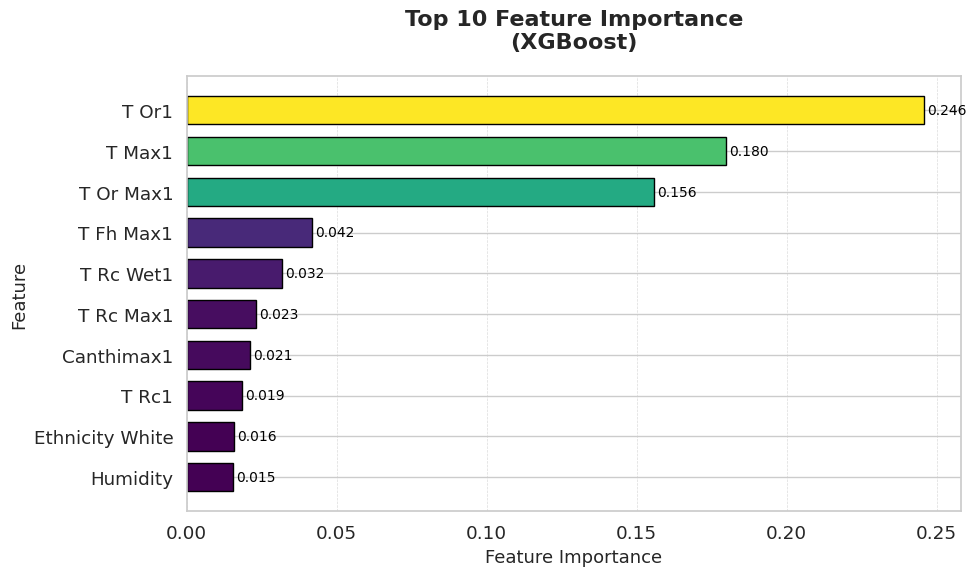

In [ ]:
plot_model_importance("XGBoost", top_n=10)

**Feature Importance - Fast Mode (XGBoost Regression)**

To better understand what the most important features in the XGBoost model for Fast Mode oral temperature, the top 10 features by **mean importance scores**, averaged across **200 Monte Carlo Cross-Validation (MCCV) iterations** are visualised. Feature importance here is based on the **contribution of each variable to splits across all trees**, with values normalised and mean ± standard deviation displayed in the chart above.

**Top Predictive Features - Dominance of Oral and Maximum Temperature**

- **T_OR1 (0.246 ± 0.091)**  
  This was the most important feature in the XGBoost model, contributing nearly 25% of total split gain. T_OR1 refers to the **average temperature in the oral region**.

- **T_Max1 (0.180 ± 0.069)**  
  The second most influential predictor, T_Max1 reflects the **maximum observed facial temperature**, a commonly used marker in thermal fever screening.

- **T_OR_Max1 (0.156 ± 0.078)**  
  Captures the **maximum temperature in the oral area**, complementing T_OR1 and showing strong predictive contribution.

These three features alone account for over **58% of total model importance**, confirming that **thermal patterns around the mouth** are key indicators in fast infrared measurements.

**Secondary Thermal Features**

- **T_FH_Max1 (0.042 ± 0.013)**  
  This is the **maximum temperature in the forehead region**, another relevant site for fever detection. While less influential than the oral area, it adds valuable context in noisy fast mode conditions.

- **T_RC_Wet1 (0.032 ± 0.021)** and **T_RC_Max1 (0.023 ± 0.028)**  
  Both come from **canthi or periocular regions**, specifically targeting wet zones known for high blood perfusion and temperature sensitivity. Their importance is lower than oral regions but still consistent with thermographic theory.

- **canthiMax1 and T_RC1** appear further down the list, suggesting **redundant but supporting signals** from nearby facial areas.

**Environmental and Demographic Contributions**

- **Ethnicity White (0.016)** and **Humidity (0.015)** were included among the top 10, though their contribution was minimal compared to core facial thermal features. Their relatively low values suggest **non-negligible but weak effects**, potentially related to variation in skin emissivity or environmental measurement noise.

**Interpreting XGBoost Importances**

Unlike Elastic Net, which returns directionally interpretable coefficients, XGBoost provides **nonlinear, interaction-aware importance scores**. As such:

- Features with **higher importance scores** were more frequently used in informative splits.
- However, XGBoost **does not indicate direction (positive/negative)** or linearity.
- Importance magnitudes also **do not represent effect size** but relative contribution to model performance.


Overall, this analysis confirms that **mouth and high-temperature zones dominate predictive power** in Fast Mode IR imaging, regardless of model type. XGBoost effectively captures these relationships, including **nonlinear interactions**, making it a powerful tool for high-performance regression tasks when interpretability is less critical.


Feature  Mean Feature Importance   Std Dev  95% CI Lower  \
27       num__T_Max1                 0.322008  0.077818      0.311130   
10    num__T_RC_Wet1                 0.171232  0.084313      0.159446   
29    num__T_OR_Max1                 0.070320  0.022048      0.067237   
18   num__canthiMax1                 0.069212  0.114444      0.053214   
19  num__canthi4Max1                 0.056958  0.078357      0.046004   
28        num__T_OR1                 0.033104  0.012215      0.031396   
11    num__T_RC_Max1                 0.023851  0.010719      0.022352   
8         num__T_RC1                 0.019229  0.022961      0.016019   
25    num__T_FH_Max1                 0.017743  0.006656      0.016813   
30  cat__Gender_Male                 0.012285  0.003369      0.011814   

    95% CI Upper  
27      0.332886  
10      0.183018  
29      0.073402  
18      0.085210  
19      0.067911  
28      0.034811  
11      0.025349  
8       0.022439  
25      0.018673  
30      0.012756

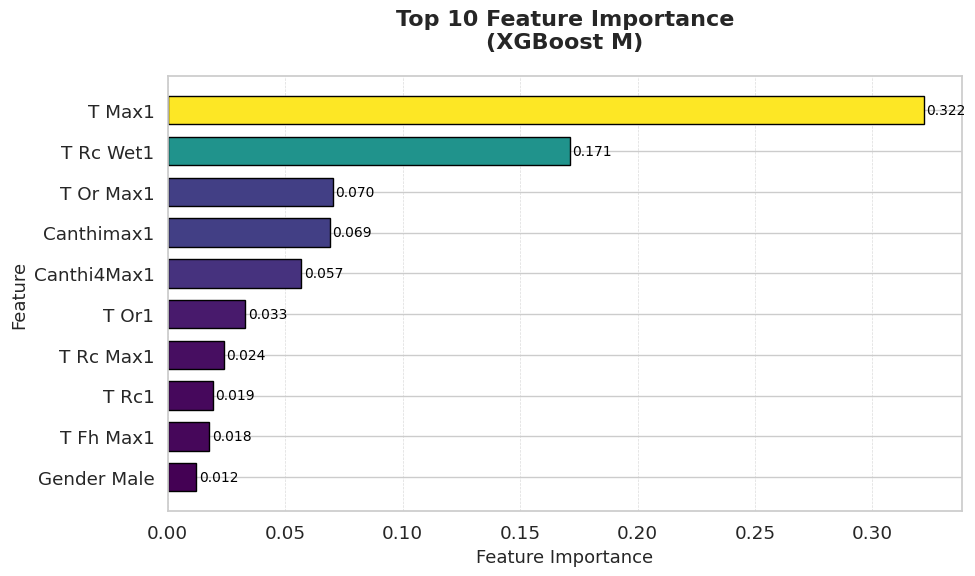

In [ ]:
plot_model_importance("XGBoost M", top_n=10)

**Feature Importance - Monitor Mode (XGBoost Regression)**

**Top Predictive Features – Strong Dominance of T_Max1**

- **T_Max1 (0.322 ± 0.078)**  
  The maximum temperature recorded across the facial image was the most dominant feature by far. It captures **localised hotspots**, often corresponding to regions of core heat emission.

- **T_RC_Wet1 (0.171 ± 0.084)**  
  The **wet region of the canthus**, near the inner eye corner, ranked second. Its importance highlights the **vascularised, moist area** of the eye as a key thermoregulation site, consistently informative in infrared thermography.

Together, T_Max1 and T_RC_Wet1 contributed nearly **50% of total model importance**, underlining their important role in accurate temperature prediction.

**Consistently Informative Thermal Features**

- **T_OR_Max1 (0.070 ± 0.022)** and **T_OR1 (0.033 ± 0.012)**  
  These correspond to **maximum and average temperatures in the oral region**, respectively. Their relevance reinforces the clinical logic that **oral zones align closely with internal body temperature** — even in contactless IR sensing.

- **canthiMax1 (0.069 ± 0.114)** and **canthi4Max1 (0.057 ± 0.078)**  
  Both features originate from the **extended canthi region**, a known area of thermal sensitivity due to proximity to the eye and high blood flow. While these features contributed less than the oral or max facial temperatures, their presence suggests **redundant yet supportive signals** useful in noisy thermal imaging conditions.

- **T_RC_Max1**, **T_RC1**, and **T_FH_Max1**  
  These additional facial temperature descriptors provided small but stable contributions, helping to **contextualise maximum readings with local regional data** from the canthus, cheeks, and forehead.

**Demographic Influence**

- **Gender Male (0.012 ± 0.003)** was the only categorical demographic variable in the top 10. There may be **subtle temperature profile differences between sexes**, although its effect was relatively minor compared to thermal features.

In summary, **Monitor Mode regression using XGBoost** heavily relied on core facial temperature features, particularly **T_Max1** and **T_RC_Wet1**, reaffirming that thermal hotspots and physiologically sensitive regions are critical in predicting body temperature using non-contact methods.


# **5. NEURAL NETWORKS**  

Following the implementation of linear and tree-based models, more advanced models were explored using neural networks, specifically using a multilayer perceptron (MLP) built with PyTorch.

## PyTorch MLP

> Reload dataset and relevent librarys

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- Load and Prepare Raw Data ---- #
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

infrared_thermography_temperature = fetch_ucirepo(id=925)

X = infrared_thermography_temperature.data.features
y = infrared_thermography_temperature.data.targets

print(infrared_thermography_temperature.metadata)
infrared_thermography_temperature.variables

X = X[X["Distance"] <= 10]  # Remove outliers from X
y = y.loc[X.index]  # Keep only corresponding values in y
# Convert 'aveOralF' and 'aveOralM' into binary fever classification (Yes/No)
y.loc[:, "OralF_Fever"] = y["aveOralF"].apply(lambda x: "Yes" if x >= 37.5 else "No")
y.loc[:, "OralM_Fever"] = y["aveOralM"].apply(lambda x: "Yes" if x >= 37.5 else "No")
y_full = y.copy()
y = y_full["OralF_Fever"]
y2 = y_full["OralM_Fever"]

def encode_binary_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "Yes" in unique_labels and "No" in unique_labels:
            print("🔁 Converting 'Yes' to 1 and 'No' to 0...")
            return pd.Series(y).replace({"Yes": 1, "No": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels are already correctly encoded (0=No Fever, 1=Fever).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")

y = encode_binary_labels(y)
y2 = encode_binary_labels(y2)

df = pd.concat([X, y], axis=1)
df2 = pd.concat([X, y2], axis=1)

## 5.1 Classification with Nested Cross-Validation



**Model: MLP (Multilayer Perceptron)**  
- Defined using `nn.Sequential`, with:
  - Two hidden layers (`hidden1`, `hidden2`)
  - ReLU activations
  - Dropout layers for regularisation
  - Final output layer with a single neuron and sigmoid activation (via `BCEWithLogitsLoss`)

**Outer Loop: 10-Fold Cross-Validation**

  - `KFold(n_splits=10)` is used to divide the dataset into:
  - 1 fold for final **test evaluation**
  - 9 folds for **model training**

  - For each outer fold:
  - Performance metrics (F1, Precision, Recall, Accuracy, AUC) are computed on the held-out test set.

**Inner Loop: 5-Fold Cross-Validation**

 - Purpose: Hyperparameter tuning  

  - `KFold(n_splits=5)` is applied to the training portion from the outer loop.
  - Each candidate configuration (e.g. hidden layer sizes, dropout) is evaluated across 5 inner folds.
  - The configuration with the **highest average F1-score** is selected.

**Preprocessing (Done Separately per Outer Fold)**

- Numerical Features:
  - Imputed using `KNNImputer`
  - Scaled with `StandardScaler`

- Categorical Features:
  - One-hot encoded using `OneHotEncoder` (`drop='first'`)

- This preprocessing is encapsulated in a `ColumnTransformer` and **fit only on training folds** to avoid data leakage.

**Model Training**

- **Loss Function**: `BCEWithLogitsLoss` (binary classification)
- **Optimizer**: Adam
- **Batch Size**: 32

- **Early Stopping**:
  - Training stops if validation loss doesn't improve for 10 epochs.
  - The best model (lowest val loss) is restored.

**Threshold Tuning (for F1 Optimisation)**

- After training, validation predictions (probabilities) are used to find the **F1-optimal threshold**:
  - Thresholds from 0.01 to 0.99 are tested.
  - The one with the **highest F1 score** is selected.
  - This threshold is used for test set classification.

**Learning Curve Plot**  
- Training and validation losses per epoch are stored.
- Curves from each outer fold are averaged.
- A shaded region shows ±1 std deviation.
- A vertical dashed line indicates the **average early stopping epoch**.
- Useful for diagnosing overfitting and underfitting.


**Final Outputs**

- **Average Performance (across outer folds)**:
  - **F1-Score**, **Precision**, **Recall**, **Accuracy**, **AUC**
  - Reported with ± standard deviation

- **ROC Curve Plot**:
  - Mean ROC curve across outer folds
  - Shaded confidence interval around TPR

- **Box Plot Comparison**:
  - MLP F1-scores compared with strong performing model: XGBoost

This nested CV function is modular and reusable for Fast Mode and Monitor Mode. Mitigates overfitting with early stopping and hyperparameter tuning.


In [26]:
# ---- Define MLP Model Class ---- #
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.net(x)

# ---- Training & Evaluation Function with Threshold Search ---- #
def train_evaluate_model(X_train, y_train, X_val, y_val, params, return_preds=False):
    model = MLP(input_dim=X_train.shape[1], **params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    best_model = None
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(500):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model = best_model
    model.eval()
    with torch.no_grad():
        y_val_logits = model(X_val_tensor).numpy().flatten()
        y_val_probs = 1 / (1 + np.exp(-y_val_logits))

    # Threshold selection based on F1
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_val, y_val_probs >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1s)]

    y_val_preds = (y_val_probs >= best_threshold).astype(int)
    auc = roc_auc_score(y_val, y_val_probs)

    if return_preds:
        return y_val, y_val_preds, y_val_probs, best_threshold

    return {
        'F1': f1_score(y_val, y_val_preds),
        'Precision': precision_score(y_val, y_val_preds),
        'Recall': recall_score(y_val, y_val_preds),
        'Accuracy': accuracy_score(y_val, y_val_preds),
        'AUC': auc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_threshold': best_threshold,
        'roc_curve': roc_curve(y_val, y_val_probs)
    }

# ---- Nested CV ---- #
def run_nested_cv_classifier(X_raw, y_raw, param_grid):
    outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_kf = KFold(n_splits=5, shuffle=True, random_state=1)

    X_raw = X_raw.reset_index(drop=True)
    y_raw = y_raw.reset_index(drop=True).values

    results = []
    fpr_all, tpr_all = [], []
    thresholds_all = []
    train_loss_curves, val_loss_curves = [], []

    for fold, (train_idx, test_idx) in enumerate(outer_kf.split(X_raw)):
        print(f"\n🔁 Outer Fold {fold+1}")
        X_outer_train_raw, X_outer_test_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
        y_outer_train_raw, y_outer_test_raw = y_raw[train_idx], y_raw[test_idx]

        categorical_cols = X_outer_train_raw.select_dtypes(include='object').columns.tolist()
        numerical_cols = X_outer_train_raw.select_dtypes(include=[np.number]).columns.tolist()

        preprocessor = ColumnTransformer(transformers=[
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ])

        X_outer_train = preprocessor.fit_transform(X_outer_train_raw)
        X_outer_test = preprocessor.transform(X_outer_test_raw)

        best_score = -np.inf
        best_params = None

        for params in param_grid:
            inner_scores = []
            for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
                X_train_inner, X_val_inner = X_outer_train[inner_train_idx], X_outer_train[val_idx]
                y_train_inner, y_val_inner = y_outer_train_raw[inner_train_idx], y_outer_train_raw[val_idx]
                score = train_evaluate_model(X_train_inner, y_train_inner, X_val_inner, y_val_inner, params)
                inner_scores.append(score['F1'])

            avg_score = np.mean(inner_scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = params

        print(f"✅ Best Params: {best_params}")

        outer_result = train_evaluate_model(X_outer_train, y_outer_train_raw, X_outer_test, y_outer_test_raw, best_params)
        y_true, y_pred, y_prob, best_thresh = train_evaluate_model(X_outer_train, y_outer_train_raw, X_outer_test, y_outer_test_raw, best_params, return_preds=True)
        fpr, tpr, _ = roc_curve(y_true, y_prob)

        fpr_all.append(fpr)
        tpr_all.append(tpr)
        thresholds_all.append(best_thresh)
        train_loss_curves.append(outer_result['train_losses'])
        val_loss_curves.append(outer_result['val_losses'])

        results.append({k: outer_result[k] for k in ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC']})
        print(f"📊 Outer Fold F1: {outer_result['F1']:.4f}, AUC: {outer_result['AUC']:.4f}")

    return results, fpr_all, tpr_all, thresholds_all, train_loss_curves, val_loss_curves

# ---- Function: Plot Mean ROC Curve ---- #
def plot_mean_roc(fpr_all, tpr_all):
    from sklearn.utils import resample
    tpr_interp = []
    fpr_mean = np.linspace(0, 1, 100)

    for fpr, tpr in zip(fpr_all, tpr_all):
        tpr_interp.append(np.interp(fpr_mean, fpr, tpr))

    tpr_interp = np.array(tpr_interp)
    tpr_mean = tpr_interp.mean(axis=0)
    tpr_std = tpr_interp.std(axis=0)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_mean, tpr_mean, label='Mean ROC', color='blue')
    plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2, color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve with Confidence Interval")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Fast Mode**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.5714, AUC: 0.9125

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.8000, AUC: 0.9895

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.8421, AUC: 0.9558

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.6400, AUC: 0.9391

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.9091, AUC: 0.9740

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8333, AUC: 0.9815

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8889, AUC: 0.9974

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 1.0000, AUC: 1.0000

🔁 Outer Fold 9
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1

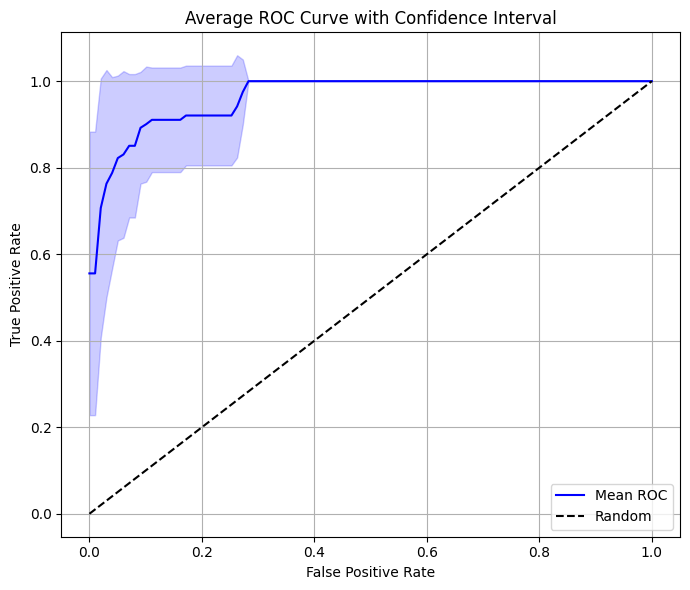

In [31]:
# Define parameter grid
param_grid = [
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
]

# Run Nested CV
results_class, fpr_all, tpr_all, thresholds_all, train_loss_curves, val_loss_curves = run_nested_cv_classifier(X, y, param_grid)

# Summarise Metrics
f1s = [r['F1'] for r in results_class]
precs = [r['Precision'] for r in results_class]
recalls = [r['Recall'] for r in results_class]
accs = [r['Accuracy'] for r in results_class]
aucs = [r['AUC'] for r in results_class]

print("\n📊 Final MLP Classification Results:")
print(f"F1:       {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"AUC:       {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# Plot ROC
plot_mean_roc(fpr_all, tpr_all)


- **F1-Score**: 0.788 ± 0.165  
- **Precision**: 0.742 ± 0.209  
- **Recall**: 0.863 ± 0.107  
- **Accuracy**: 0.969 ± 0.027  
- **AUC (ROC)**: 0.962 ± 0.040  

For a medical classification task with imbalanced classes, these are the strongest results. Among the linear and tree-based models, the highest F1-score achieved was approximately 0.68. The PyTorch MLP exceeded this by over 0.11, marking a large improvement in classification performance.

The model returned high recall, which is important for identifying as many fever cases as possible, for clinical screening. Precision is slightly more varied, but the model still maintains good overall balance between false positives and false negatives. The AUC of 0.96 demonstrates excellent separability between fever and non-fever cases across all thresholds. High accuracy is expected due to class imbalance, but the F1-score & recall confirms that performance is not inflated by majority class predictions.


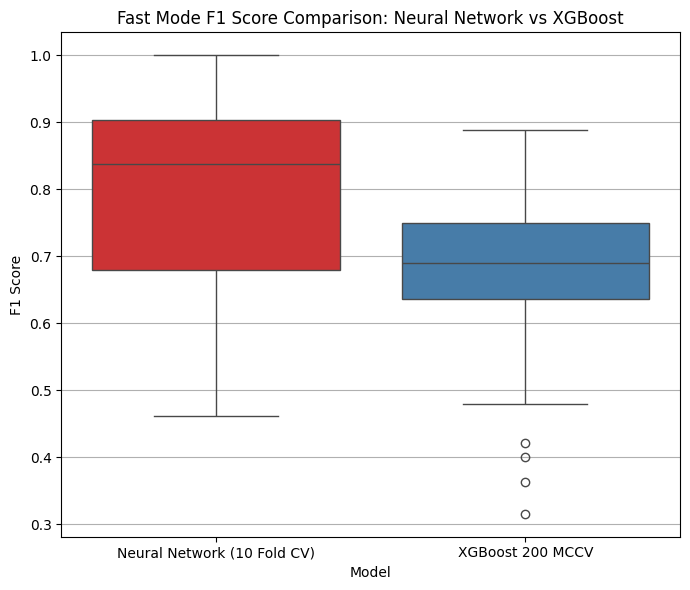

In [33]:
mlp_f1_scores = [r['F1'] for r in results_class]
mlp_df = pd.DataFrame({'F1': mlp_f1_scores, 'Model': 'Neural Network (10 Fold CV)'})

xgb_f1_scores = Fast_results_df[Fast_results_df["model"] == "XGBoost"]["F1-Score"].values
xgb_df = pd.DataFrame({'F1': xgb_f1_scores, 'Model': 'XGBoost (200 MC CV)'})

# Combine into one DataFrame
f1_comparison_df = pd.concat([mlp_df, xgb_df], ignore_index=True)

# Boxplot

plt.figure(figsize=(7, 6))
sns.boxplot(x='Model', y='F1', data=f1_comparison_df, palette='Set1')
plt.title("Fast Mode F1 Score Comparison: Neural Network vs XGBoost")
plt.ylabel("F1 Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### Best Model - Fast Mode Classification


**Neural Network vs XGBoost**

The box plot above compares the F1-scores of two models for classifying fever status using Fast Mode data:

- Neural Network (10-Fold Nested CV)
- XGBoost (200 Iteration Monte Carlo CV)

**Key Observations:**

- **Higher Median F1-Score for Neural Network**:  
  The neural network consistently achieves a **higher median F1-score (~0.84)** compared to XGBoost (~0.69), indicating better balance between precision and recall on average.

- **Wider Spread but Strong Upper Bound**:  
  While the neural network shows greater variability (as expected with fewer folds), many runs reach **near-perfect F1-scores (~1.0)**, showcasing its strong potential when well-tuned.

- **XGBoost Performance is More Stable but Lower**:  
  XGBoost demonstrates **tighter interquartile range**, but doesn’t reach the same upper-end performance. Some MCCV iterations return F1-scores below 0.5, which could reflect sensitivity to splits with few fever cases.

- **Outliers and Distribution**:  
  XGBoost has several **low-performing outliers**, whereas the neural network has fewer such instances. This suggests better generalisation ability in most cases for the MLP.

The neural network outperforms XGBoost in terms of F1-score distribution, despite being more variable. For medical screening tasks where recall is critical, this improvement is valuable — especially since the neural network achieves higher top-end results. However, XGBoost may remain preferred in situations where stability and explainability are prioritised.


**Monitor Mode**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.8000, AUC: 0.9609

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.9565, AUC: 0.9970

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.8485, AUC: 0.9746

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8235, AUC: 0.9816

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.7857, AUC: 0.9611

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.8889, AUC: 0.9649

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 1.0000, AUC: 1.0000

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8000, AUC: 0.9315

🔁 Outer Fold 9
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}

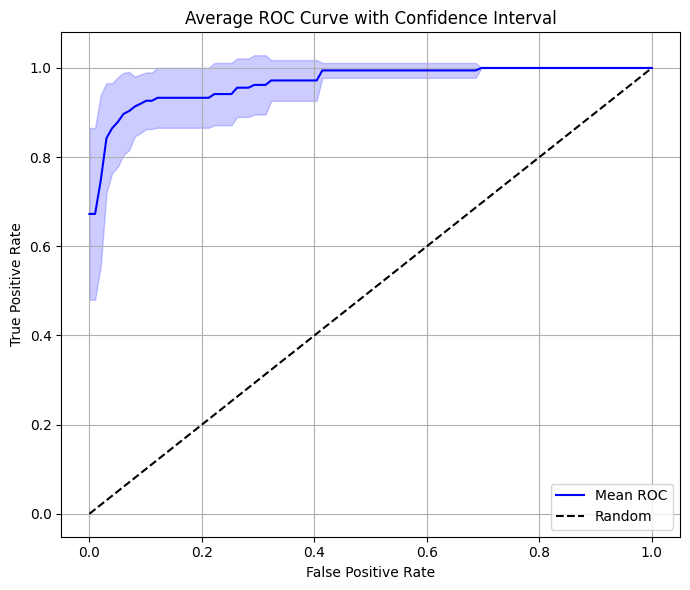

In [29]:
# ---- Run for Monitor Mode ---- #
param_grid = [
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1},
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
]

resultsM, fpr_allM, tpr_allM, thresholds_allM, train_loss_curvesM, val_loss_curvesM = run_nested_cv_classifier(X, y2, param_grid)

# Summarise Metrics
f1s = [r['F1'] for r in resultsM]
precs = [r['Precision'] for r in resultsM]
recalls = [r['Recall'] for r in resultsM]
accs = [r['Accuracy'] for r in resultsM]
aucs = [r['AUC'] for r in resultsM]

print("\n📊 Final MLP Classification Results:")
print(f"F1:       {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"AUC:       {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


plot_mean_roc(fpr_allM, tpr_allM)


The ROC curve above illustrates the mean true positive rate across outer folds for the monitor-mode neural network classifier, along with a shaded 95% confidence interval. The model shows **exceptional discriminative ability**, with the curve closely hugging the top-left corner — indicative of strong sensitivity and specificity.

- **F1-Score:**       0.855 ± 0.088  
- **Precision:**      0.826 ± 0.099  
- **Recall:**         0.892 ± 0.098  
- **Accuracy:**       0.966 ± 0.021  
- **AUC:**            0.968 ± 0.027

- **High Recall (0.892):**  
  The model successfully captures most fever cases which is important in clinical screening to minimize false negatives.

- **Excellent AUC (0.968):**  
  The ROC curve reflects strong performance across thresholds. The high area under the curve confirms that the classifier reliably separates the fever and non-fever classes.

- **Balanced Precision and F1-Score:**  
  The model still maintains strong precision (0.826), which results in a strong F1-score of .855 (higher than all other models).

These results suggest that the neural network is well-suited for fever detection under monitor-mode conditions. The consistently high scores and tight confidence intervals reinforce the model's reliability and potential for deployment in real-time health monitoring systems.


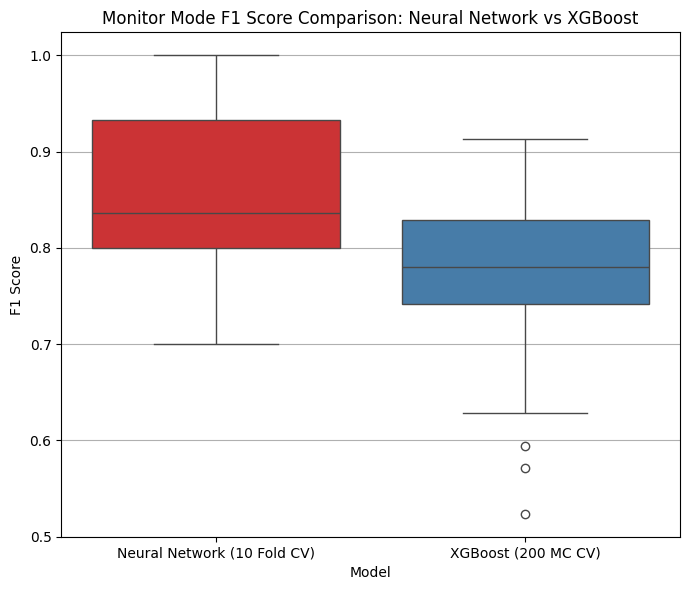

In [34]:
# Extract F1 scores for Monitor Mode Neural Network (MLP)
mlp_f1_scores = [r['F1'] for r in resultsM]
mlp_df = pd.DataFrame({'F1': mlp_f1_scores, 'Model': 'Neural Network (10 Fold CV)'})

# Extract F1 scores for Monitor Mode XGBoost
xgb_f1_scores = Monitor_results_df[Monitor_results_df["model"] == "XGBoost"]["F1-Score"].values
xgb_df = pd.DataFrame({'F1': xgb_f1_scores, 'Model': 'XGBoost (200 MC CV)'})

f1_comparison_df = pd.concat([mlp_df, xgb_df], ignore_index=True)

# Boxplot

plt.figure(figsize=(7, 6))
sns.boxplot(x='Model', y='F1', data=f1_comparison_df, palette='Set1')
plt.title("Monitor Mode F1 Score Comparison: Neural Network vs XGBoost")
plt.ylabel("F1 Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### Best Model - Monitor Mode Classification

**Neural Network vs XGBoost**

The boxplot above compares the F1-Score distribution of two models evaluated on the Monitor Mode setup:

- Neural Network (10-Fold Nested CV)
- XGBoost (200 Monte Carlo CV)

**Observations:**

- **Higher Median & Range:**  
  The neural network achieves a higher **median F1-Score**, with most values concentrated above 0.8. The interquartile range is also shifted upwards compared to XGBoost.

- **XGBoost Performance:**  
  XGBoost performs robustly but consistently lower than the neural network. While it shows less variability, its F1-scores cluster around ~0.78, with a few low outliers indicating instability under certain conditions.

- **Conclusion:**  
  The neural network reaches near-perfect F1-scores (up to 1.0) in some folds, suggesting its ability to fully capture the fever patterns in certain validation sets. This comparison shows that the **neural network outperforms XGBoost** in terms of F1-Score on the monitor-mode classification task. The higher median, upper quartile, and occasional perfect scores demonstrate its **greater flexibility and capacity** to model complex patterns when supported by stable preprocessing and nested cross-validation.


---
## 5.2 Regression with Nested Cross-Validation



Key steps and structure of the nested cross-validation (CV) implementation for the MLP regression model using PyTorch.

**Model: MLP (Multilayer Perceptron)**

- Defined using `nn.Sequential`, with:
  - Two hidden layers (`hidden1` and `hidden2`)
  - ReLU activations
  - Dropout for regularization
  - Final output layer with a single neuron for regression


**Outer Loop: 10-Fold Cross-Validation**

For model evaluation and final test metrics:
- `KFold(n_splits=10)` splits the entire dataset into 10 outer folds.
- In each outer fold:
  - 1 fold is used as the **test set**.
  - The remaining 9 folds go to the **inner loop** for model selection.


**Inner Loop: 5-Fold Cross-Validation**

For model selection (hyperparameter tuning):
- `KFold(n_splits=5)` is applied on the **training portion** from the outer loop.
- For each candidate parameter setting (different hidden layer sizes, dropout values):
  - Train and evaluate the model across 5 inner folds.
  - Lowest RMSE across folds determines the best configuration.


**Preprocessing (Done Separately for Each Outer Fold)**

- **Numerical Features**:
  - Imputed using `KNNImputer`.
  - Scaled using `StandardScaler`.
- **Categorical Features**:
  - One-hot encoded using `OneHotEncoder` (dropping the first level).
- **Target Variable**:
  - Scaled using `StandardScaler`.
  - Inverse transform applied later for RMSE/MAE reporting.

*All preprocessing is redone inside each outer fold to avoid data leakage.*


**Model Training with Early Stopping**

- Loss: Mean Squared Error (MSE).
- Optimizer: Adam.
- Batch size: 32.
- Early stopping:
  - Stops training if validation loss doesn't improve for `patience = 10` epochs.
  - Tracks best model (lowest val loss).
- Outputs:
  - Validation predictions (inverse transformed).
  - Training and validation loss curves per epoch.

**Learning Curve Plot**

- Average training/validation loss across outer folds.
- Confidence intervals (±1 std) shaded.
- Vertical line shows **average early stopping epoch**.
- Useful for diagnosing under/overfitting and training dynamics.

**Final Outputs**

- **Average performance metrics**:
  - RMSE, MAE, R² across outer folds.
$$
\frac{\sum_{k=1}^{10} \text{RMSE}_k}{10-FOLDS}
$$
- **True vs. predicted scatter plot** using all test folds.



In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- Load and Prepare Raw Data ---- #
from ucimlrepo import fetch_ucirepo
infrared_thermography_temperature = fetch_ucirepo(id=925)
X_full = infrared_thermography_temperature.data.features
y_full = infrared_thermography_temperature.data.targets

# ---- Define MLP Model Class ---- #
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.net(x)

# ---- Training & Evaluation Function with Early Stopping ---- #
def train_evaluate_model(X_train, y_train, X_val, y_val, params, y_scaler, return_preds=False):
    model = MLP(input_dim=X_train.shape[1], **params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    best_model = None
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(100):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model = best_model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor).numpy()
        y_true = y_val_tensor.numpy()
        y_pred = y_scaler.inverse_transform(y_pred)
        y_true = y_scaler.inverse_transform(y_true)

    if return_preds:
        return y_true.flatten(), y_pred.flatten()

    return {
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# ---- Nested Cross-Validation Function ---- #
def run_nested_cv(X_raw, y_raw, param_grid):
    outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_kf = KFold(n_splits=5, shuffle=True, random_state=1)

    outer_results = []
    y_trues_all, y_preds_all = [], []
    train_loss_curves, val_loss_curves, early_stops = [], [], []

    X_raw = X_raw.reset_index(drop=True)
    y_raw = y_raw.reshape(-1, 1)

    for fold, (train_idx, test_idx) in enumerate(outer_kf.split(X_raw)):
        print(f"\n🔁 Outer Fold {fold+1}")
        X_outer_train_raw, X_outer_test_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
        y_outer_train_raw, y_outer_test_raw = y_raw[train_idx], y_raw[test_idx]

        categorical_cols = X_outer_train_raw.select_dtypes(include='object').columns.tolist()
        numerical_cols = X_outer_train_raw.select_dtypes(include=[np.number]).columns.tolist()

        preprocessor = ColumnTransformer(transformers=[
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ])

        X_train_outer = preprocessor.fit_transform(X_outer_train_raw)
        X_test_outer = preprocessor.transform(X_outer_test_raw)

        y_scaler = StandardScaler()
        y_train_outer = y_scaler.fit_transform(y_outer_train_raw)
        y_test_outer = y_scaler.transform(y_outer_test_raw)

        best_score = float('inf')
        best_params = None

        for params in param_grid:
            inner_scores = []
            for inner_train_idx, val_idx in inner_kf.split(X_train_outer):
                X_train_inner, X_val_inner = X_train_outer[inner_train_idx], X_train_outer[val_idx]
                y_train_inner, y_val_inner = y_train_outer[inner_train_idx], y_train_outer[val_idx]

                score = train_evaluate_model(X_train_inner, y_train_inner, X_val_inner, y_val_inner, params, y_scaler)
                inner_scores.append(score['RMSE'])

            avg_score = np.mean(inner_scores)
            if avg_score < best_score:
                best_score = avg_score
                best_params = params

        print(f"✅ Best Params: {best_params}")

        result = train_evaluate_model(X_train_outer, y_train_outer, X_test_outer, y_test_outer, best_params, y_scaler)
        y_true, y_pred = train_evaluate_model(X_train_outer, y_train_outer, X_test_outer, y_test_outer, best_params, y_scaler, return_preds=True)
        y_trues_all.extend(y_true)
        y_preds_all.extend(y_pred)

        outer_score = {
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R2': result['R2']
        }
        train_loss_curves.append(result['train_losses'])
        val_loss_curves.append(result['val_losses'])
        early_stops.append(len(result['val_losses']))
        outer_results.append(outer_score)

        print(f"📊 Outer Fold Test RMSE: {outer_score['RMSE']:.4f}, MAE: {outer_score['MAE']:.4f}, R²: {outer_score['R2']:.4f}")

    return outer_results, y_trues_all, y_preds_all, train_loss_curves, val_loss_curves, early_stops

# ---- Function: Plot Learning Curves with Confidence Intervals ---- #
def plot_learning_curves(train_loss_curves, val_loss_curves, early_stops):
    min_len = min(len(x) for x in train_loss_curves)
    train_trimmed = np.array([x[:min_len] for x in train_loss_curves])
    val_trimmed = np.array([x[:min_len] for x in val_loss_curves])

    avg_train_loss = np.mean(train_trimmed, axis=0)
    avg_val_loss = np.mean(val_trimmed, axis=0)
    std_train_loss = np.std(train_trimmed, axis=0)
    std_val_loss = np.std(val_trimmed, axis=0)
    avg_early_stop = int(np.mean(early_stops))

    epochs = np.arange(min_len)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, avg_train_loss, label='Avg Train Loss', color='blue')
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.2, color='blue')

    plt.plot(epochs, avg_val_loss, label='Avg Val Loss', color='orange')
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.2, color='orange')
    if avg_early_stop < min_len:
        plt.axvline(x=avg_early_stop, color='gray', linestyle='--', label=f'Avg Early Stopping (~{avg_early_stop})')


    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Average Training vs Validation Loss with Confidence Intervals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Fast Mode**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.1920, MAE: 0.1450, R²: 0.5256

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.1856, MAE: 0.1401, R²: 0.7798

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2122, MAE: 0.1573, R²: 0.7126

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold Test RMSE: 0.2612, MAE: 0.1872, R²: 0.5680

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold Test RMSE: 0.2591, MAE: 0.1856, R²: 0.6975

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold Test RMSE: 0.2039, MAE: 0.1536, R²: 0.7291

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold Test RMSE: 0.2279, MAE: 0.1540, R²: 0.5831

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 64, 'hidden2': 3

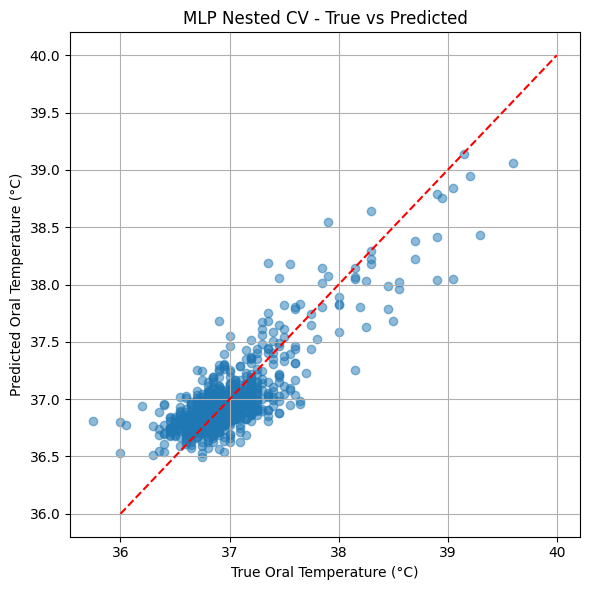

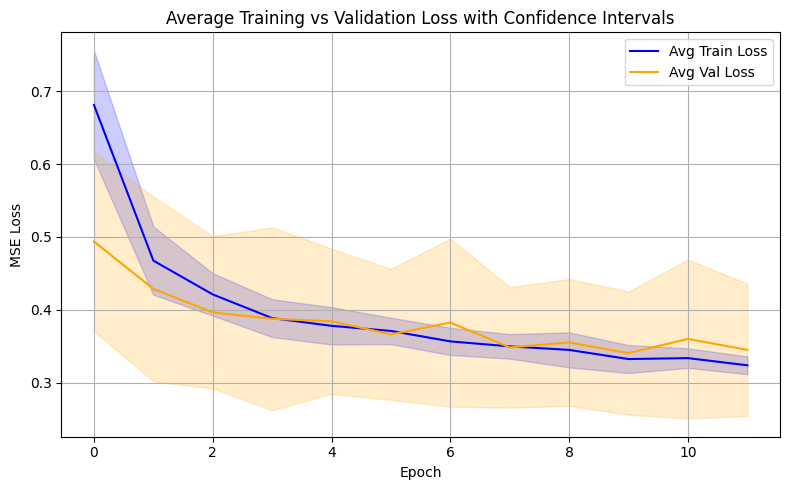

In [37]:
X_fast = X_full[X_full["Distance"] <= 10]
y_fast = y_full.loc[X_fast.index, "aveOralF"].to_numpy()

param_grid = [
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3},
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
]

results, y_true_all, y_pred_all, train_loss_curves, val_loss_curves, early_stops = run_nested_cv(X_fast, y_fast, param_grid)

# ---- Summary ---- #
all_rmse = [r['RMSE'] for r in results]
all_mae = [r['MAE'] for r in results]
all_r2 = [r['R2'] for r in results]

print("\n📈 Final Nested CV Results:")
print(f"Mean RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Mean MAE:  {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"Mean R²:   {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")

# ---- Plot Average Predictions vs True ---- #
plt.figure(figsize=(6, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5)
plt.plot([36, 40], [36, 40], 'r--')
plt.xlabel("True Oral Temperature (°C)")
plt.ylabel("Predicted Oral Temperature (°C)")
plt.title("MLP Nested CV - True vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Curves ---- #
plot_learning_curves(train_loss_curves, val_loss_curves, early_stops)


- **Mean RMSE:** `0.2157 ± 0.0256`
- **Mean MAE:**  `0.1578 ± 0.0152`
- **Mean R²:**   `0.6692 ± 0.0836`

- **RMSE** reflects the average magnitude of error in degrees Celsius. A mean RMSE of ~0.22 means the model's predictions typically fall within ±0.2°C of the true oral temperature.

- **MAE** of ~0.16 is also quite low, showing the model is not heavily skewed by outliers.

- **R² ≈ 0.67** indicates the model explains about two-thirds of the variance in oral temperature using sensor features alone.

**Supporting Plots**

1. **True vs Predicted Plot**:
   - Most points are tightly clustered around the identity line (red dashed line), especially between 36.5-38°C.
   - Indicates strong predictive calibration in the clinically relevant range.

2. **Learning Curves (Averaged Across Folds)**:
   - Training and validation losses both decrease smoothly and stay close together.
   - Suggests:
     - No significant overfitting.
     - Strong generalization.
   - Confidence intervals are narrow for training and however they are wide for validation indicating quite large variabily.
   - Early stopping is working well is mitigating overfitting.




### Best Model - Fast Mode Regression

- Among the linear and tree-based models, XGBoost achieved the lowest RMSE at 0.249 ± 0.017.
- The MLP model outperformed this with a **Mean RMSE of 0.2157 ± 0.0256**, making it the top-performing model for Fast Mode and the recommended choice based on predictive accuracy.


**Monitor Mode**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold Test RMSE: 0.2159, MAE: 0.1733, R²: 0.6903

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2257, MAE: 0.1772, R²: 0.8372

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2187, MAE: 0.1743, R²: 0.8319

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2416, MAE: 0.1803, R²: 0.7940

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2512, MAE: 0.2006, R²: 0.7988

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2287, MAE: 0.1789, R²: 0.8093

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold Test RMSE: 0.2495, MAE: 0.1838, R²: 0.7092

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 32, 'hidden2'

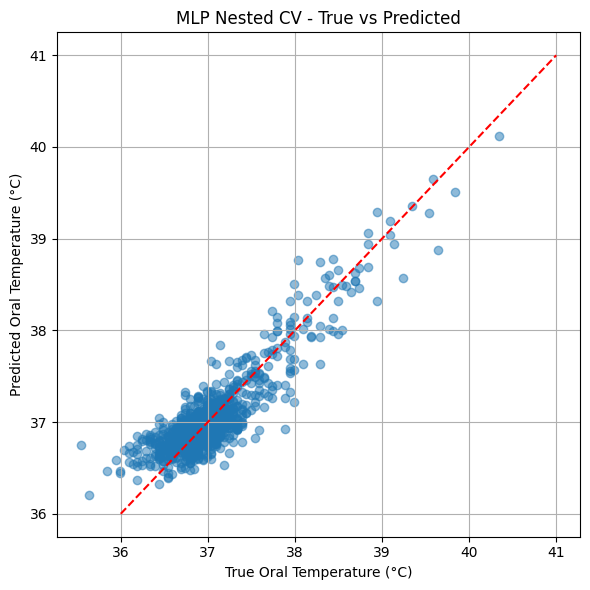

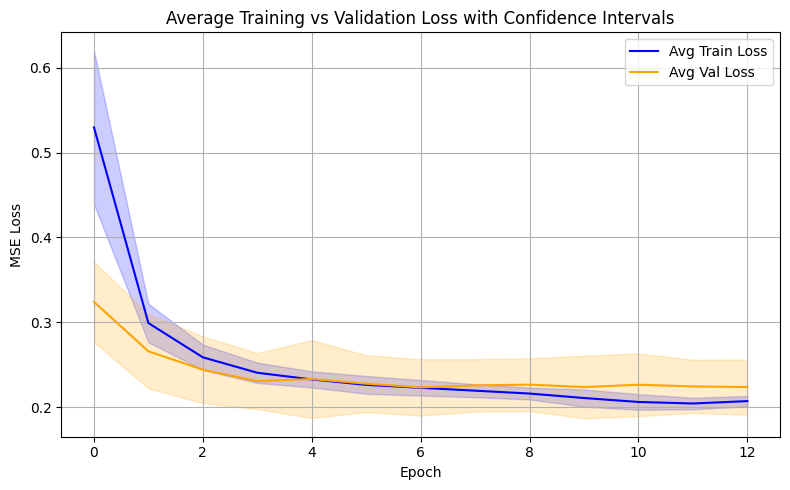

In [38]:
# ---- Example Run for Fast Mode ---- #
X_mod = X_full[X_full["Distance"] <= 10]
y_mod = y_full.loc[X_fast.index, "aveOralM"].to_numpy()

param_grid = [
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3},
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
]

results, y_true_all, y_pred_all, train_loss_curves, val_loss_curves, early_stops = run_nested_cv(X_mod, y_mod, param_grid)

# ---- Summary ---- #
all_rmse = [r['RMSE'] for r in results]
all_mae = [r['MAE'] for r in results]
all_r2 = [r['R2'] for r in results]

print("\n📈 Final Nested CV Results:")
print(f"Mean RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Mean MAE:  {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"Mean R²:   {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")

# ---- Plot Average Predictions vs True ---- #
plt.figure(figsize=(6, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5)
plt.plot([36, 41], [36, 41], 'r--')
plt.xlabel("True Oral Temperature (°C)")
plt.ylabel("Predicted Oral Temperature (°C)")
plt.title("MLP Nested CV - True vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Curves ---- #
plot_learning_curves(train_loss_curves, val_loss_curves, early_stops)


- Mean RMSE: 0.2338 ± 0.0177  
- Mean MAE:  0.1805 ± 0.0155  
- Mean R²:   0.7755 ± 0.0601  

The relatively low RMSE and MAE, alongside a high R² score, indicate that the MLP model is able to generalise well across different data splits and capture meaningful relationships in the input features.

The accompanying scatter plot (True vs. Predicted) shows that most predictions are closely clustered around the identity line, with only mild underprediction in a small number of febrile cases.

The training and validation loss curves confirm that the model trained stably and consistently across folds, with minimal overfitting. The shaded regions represent ±1 standard deviation across outer folds, offering insight into the variability.

Overall, the MLP shows strong results for regression in the Monitor Mode setting and may serve as a competitive benchmark against XGBoost.


### Best Model - Monitor Mode Regression

- Among the linear and tree-based models, XGBoost achieved the lowest RMSE at **0.249 ± 0.017**.
- The MLP model outperformed this with a **Mean RMSE of 0.2338 ± 0.0177**, making it the top-performing model for Monitor Mode and the recommended choice based on predictive accuracy.


# 6. CONCLUSION

This project presented a comprehensive machine learning workflow to model oral temperature and fever classification using the Infrared Thermography Temperature Dataset. The work followed a structured pipeline that included dataset exploration, methodological design, model development, validation strategies, and advanced neural network experimentation.

### Summary of Key Steps

- **Dataset Exploration**  
  - Feature correlation and interaction analyses were performed to identify redundancies and gain insight into thermal measurements.
  - Classification targets were identified as imbalanced, guiding the use of F1-score as a key metric during model selection.

- **Methodology Design**  
  - Multiple models were tested for both classification and regression, including logistic regression, decision trees, ensemble models (random forest and XGBoost), and regularized linear models (elastic net and ridge).
  - Monte Carlo Cross-Validation (MC CV) was implemented to ensure robust model evaluation and stability in performance estimates.
  - Evaluation metrics were selected based on the task: F1-score and AUC for classification, and RMSE, MAE, and R² for regression.
  - A custom PyTorch-based Multilayer Perceptron (MLP) was built and integrated into a **nested cross-validation** pipeline with inner-loop hyperparameter tuning and outer-loop generalisation testing.

- **Model Performance Classification**  
  - In the classification task, both Fast Mode and Monitor Mode settings were tested. Models like Logistic Regression, Random Forest, XGBoost, and Elastic Net all showed strong results.  
  - The MLP classifier consistently achieved strong F1-scores, outperforming XGBoost in many folds, particularly in Monitor Mode.
  - **FAST MODE: MLP achieved best mean F1-Score: 0.788 ± 0.165**
  - **MONITOR MODE: MLP achieved best mean F1-Score: 0.855 ± 0.088**


- **Model Performance Regression**  
  - In the regression task, both Fast Mode and Monitor Mode settings were tested. Models like Linear Regression, Random Forest, XGBoost, and Elastic Net all showed strong results.  
  - **The MLP regressor achieved strongest performance in both Fast and Monitor Modes, with nested CV RMSEs of 0.226 (Fast)** and **0.216 (Monitor)**.


- **Reflections**

  - Monitor Mode thermal data returns higher predictive accuracy due to its lower noise and more stable readings.
  - Neural networks perform better with tree-based models and offer flexibility when paired with careful hyperparameter tuning and early stopping.
  - Elastic net regarlisation returned competetive results across both classification and regression.
  - The most influential predictors are all temperature-derived features from specific facial regions.

  Overall, the results demonstrate the feasibility of using thermal imaging data for non-invasive fever screening. MLPs provide a powerful framework for both continuous temperature prediction and binary fever detection. These findings pave the way for future extensions, such as the deployment of lightweight neural models in mobile.





# References

- Infrared Thermography for Measuring Elevated Body Temperature: Clinical Accuracy, Calibration, and Evaluation *Wang & Zhou, Published in the Italian National Conference on Sensors, 2021*  
[View Paper on Semantic Scholar](https://www.semanticscholar.org/paper/Infrared-Thermography-for-Measuring-Elevated-Body-Wang-Zhou/443b9932d295ca3a014e7d874b4bd77a33a276bd)

* [Aurelien Geron - Hands-on machine learning with scikit-learn, keras, and tensorflow: concepts, tools, and techniques to build intelligent systems](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
* [Gareth James, Daniela Witten, Trevor Hastie - An Introduction to Statistical Learning](https://www.statlearning.com/)
* [Max Kuhn, Kjell Johnson - Applied Predictive Modeling](https://link.springer.com/book/10.1007/978-1-4614-6849-3)
* [Ewout W. Steyerberg - Clinical Prediction Models](https://link.springer.com/book/10.1007/978-3-030-16399-0)
* [Frank E. Harrell, Jr - Regression Modeling Strategies](https://link.springer.com/book/10.1007/978-3-319-19425-7)